<a href="https://colab.research.google.com/github/satadrudas98/Coursera-deeplearning.ai-assignments/blob/master/Copy_of_ST__bVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Create the training dataset.(one set with just the design array which will be used just for traing the bVAE, and another set with design array with their respective FOM which will be used to train tme FM)
    
2.   From the FM we generate the alpha, beta and the J matrix

3.   With the obtained parameters, we run the Ising machine, from which we obtain the optimised binary bit string

4.   We feed it back to the Generator and get the design and check the FOM.



# Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path='/content/gdrive/MyDrive/STbVAE/'


#Ceviche simulations1

In [ ]:
!pip install ceviche

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyMKL: filename=pyMKL-0.0.3-py3-none-any.whl size=6751 sha256=4387cc92e5418729f5c2518b4da9092e47d874d0ab2a03125e536e372474144a
  Stored in directory: /root/.cache/pip/wheels/81/04/ab/16d8283a3d13287e586d9fc14df7d9ff36c810f4bbb5d03146
Successfully built pyMKL


Notebook3

In [ ]:
import numpy as np
import autograd.numpy as npa

import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [ ]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1 
def operator_proj(rho, eta=0.5, beta=100, N=1):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    N       : Number of times to apply the projection
    """
    for i in range(N):
        rho =  npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                          npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))
    
    return rho

# Blurring filter that results in smooth features of the structure
# First we define a function to create the kernel
def _create_blur_kernel(radius):
    """Helper function used below for creating the conv kernel"""
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    return  kernel/kernel.sum()

# Then we define the function to apply the operation
def operator_blur(rho, radius=2, N=1):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle for the conv kernel filter
    N         : Number of times to apply the filter
    
    Note that depending on the radius, the kernel is not always a
    perfect circle due to "pixelation" / stair casing
    """
    
    kernel = _create_blur_kernel(radius)
    
    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]
    
    return rho

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


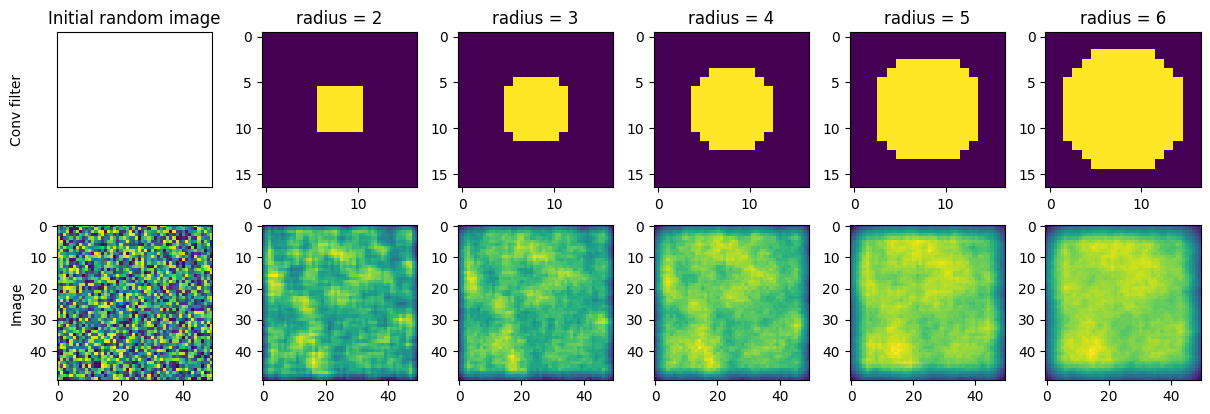

In [ ]:
# Specify a range of values for the blur radius
blur_radii = [2, 3, 4, 5, 6]

# Number of times to apply the blur filter
N_blur = 1

# Define a random 2D array to test our blur filter on
rho = np.random.rand(50, 50)

# Create a figure with panels to plot into
fig, axs = plt.subplots(2, len(blur_radii)+1,figsize=(12,4), constrained_layout=True)

# First, plot a dummy conv filter
axs[0,0].set_title('Initial random image')
axs[0,0].imshow(np.zeros((1,1)), vmin=0, cmap='Greys')
# And also plot the initial random image
axs[1,0].imshow(rho)

# Now, loop over the blur radii and visualize each result
for i, radius in enumerate(blur_radii):
    kernel = _create_blur_kernel(radius)
    
    kernel_pad = np.pad(kernel, (2+np.max(blur_radii)-radius, 2+np.max(blur_radii)-radius),
                        'constant', constant_values=(0, 0))
    axs[0,i+1].imshow(kernel_pad, vmin=0)
    
    axs[0,i+1].set_title('radius = %d' % radius)

    rho_p = operator_blur(rho, radius=radius, N=N_blur)
    axs[1,i+1].imshow(rho_p)

axs[0,0].set_yticks([])
axs[0,0].set_xticks([])
axs[0,0].set_ylabel('Conv filter')
axs[1,0].set_ylabel('Image')

fig.align_labels()
plt.show()

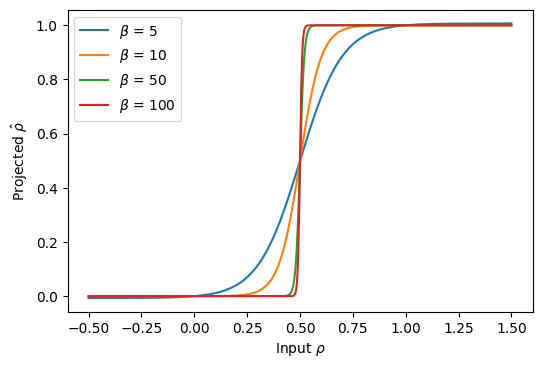

In [ ]:
rho = np.linspace(-0.5, +1.5, 999)

# Visualize different values of the projection strength
plt.figure()
for beta in [5, 10, 50, 100]:
    plt.plot(rho, operator_proj(rho, beta=beta), label=r"$\beta$ = %d" % beta)

plt.xlabel(r"Input $\rho$")
plt.ylabel(r"Projected $\hat{\rho}$")
plt.legend()
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


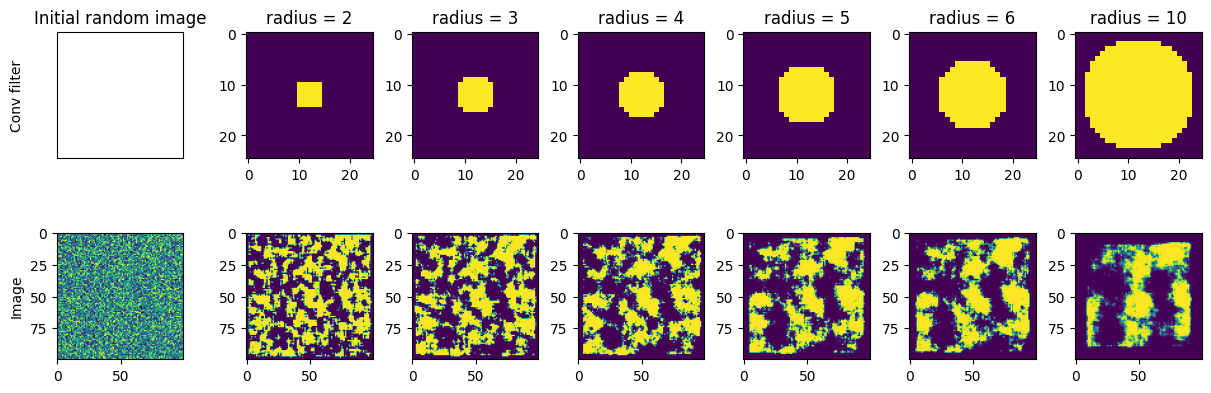

In [ ]:
# Specify a range of values for the blur radius
blur_radii = [2, 3, 4, 5, 6, 10]

# Number of times to apply the blur filter
N_blur = 1

# Number of times to apply the projection operator
N_proj = 1

# Specify beta value to use for projection
beta = 200

# Specify eta value to use for projection
eta = 0.5

# Define a random 2D array to test our blur filter on
rho = np.random.rand(100, 100)

# Create a figure with panels to plot into
fig, axs = plt.subplots(2, len(blur_radii)+1,figsize=(12,4), constrained_layout=True)

# First, plot a dummy conv filter
axs[0,0].set_title('Initial random image')
axs[0,0].imshow(np.zeros((1,1)), vmin=0, cmap='Greys')
# And also plot the initial random image
axs[1,0].imshow(rho)

# Now, loop over the blur radii and visualize each result
for i, radius in enumerate(blur_radii):
    kernel = _create_blur_kernel(radius)
    
    kernel_pad = np.pad(kernel, (2+np.max(blur_radii)-radius, 2+np.max(blur_radii)-radius),
                        'constant', constant_values=(0, 0))
    axs[0,i+1].imshow(kernel_pad, vmin=0)
    
    axs[0,i+1].set_title('radius = %d' % radius)

    rho_p = operator_blur(rho, radius=radius, N=N_blur)
    rho_p = operator_proj(rho_p, beta=beta, eta=eta, N=N_proj)
    axs[1,i+1].imshow(rho_p)

axs[0,0].set_yticks([])
axs[0,0].set_xticks([])
axs[0,0].set_ylabel('Conv filter')
axs[1,0].set_ylabel('Image')

fig.align_labels()
plt.show()

In [ ]:
# Angular frequency of the source in 1/s
omega=2*np.pi*200e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=120
# Number of pixels in y-direction
Ny=120
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Radius of the smoothening features
blur_radius=5
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
beta=500.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1
# Space between the PMLs and the design region (in pixels)
space=10
# Width of the waveguide (in pixels)
wg_width=12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=8

# Number of epochs in the optimization 
Nsteps=50
# Step size for the Adam optimizer
step_size=5e-3

In [ ]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    rho = np.zeros((Nx, Ny))  
    bg_rho = np.zeros((Nx, Ny))  
    design_region = np.zeros((Nx, Ny))
    
    # Input waveguide
    bg_rho[0:int(Npml+space),int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice)))
    
    # Output waveguide 
    bg_rho[int(Nx-Npml-space)::,int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1
    
    # Output probe slice
    output_slice = Slice(x=np.array(Nx-Npml-1), 
                         y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice)))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    
    # Const init
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0.5
    # Random init
    # rho = design_region * np.random.rand(Nx, Ny)

    return rho, bg_rho, design_region, input_slice, output_slice

def viz_sim(epsr, source, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    ceviche.viz.real(Ez, outline=epsr, ax=ax[0], cbar=False)
    for sl in slices:
        ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
    ceviche.viz.abs(epsr, ax=ax[1], cmap='Greys');
    plt.show()
    
    return (simulation, ax)

def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(np.float)


def epsr_parameterization(rho, bg_rho, design_region, radius=2, N_blur=1, beta=100, eta=0.5, N_proj=1):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho; Note: this is so the subsequent blur sees the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    rho = operator_blur(rho, radius=radius, N=N_blur)
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)
    
    # Final masking undoes the blurring of the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    return epsr_min + (epsr_max-epsr_min) * rho

def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

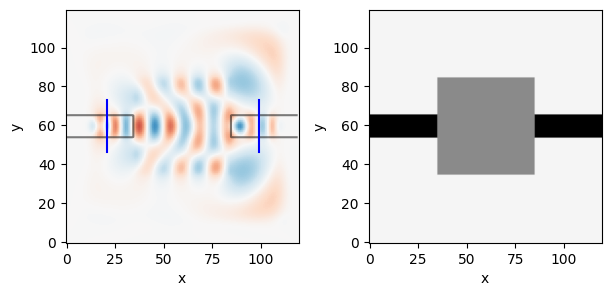

In [ ]:
# Initialize the parametrization rho and the design region
rho, bg_rho, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_parameterization(rho, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_init, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_init, m=2)

# Simulate initial device
simulation, ax = viz_sim(epsr_init, source, slices=[input_slice, output_slice])

# get normalization factor (field overlap before optimizing)
_, _, Ez = simulation.solve(source)
E0 = mode_overlap(Ez, probe)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

Epoch:   1/ 10 | Duration: 0.30 secs | Value: 1.000000e+00
Epoch:   2/ 10 | Duration: 0.28 secs | Value: 4.456358e+06
Epoch:   3/ 10 | Duration: 0.29 secs | Value: 1.271317e+07
Epoch:   4/ 10 | Duration: 0.28 secs | Value: 1.435436e+07
Epoch:   5/ 10 | Duration: 0.28 secs | Value: 1.480551e+07
Epoch:   6/ 10 | Duration: 0.28 secs | Value: 1.572114e+07
Epoch:   7/ 10 | Duration: 0.30 secs | Value: 1.699668e+07
Epoch:   8/ 10 | Duration: 0.27 secs | Value: 1.788797e+07
Epoch:   9/ 10 | Duration: 0.28 secs | Value: 1.845224e+07
Epoch:  10/ 10 | Duration: 0.55 secs | Value: 1.876436e+07


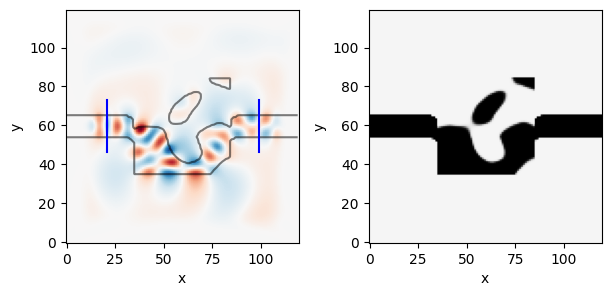

In [ ]:
def objective(rho):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return mode_overlap(Ez, probe) / E0




# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                         Nsteps=10, direction='max', step_size=step_size)


#rho_optimum=rho
#rho_optimum[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space]=np.random.randint(0,2,[Nx-Npml-space-(Npml+space), Ny-Npml-space-(Npml+space)],dtype=int)
# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

viz_sim(epsr, source, slices=[input_slice, output_slice]);





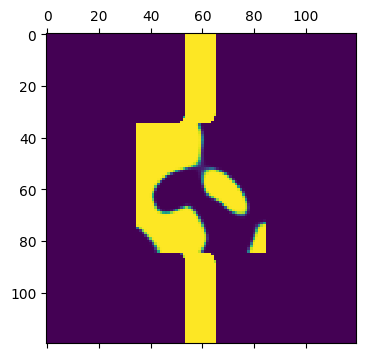

In [ ]:
plt.matshow(epsr)

In [ ]:
Npml+space-(Nx-Npml-space)

-60

In [ ]:
np.shape(design_region)

(120, 120)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

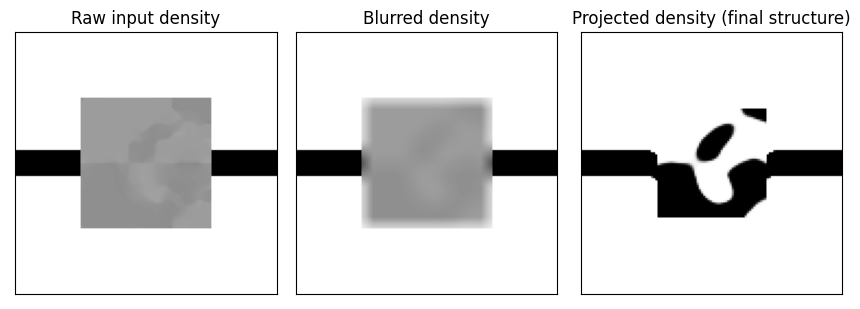

In [ ]:
fig, axs = plt.subplots(1,3,constrained_layout=True,sharex=True,sharey=True, figsize=(8.5,3))
Z = mask_combine_rho(rho_optimum, bg_rho, design_region)
ceviche.viz.abs(Z, cmap='Greys', ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_xticks([])
axs[0].set_ylabel('')
axs[0].set_yticks([])
axs[0].set_title('Raw input density')

Z = mask_combine_rho(rho_optimum, bg_rho, design_region)
Z = operator_blur(Z, radius=blur_radius, N=N_blur)
# Z = operator_proj(Z, beta=beta, eta=eta)
Z = mask_combine_rho(Z, bg_rho, design_region)
ceviche.viz.abs(Z, cmap='Greys', ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_title('Blurred density')

Z = rho_optimum
Z = mask_combine_rho(Z, bg_rho, design_region)
Z = operator_blur(Z, radius=blur_radius, N=N_blur)
Z = operator_proj(Z, beta=beta, eta=eta, N=N_proj)
Z = mask_combine_rho(Z, bg_rho, design_region)
ceviche.viz.abs(Z, cmap='Greys', ax=axs[2])
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].set_title('Projected density (final structure)');

In [ ]:
def objective(rho, penalty_weight=1e8): 
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    
    # This penalty term is directly proportional to the material area
    # penalty = penalty_weight * (design_region*(epsr-1)).sum() # penalty_weight = 1e-10
    
    # This penalty term is the L2-norm of the raw density
    penalty = penalty_weight * npa.linalg.norm(rho)
    
    return mode_overlap(Ez, probe) / E0 - penalty

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

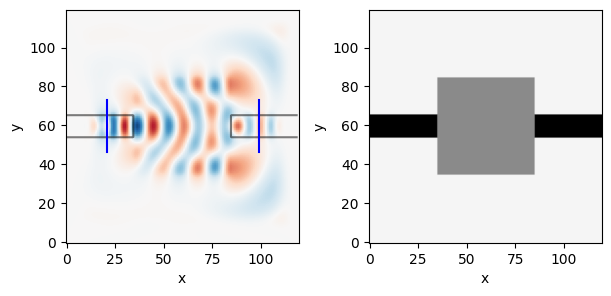

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

Epoch:   1/ 50 | Duration: 0.53 secs | Value: -3.000000e+09
Epoch:   2/ 50 | Duration: 0.47 secs | Value: -2.994089e+09
Epoch:   3/ 50 | Duration: 0.51 secs | Value: -2.985150e+09
Epoch:   4/ 50 | Duration: 0.70 secs | Value: -2.976833e+09
Epoch:   5/ 50 | Duration: 0.69 secs | Value: -2.970420e+09
Epoch:   6/ 50 | Duration: 0.70 secs | Value: -2.963942e+09
Epoch:   7/ 50 | Duration: 0.54 secs | Value: -2.956911e+09
Epoch:   8/ 50 | Duration: 0.70 secs | Value: -2.949055e+09
Epoch:   9/ 50 | Duration: 0.68 secs | Value: -2.941095e+09
Epoch:  10/ 50 | Duration: 0.63 secs | Value: -2.933183e+09
Epoch:  11/ 50 | Duration: 0.71 secs | Value: -2.924825e+09
Epoch:  12/ 50 | Duration: 0.67 secs | Value: -2.916705e+09
Epoch:  13/ 50 | Duration: 0.61 secs | Value: -2.907614e+09
Epoch:  14/ 50 | Duration: 0.80 secs | Value: -2.897752e+09
Epoch:  15/ 50 | Duration: 0.57 secs | Value: -2.888235e+09
Epoch:  16/ 50 | Duration: 0.67 secs | Value: -2.879241e+09
Epoch:  17/ 50 | Duration: 0.83 secs | V

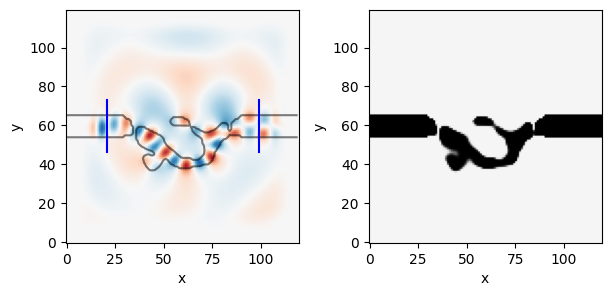

In [ ]:
## Initialize the parametrization rho and the design region
rho, bg_rho, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_parameterization(rho, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_init, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_init, m=2)

# Simulate initial device
viz_sim(epsr_init, source, slices=[input_slice, output_slice])

# Run optimization
objective_jac = jacobian(objective, mode='reverse')
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                         Nsteps=50, direction='max', step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr_pen = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
viz_sim(epsr_pen, source, slices=[input_slice, output_slice]);

In [ ]:
# Calculate areas
def calc_design_area(design_region, epsr_max, epsr_min, epsr, dl):
    """Computes the area of material used in the design region
    """
    A = ((epsr-epsr_min)/epsr_max * design_region).sum() * dl**2 * 1e12
    A_design_region = design_region.sum() * (dl)**2 * 1e12
    return A, A_design_region

_, A_design_region = calc_design_area(design_region, epsr_max, epsr_min, epsr, dl)
A_original, _ = calc_design_area(design_region, epsr_max, epsr_min, epsr, dl)
A_pen, _ = calc_design_area(design_region, epsr_max, epsr_min, epsr_pen, dl)

# Print summary
print('Design region area: %.2f um^2' % A_design_region)
print('Unpenalized design area: %.2f um^2' % A_original)
print('Penalized design area: %.2f um^2' % A_pen)
print('---')
print('Improvement: %.2f%%' % (100*(1-A_pen/A_original)))

Design region area: 5.76 um^2
Unpenalized design area: 1.91 um^2
Penalized design area: 1.03 um^2
---
Improvement: 46.07%


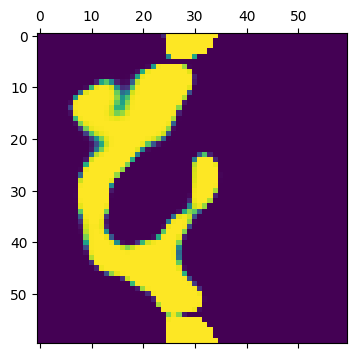

In [ ]:
plt.matshow(epsr_pen[30:90,30:90])

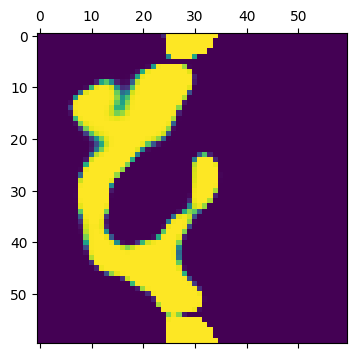

In [ ]:
plt.matshow(epsr_pen[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space])


In [ ]:
np.shape(epsr[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space])

(60, 60)



---



---



---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

Epoch:   1/  1 | Duration: 0.29 secs | Value: 1.000000e+00


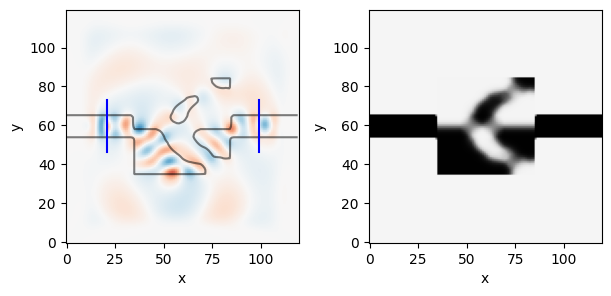

In [ ]:

def objective(rho):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    

    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return mode_overlap(Ez, probe) / E0

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,   Nsteps=1, direction='max', step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

viz_sim(epsr, source, slices=[input_slice, output_slice]);

In [ ]:
 dataset=[[loss,epsr[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space].flatten()]]
 dataset

[[[0.9999999980365086],
  array([ 1.0000,  1.0000,  1.0000, ...,  1.0000,  1.0000,  1.0000])]]

In [ ]:
#to record the epsilon_r distribution every iteration, this is just to generate the dataset, doesn't have to be optimized

def epsr_timestep(loss=loss, epsr=epsr):
  es=[epsr[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space].flatten()]
  l=[loss]
  #dataset=[[loss,epsr[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space].flatten()]] #in the format [[l,a],[l,a][]]
  rho_optimum=rho
  max_obj=0


  for i in range(250):
    
    (rho_optimum, loss) = adam_optimize(objective, rho_optimum.flatten(), objective_jac, Nsteps=1, direction='max', step_size=step_size)
    if (objective(rho_optimum)>max_obj):
      max_obj=objective(rho_optimum)
      r=rho_optimum.reshape((Nx, Ny))
    rho_optimum = rho_optimum.reshape((Nx, Ny))

    epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, radius=2, N_blur=N_blur, beta=1000, eta=eta, N_proj=N_proj)
    es=np.append(es,[np.array(epsr[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space].flatten())],axis=0)
    l=np.append(l,loss)
    #dataset=np.append(dataset,[[loss,np.array(epsr[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space].flatten())]])
  return max_obj,r,es,l

    
    

In [ ]:
max_obj,r,es,y_l=epsr_timestep()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

Epoch:   1/  1 | Duration: 0.54 secs | Value: 1.000000e+00
Epoch:   1/  1 | Duration: 0.55 secs | Value: 4.456358e+06
Epoch:   1/  1 | Duration: 0.56 secs | Value: 7.401262e+06
Epoch:   1/  1 | Duration: 0.63 secs | Value: 7.287630e+06
Epoch:   1/  1 | Duration: 0.57 secs | Value: 7.670364e+06
Epoch:   1/  1 | Duration: 0.60 secs | Value: 3.397812e+06
Epoch:   1/  1 | Duration: 0.57 secs | Value: 6.636089e+06
Epoch:   1/  1 | Duration: 0.52 secs | Value: 1.212859e+07
Epoch:   1/  1 | Duration: 0.84 secs | Value: 1.616642e+07
Epoch:   1/  1 | Duration: 0.64 secs | Value: 1.452001e+07
Epoch:   1/  1 | Duration: 0.57 secs | Value: 1.390542e+07
Epoch:   1/  1 | Duration: 0.61 secs | Value: 1.671457e+07
Epoch:   1/  1 | Duration: 0.49 secs | Value: 1.663236e+07
Epoch:   1/  1 | Duration: 0.30 secs | Value: 1.034378e+07
Epoch:   1/  1 | Duration: 0.28 secs | Value: 1.452260e+07
Epoch:   1/  1 | Duration: 0.29 secs | Value: 1.284604e+07
Epoch:   1/  1 | Duration: 0.28 secs | Value: 1.481053e+

In [ ]:
y_l

array([ 1.0000,  1.0000,  4456357.6822,  7401262.2340,  7287630.4676,
        7670364.1354,  3397811.9966,  6636088.9679,  12128592.8504,
        16166422.3150,  14520007.6049,  13905423.2855,  16714566.1635,
        16632364.7472,  10343780.9025,  14522595.4806,  12846039.7193,
        14810531.1240,  15434215.4116,  15797202.9617,  17350412.5073,
        15254440.3263,  16905814.4406,  19500369.1338,  16546249.0869,
        19536903.5506,  16724813.9572,  16987651.0236,  18771148.9359,
        17620763.4836,  19668628.4379,  14652298.2290,  18753284.6274,
        17813426.7505,  20404286.7710,  17129580.7787,  19139921.8093,
        19206607.7657,  16133087.1116,  14854247.9673,  19972779.0101,
        18473004.8295,  21238876.8001,  20006422.6767,  18994695.2795,
        20535368.9862,  19921908.5754,  20311276.9281,  20460880.5162,
        21262666.3541,  20645929.8242,  20073965.3079,  21455216.0037,
        21292555.2128,  21239678.8446,  21438140.5754,  20221894.9359,
        21

In [ ]:
max_obj

23370840.12823137

In [ ]:
np.shape(es)

(251, 3600)

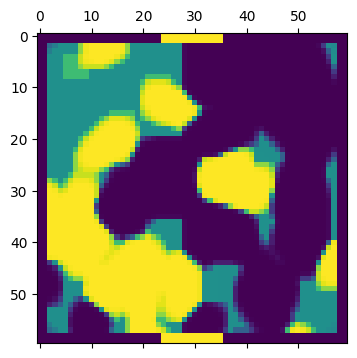

In [ ]:
plt.matshow(np.reshape(es[2],(60,60)))

In [ ]:
es=es[5:]
y_l=y_l[5:]

In [ ]:
y_ll=y_l
y_l=np.append(y_l,y_ll)
y_l,np.shape(y_l)

(array([ 7670364.1354,  3397811.9966,  6636088.9679,  12128592.8504,
         16166422.3150,  14520007.6049,  13905423.2855,  16714566.1635,
         16632364.7472,  10343780.9025,  14522595.4806,  12846039.7193,
         14810531.1240,  15434215.4116,  15797202.9617,  17350412.5073,
         15254440.3263,  16905814.4406,  19500369.1338,  16546249.0869,
         19536903.5506,  16724813.9572,  16987651.0236,  18771148.9359,
         17620763.4836,  19668628.4379,  14652298.2290,  18753284.6274,
         17813426.7505,  20404286.7710,  17129580.7787,  19139921.8093,
         19206607.7657,  16133087.1116,  14854247.9673,  19972779.0101,
         18473004.8295,  21238876.8001,  20006422.6767,  18994695.2795,
         20535368.9862,  19921908.5754,  20311276.9281,  20460880.5162,
         21262666.3541,  20645929.8242,  20073965.3079,  21455216.0037,
         21292555.2128,  21239678.8446,  21438140.5754,  20221894.9359,
         21863843.2769,  21484886.1228,  21118791.3133,  21395525.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


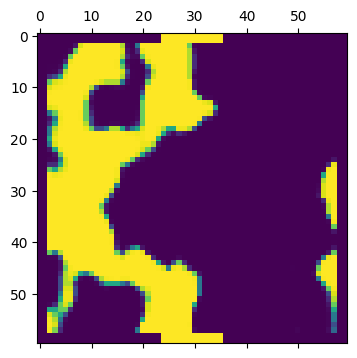

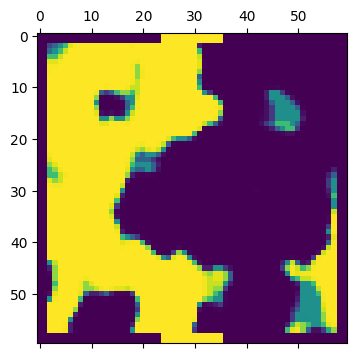

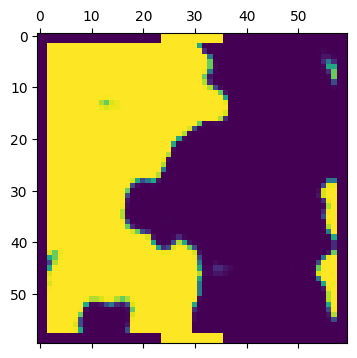

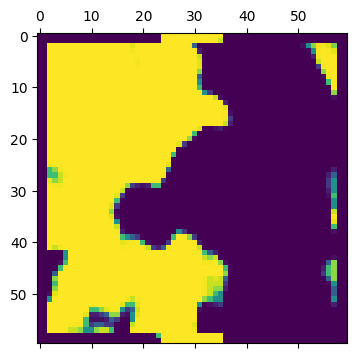

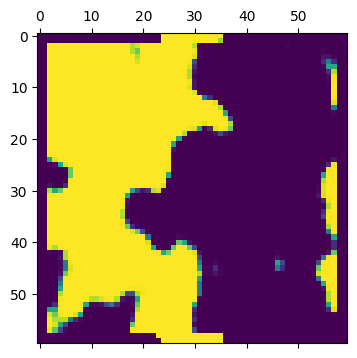

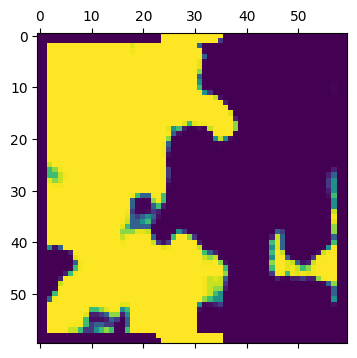

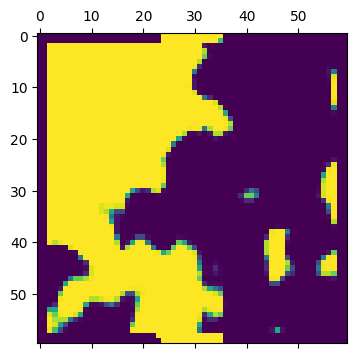

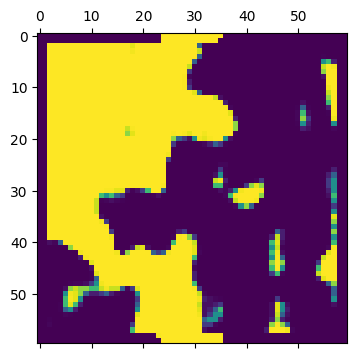

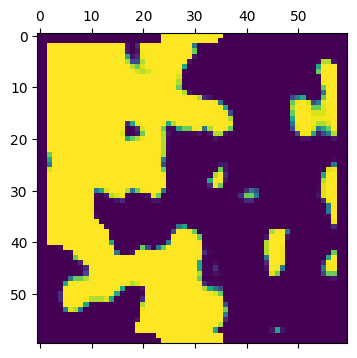

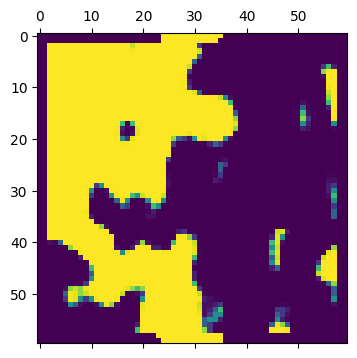

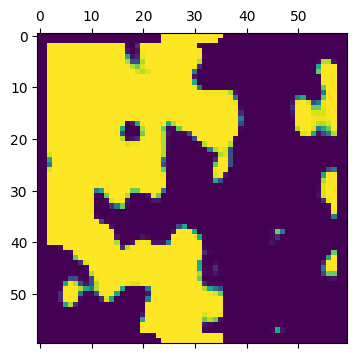

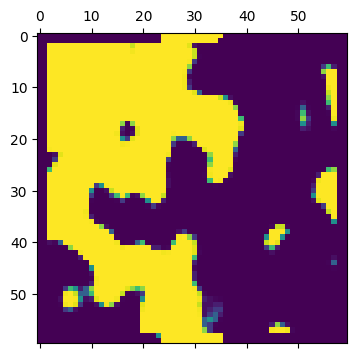

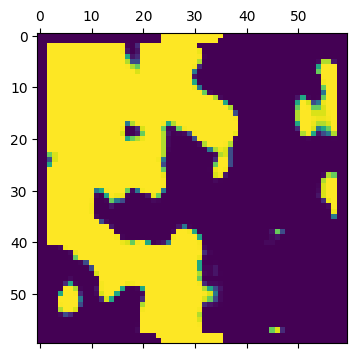

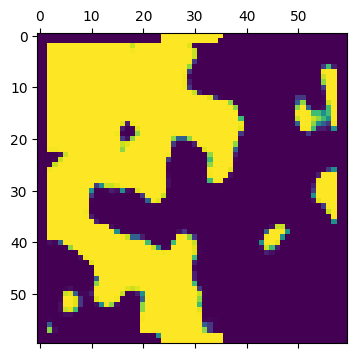

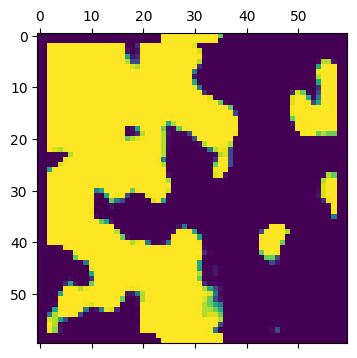

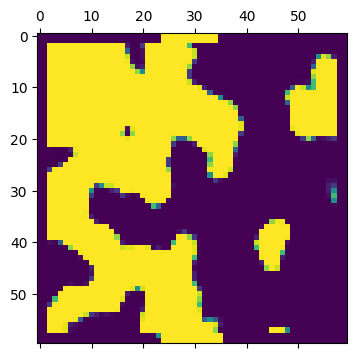

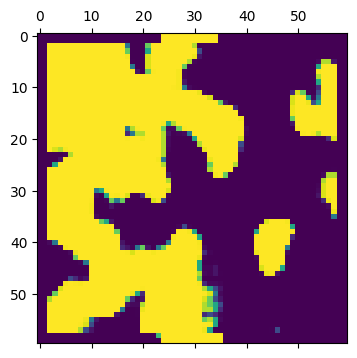

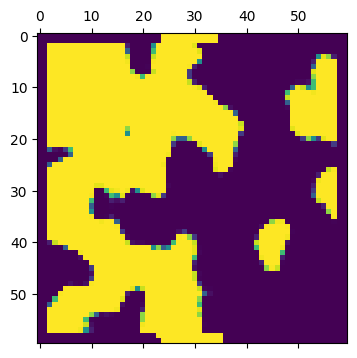

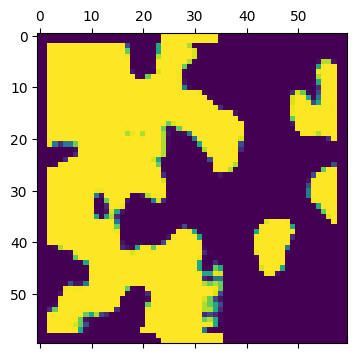

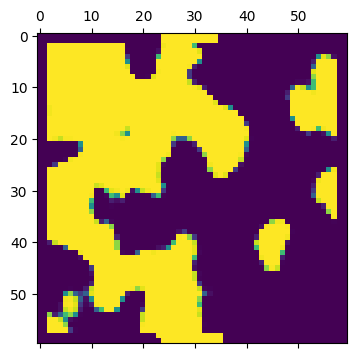

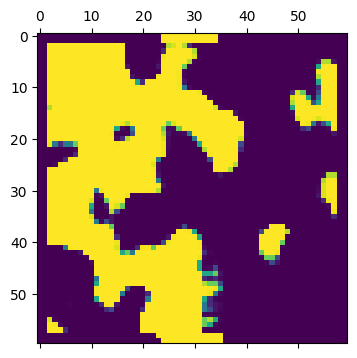

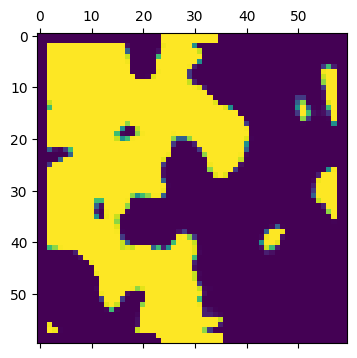

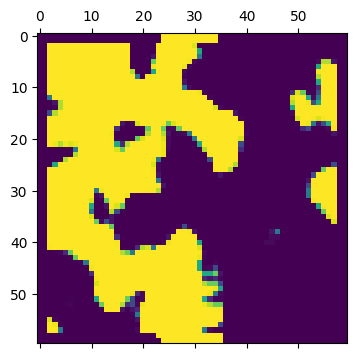

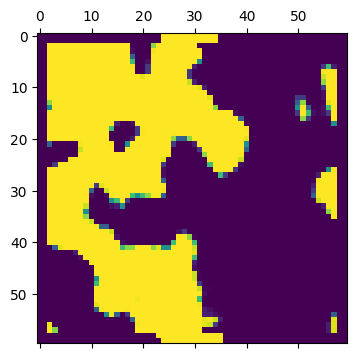

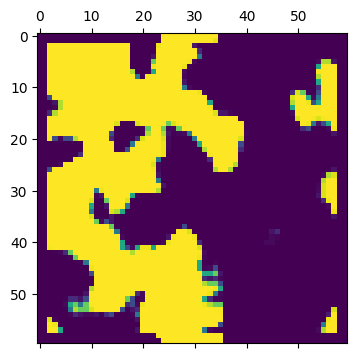

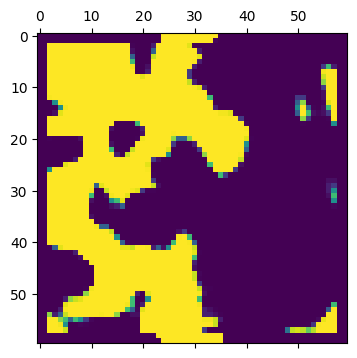

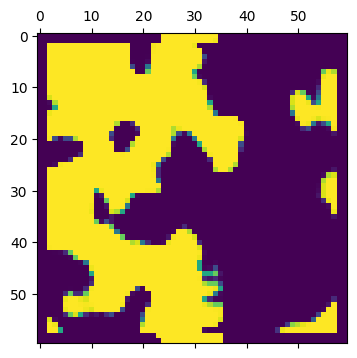

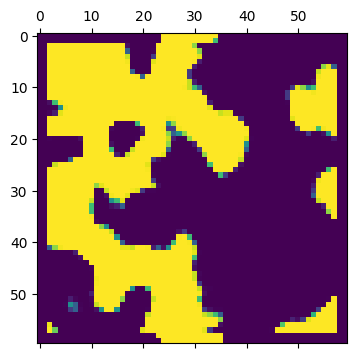

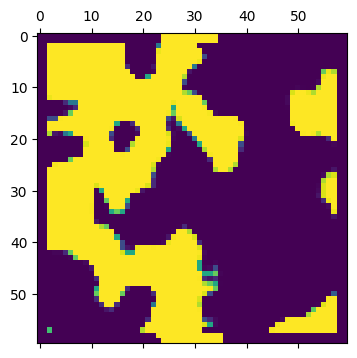

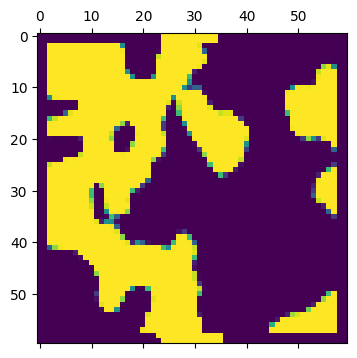

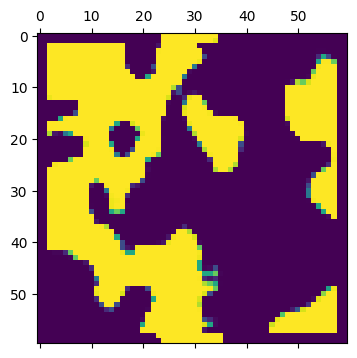

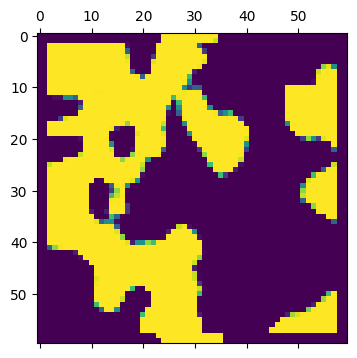

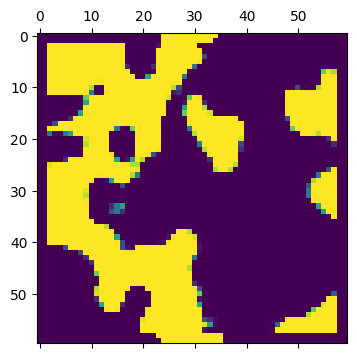

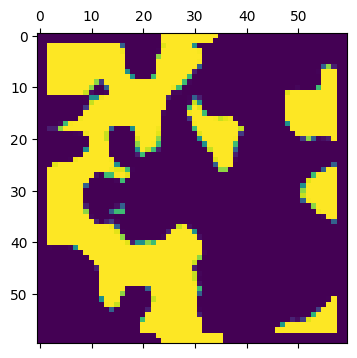

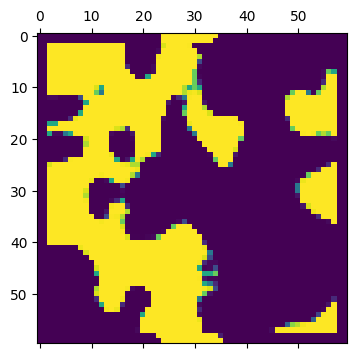

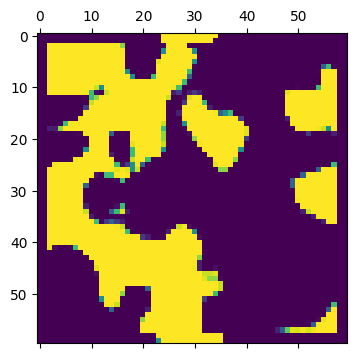

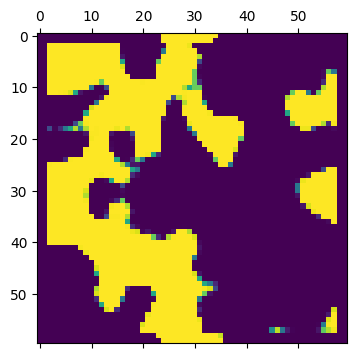

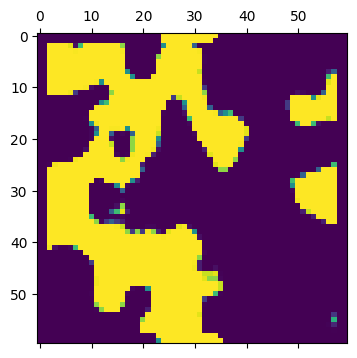

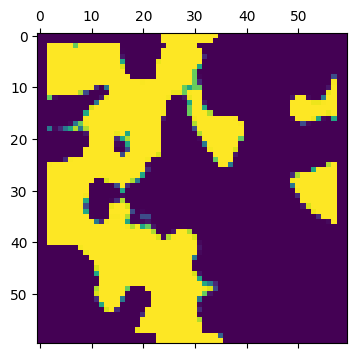

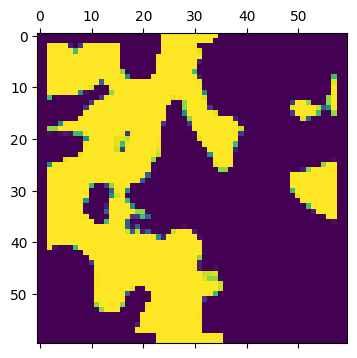

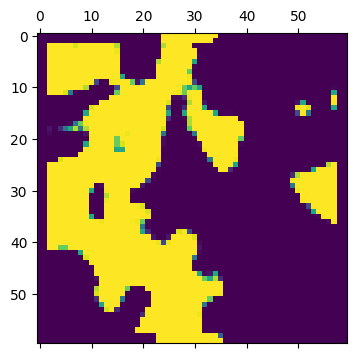

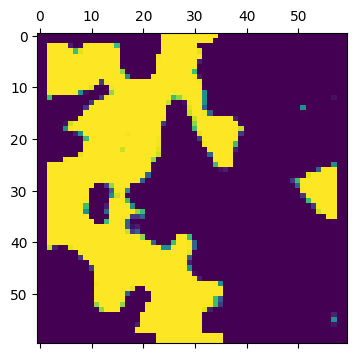

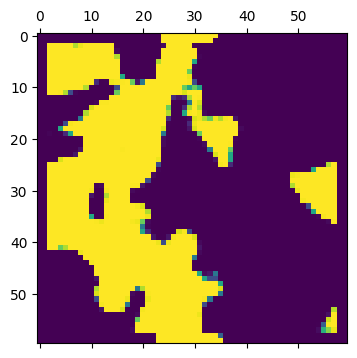

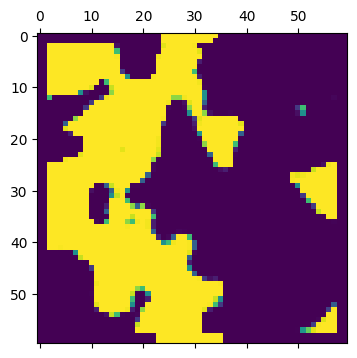

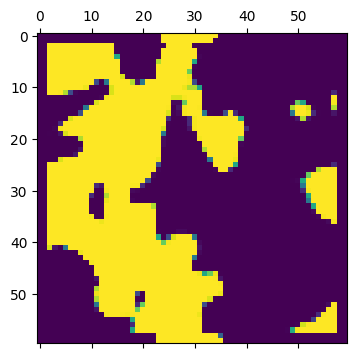

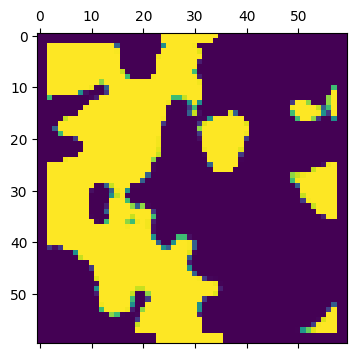

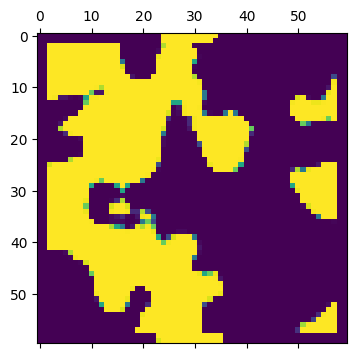

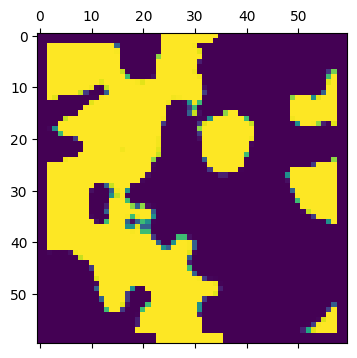

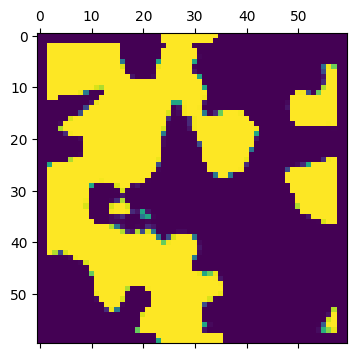

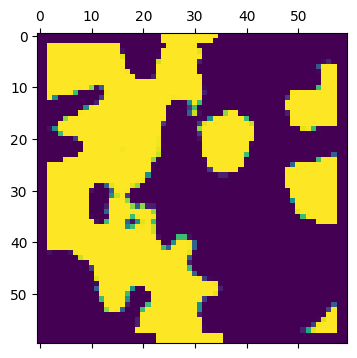

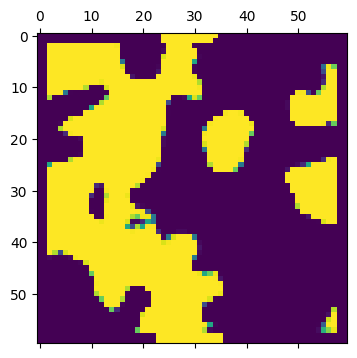

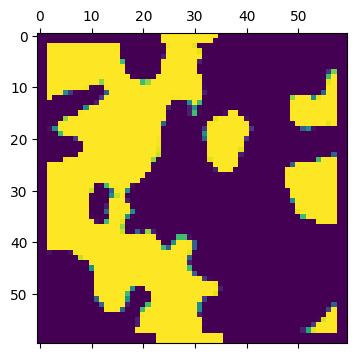

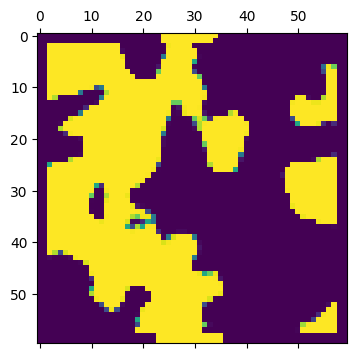

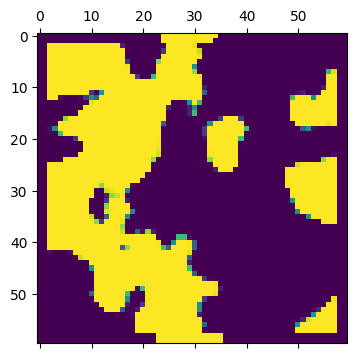

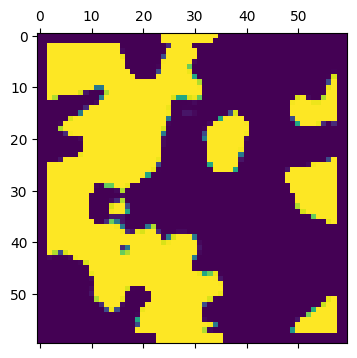

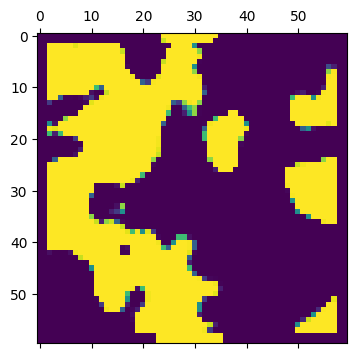

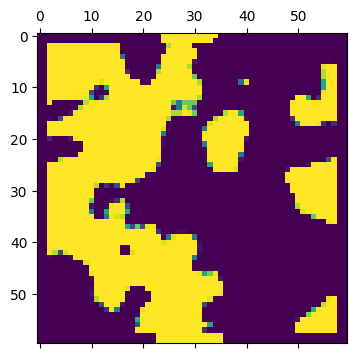

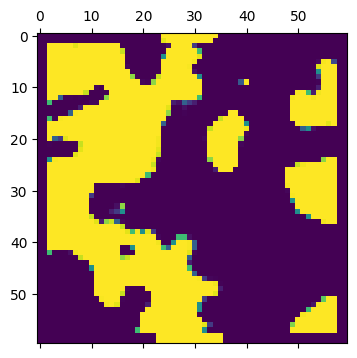

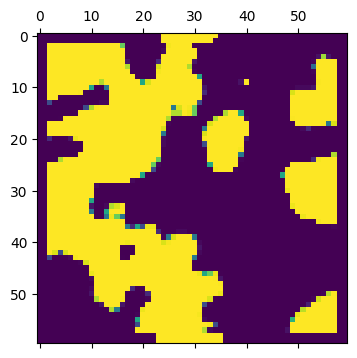

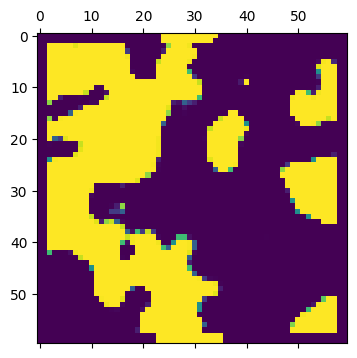

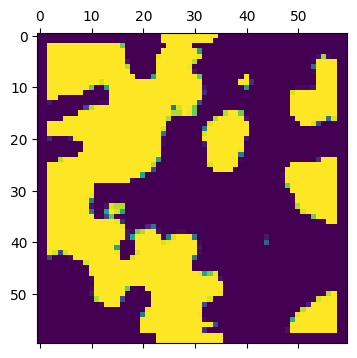

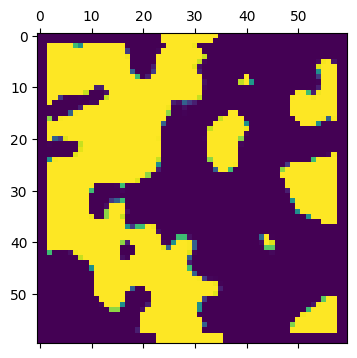

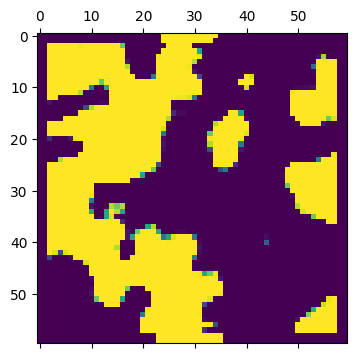

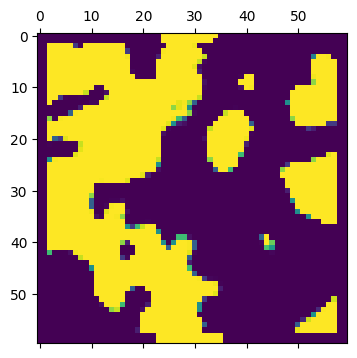

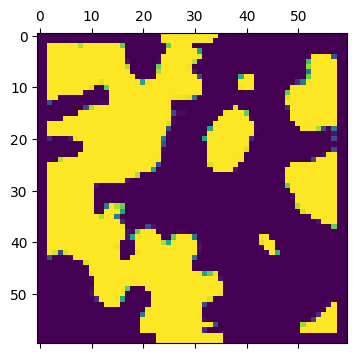

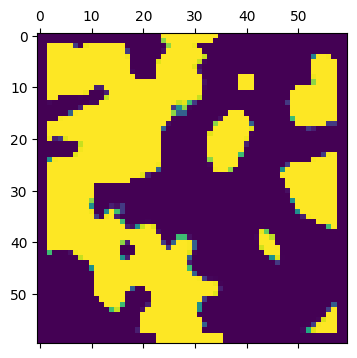

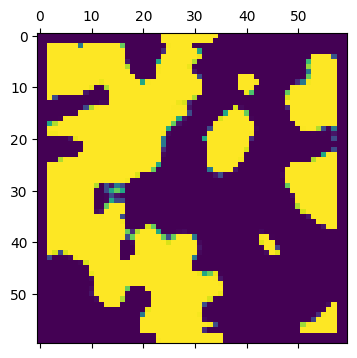

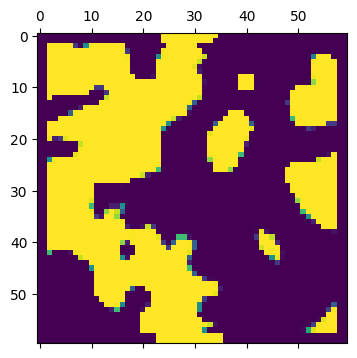

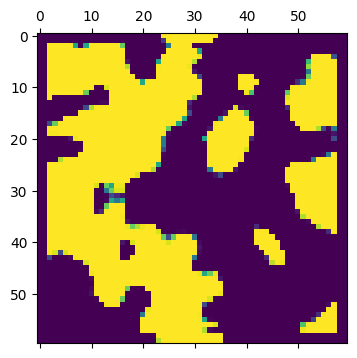

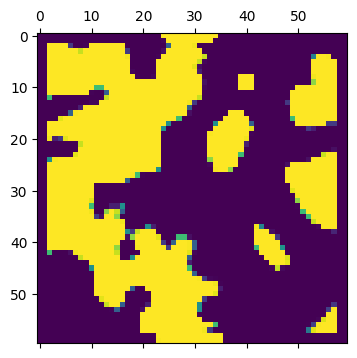

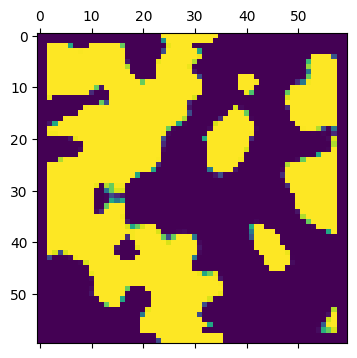

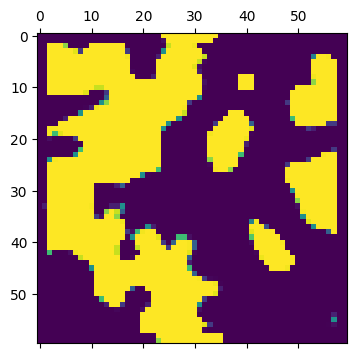

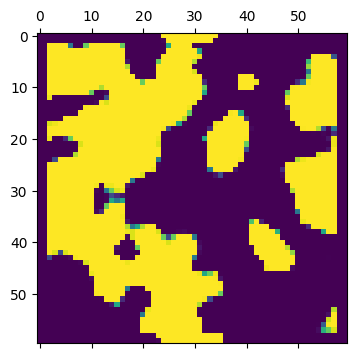

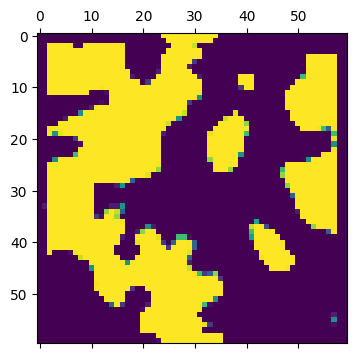

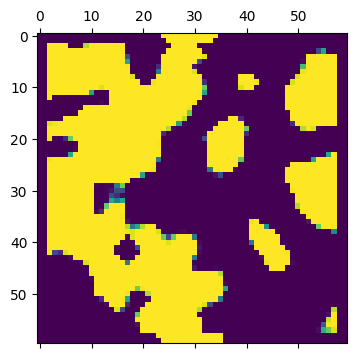

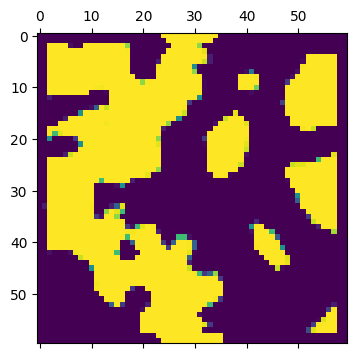

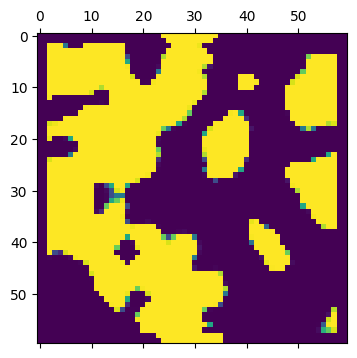

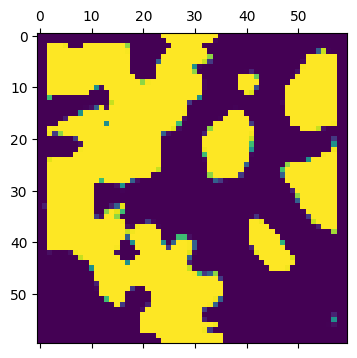

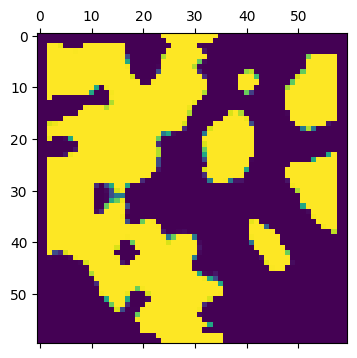

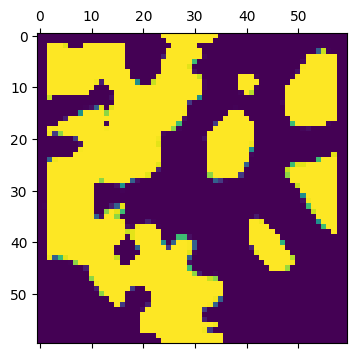

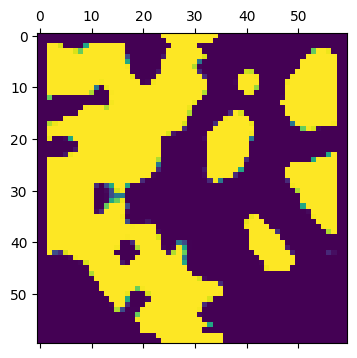

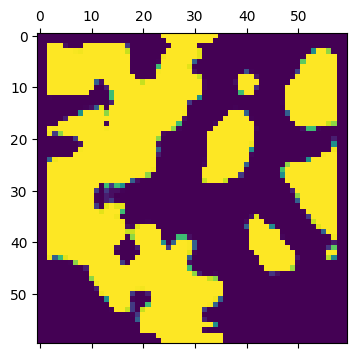

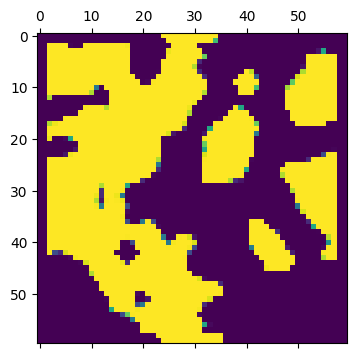

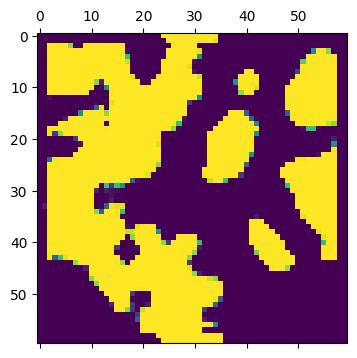

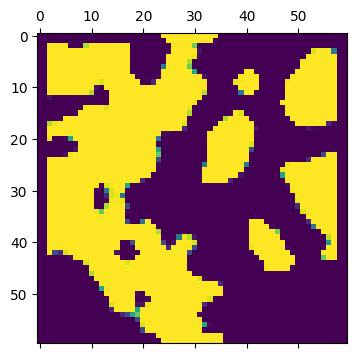

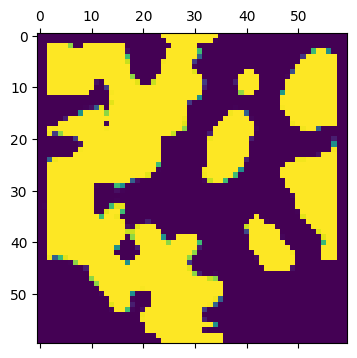

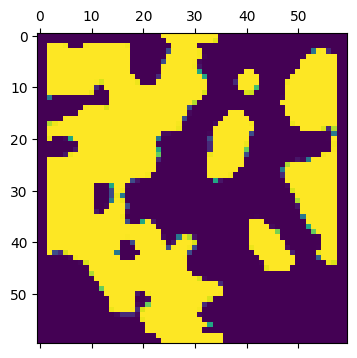

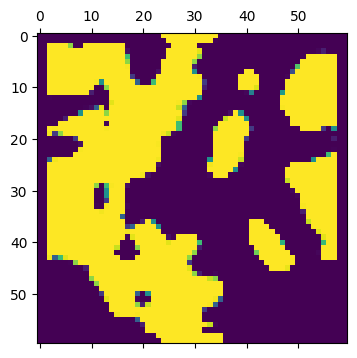

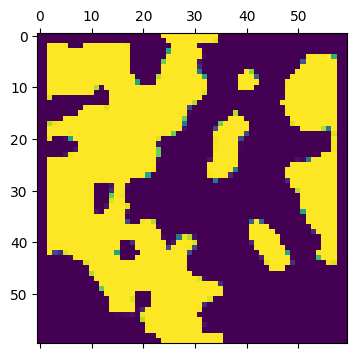

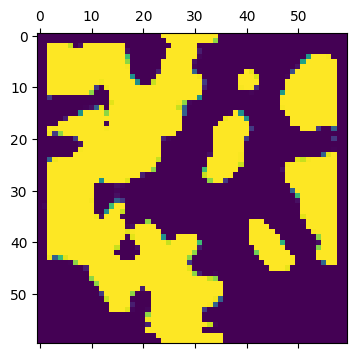

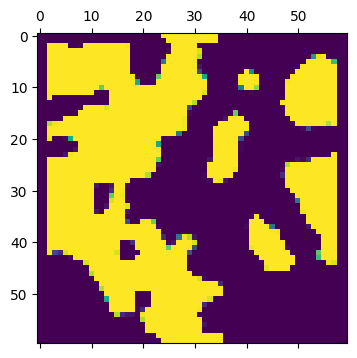

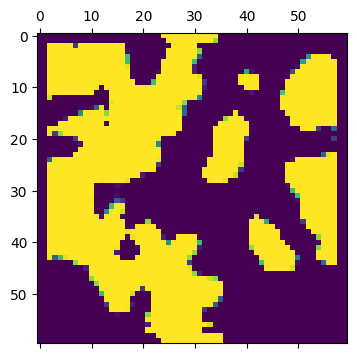

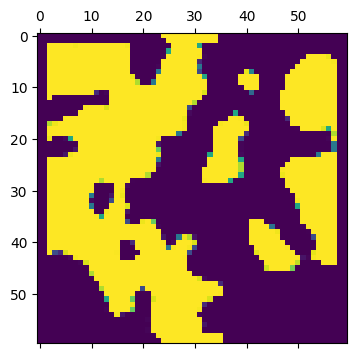

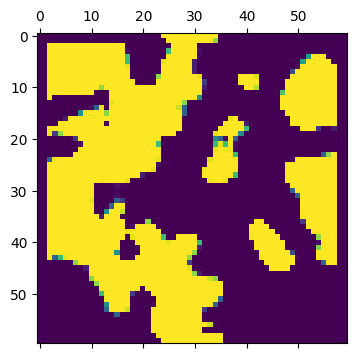

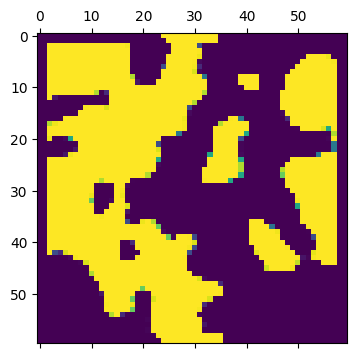

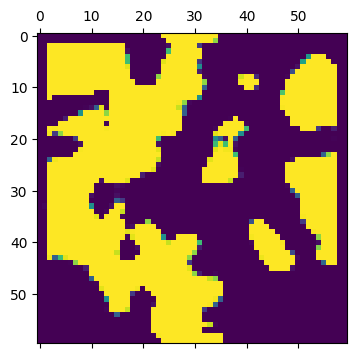

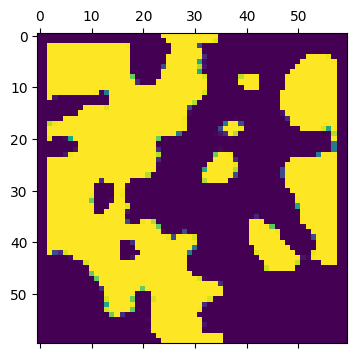

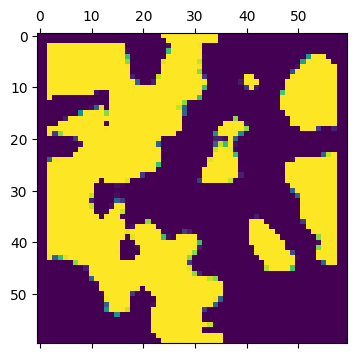

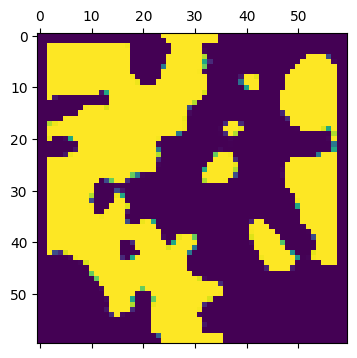

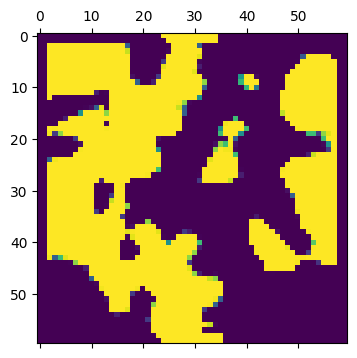

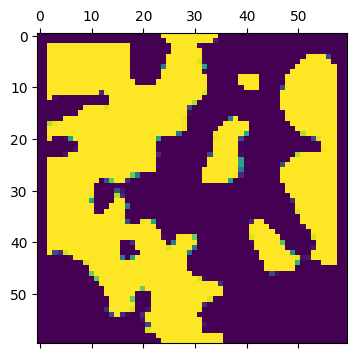

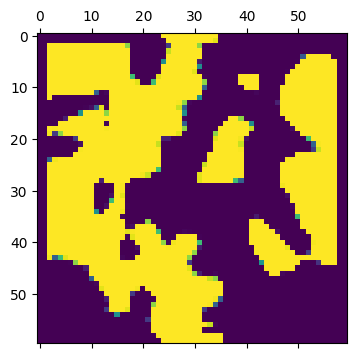

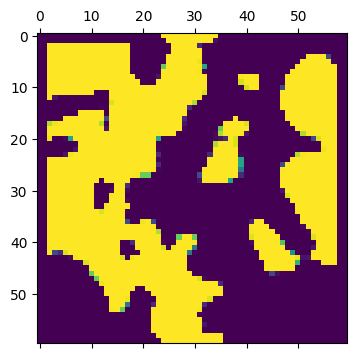

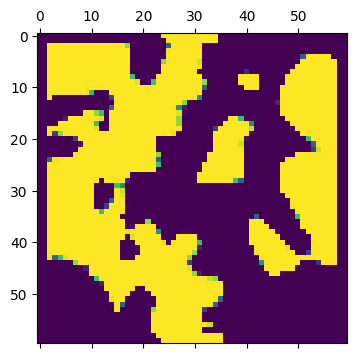

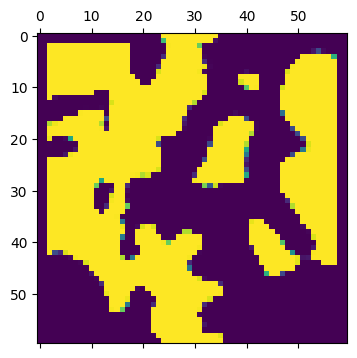

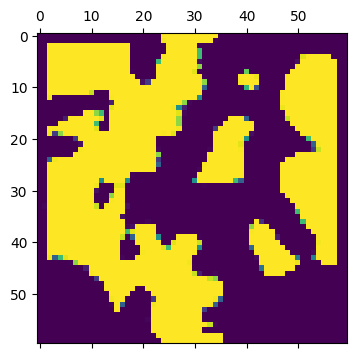

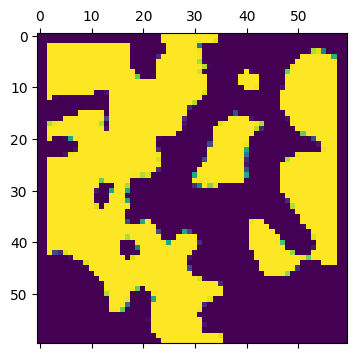

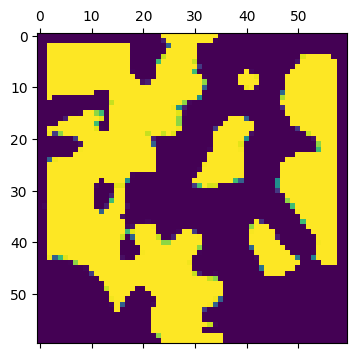

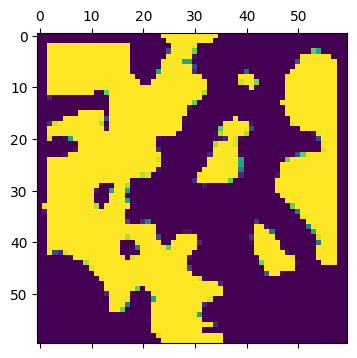

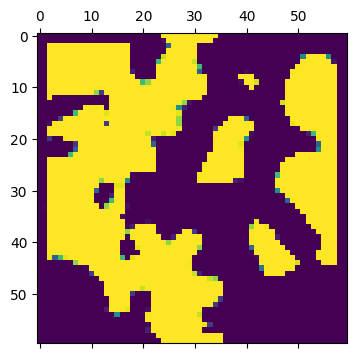

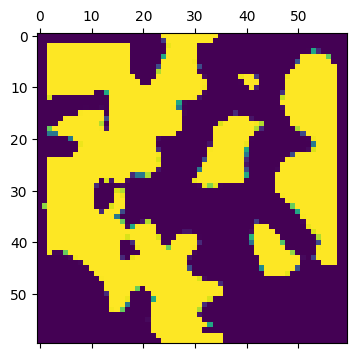

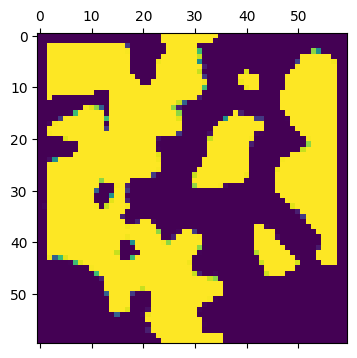

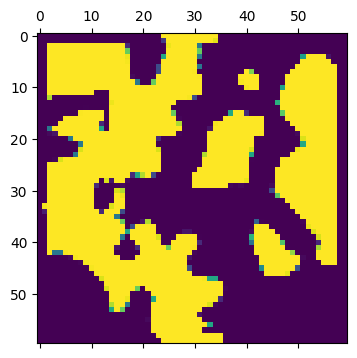

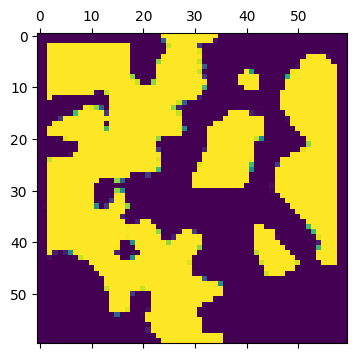

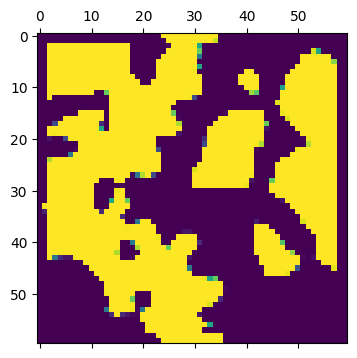

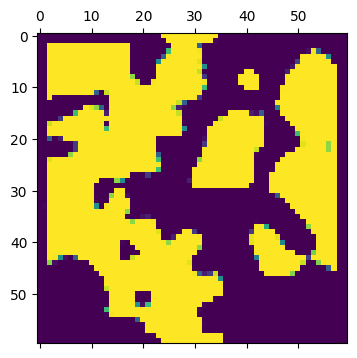

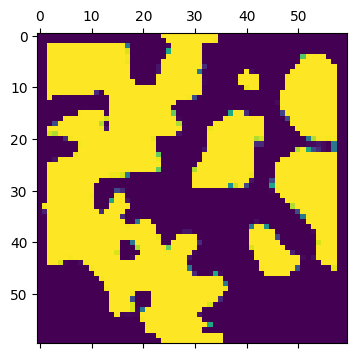

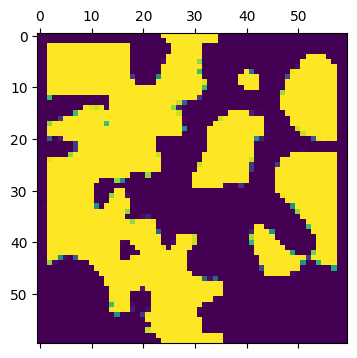

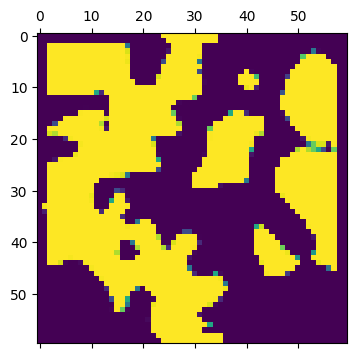

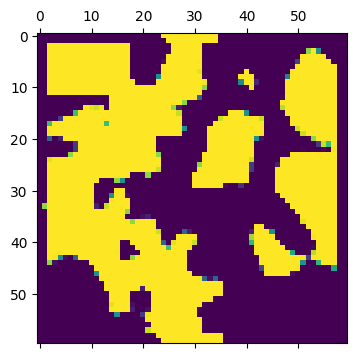

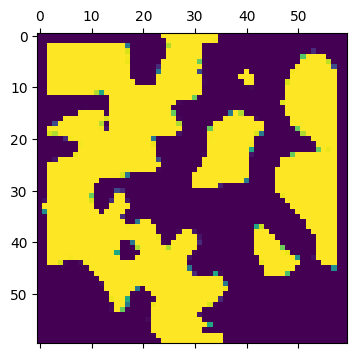

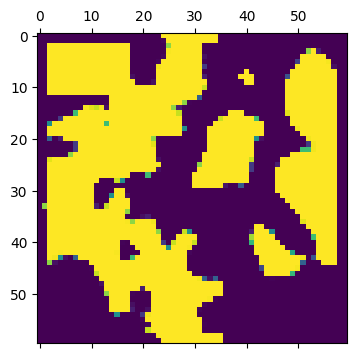

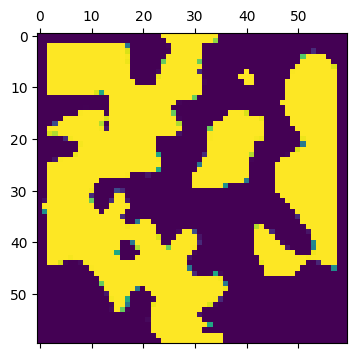

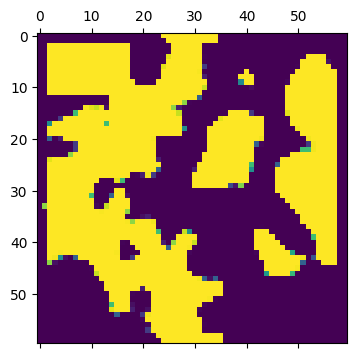

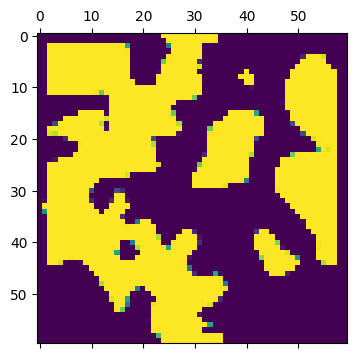

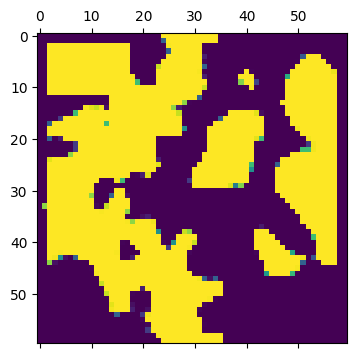

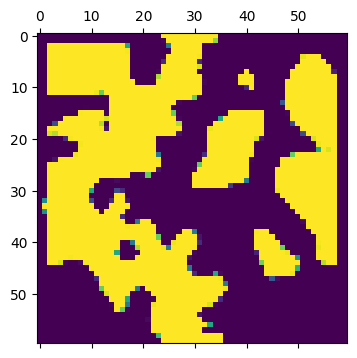

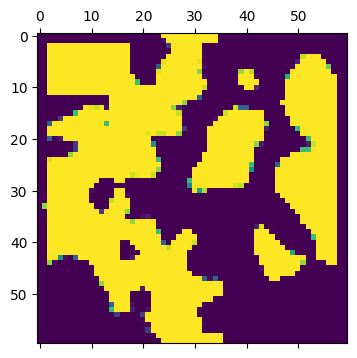

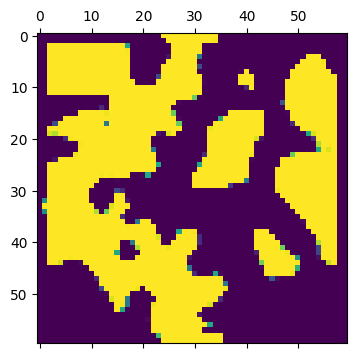

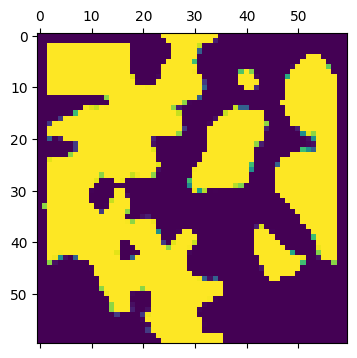

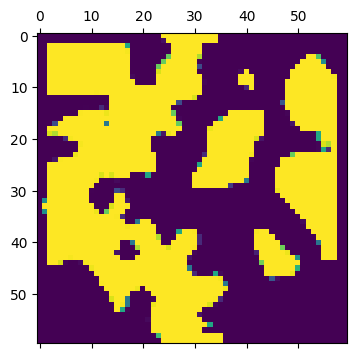

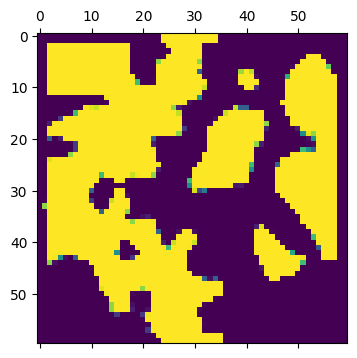

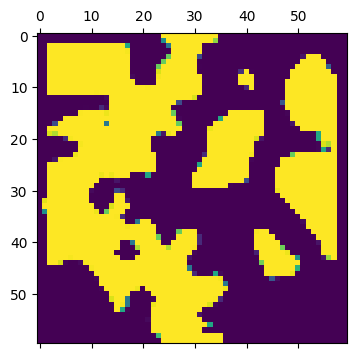

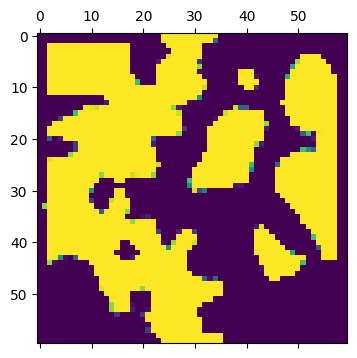

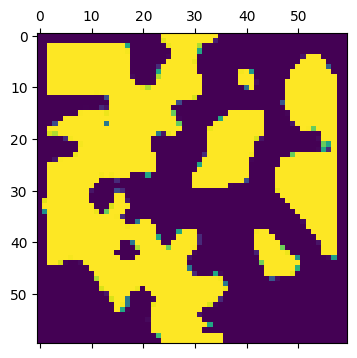

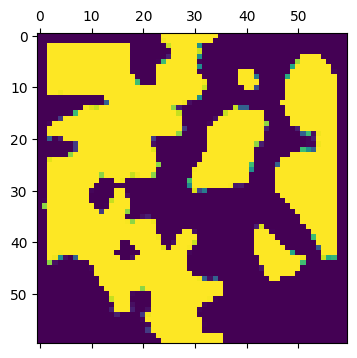

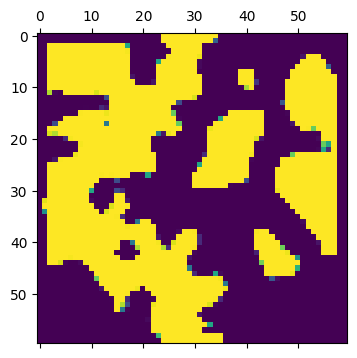

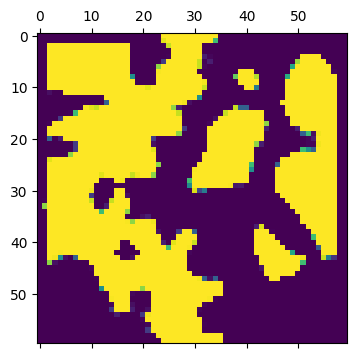

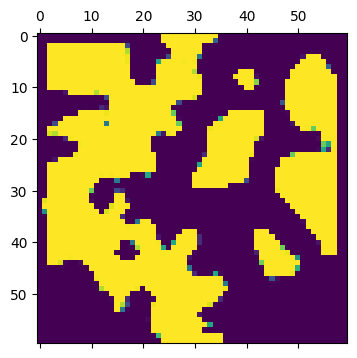

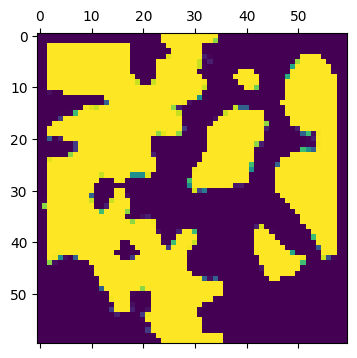

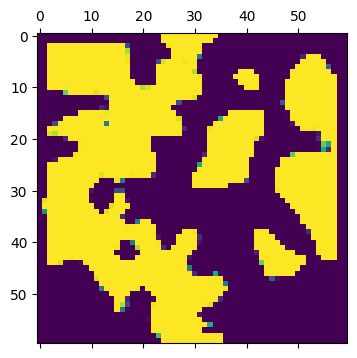

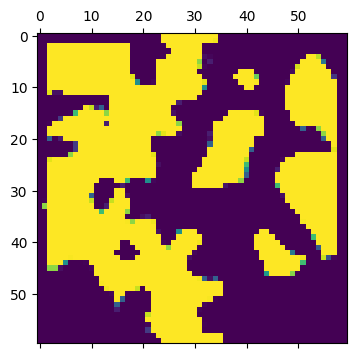

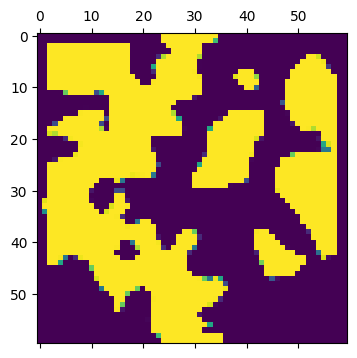

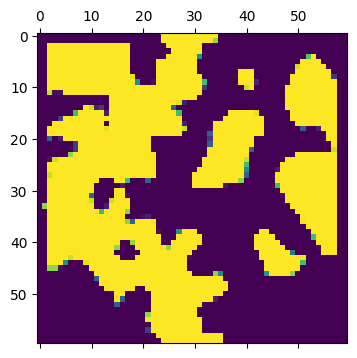

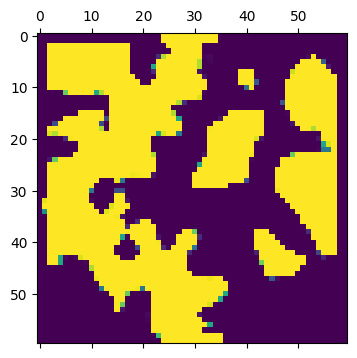

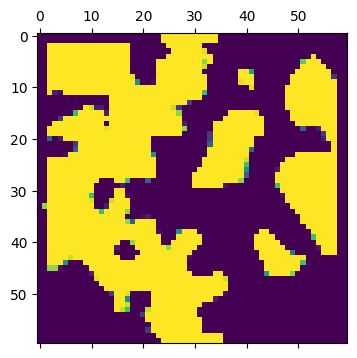

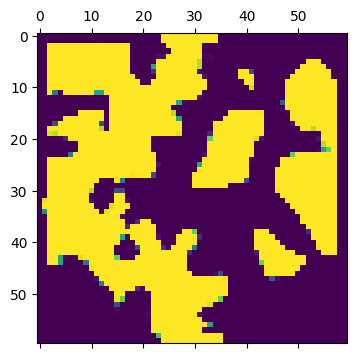

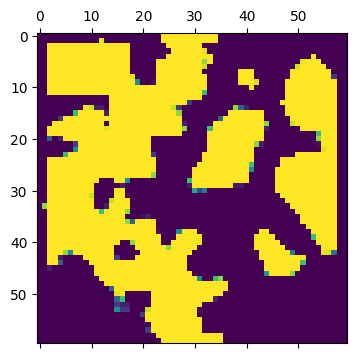

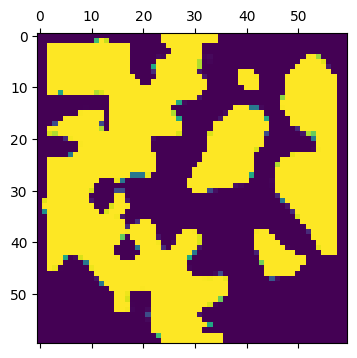

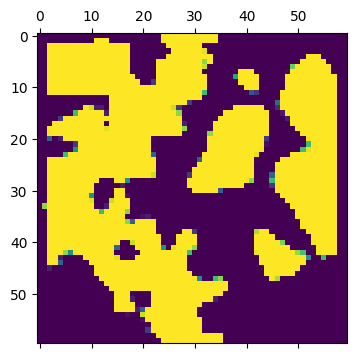

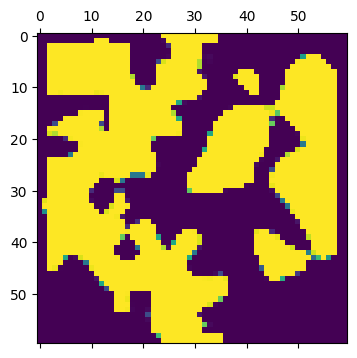

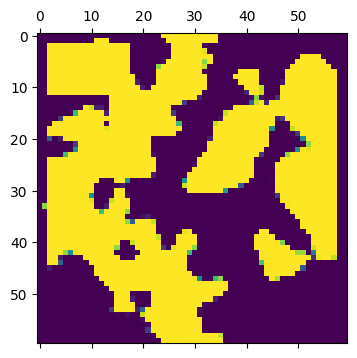

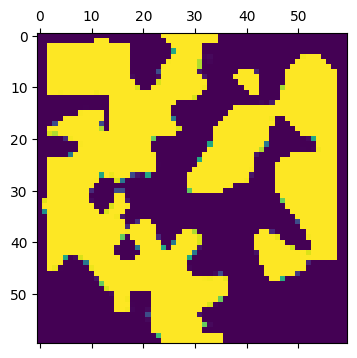

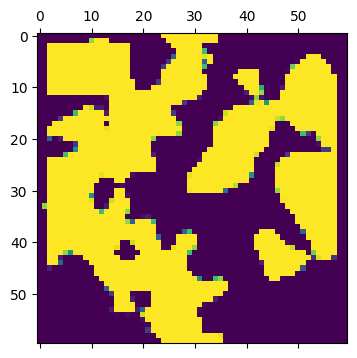

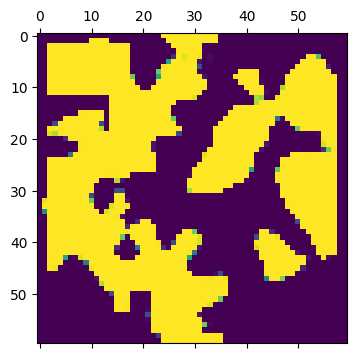

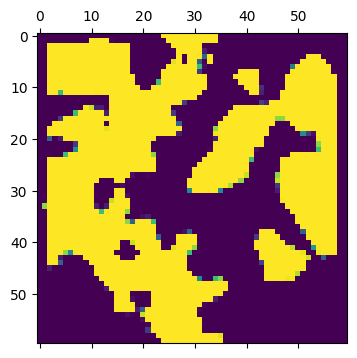

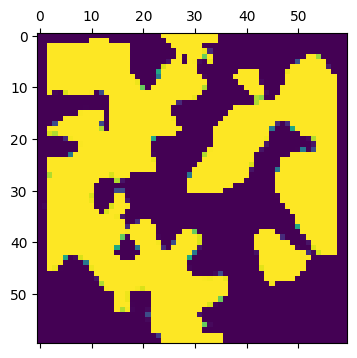

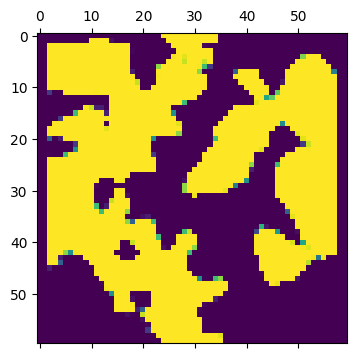

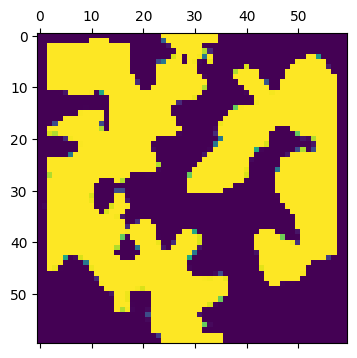

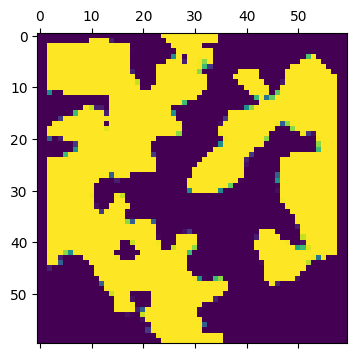

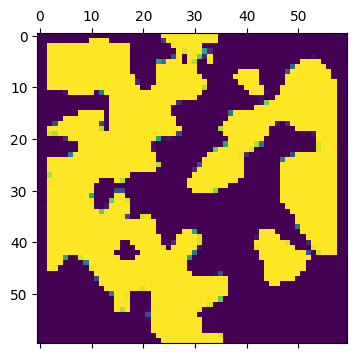

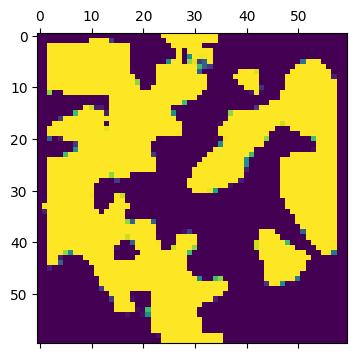

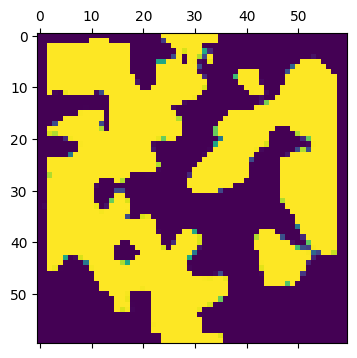

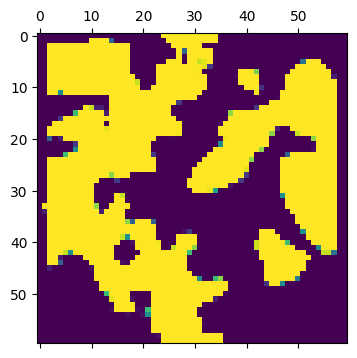

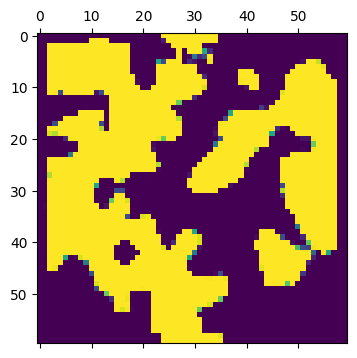

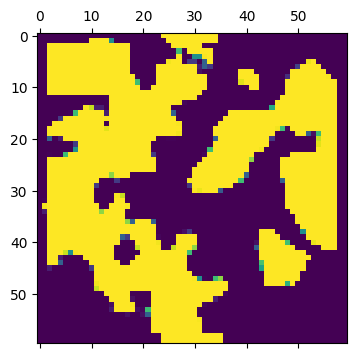

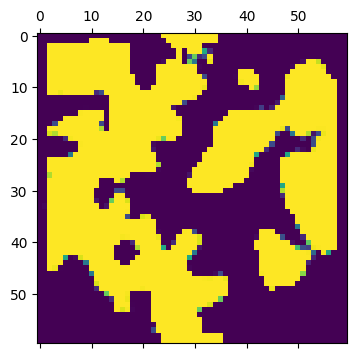

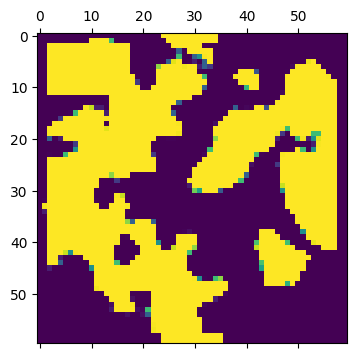

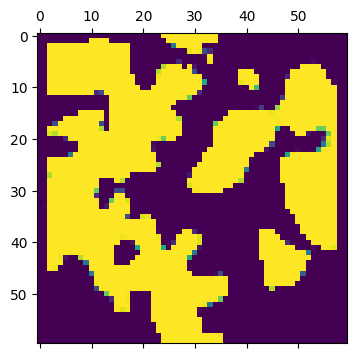

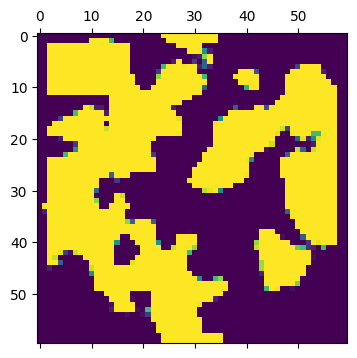

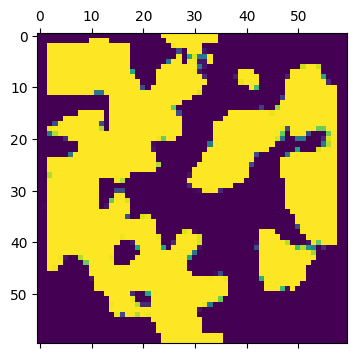

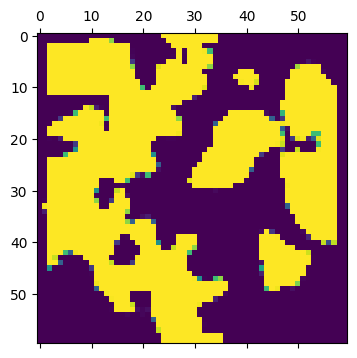

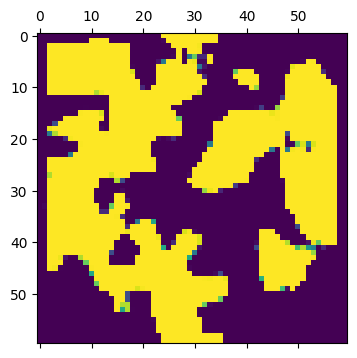

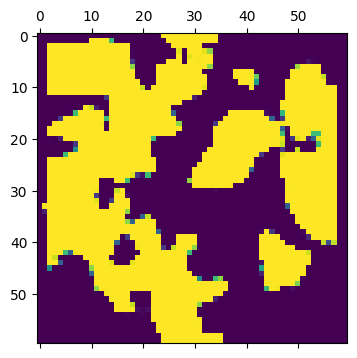

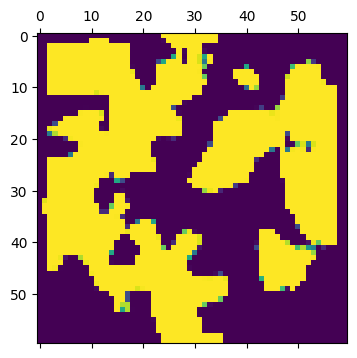

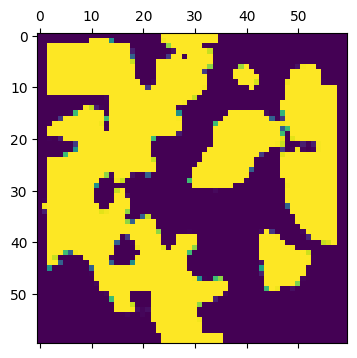

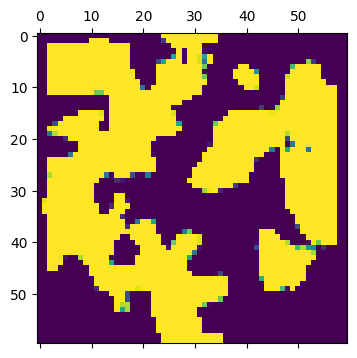

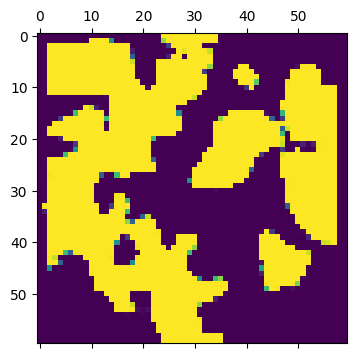

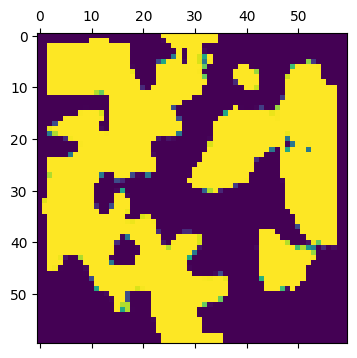

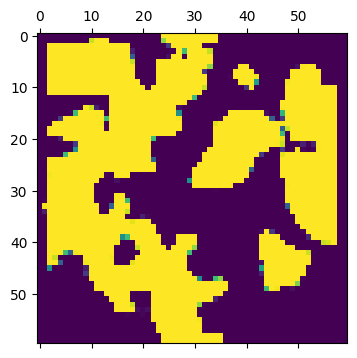

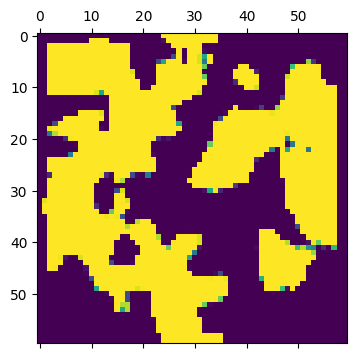

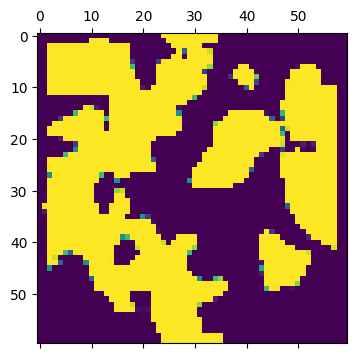

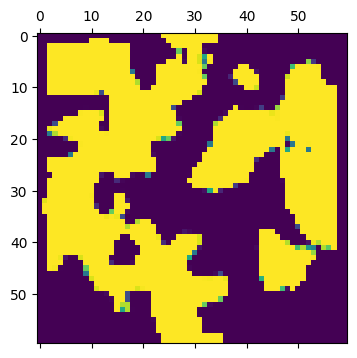

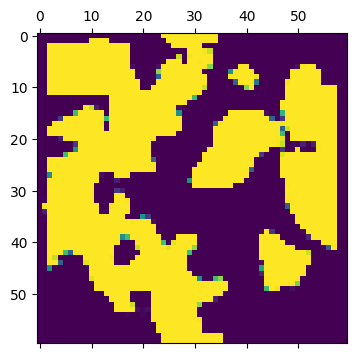

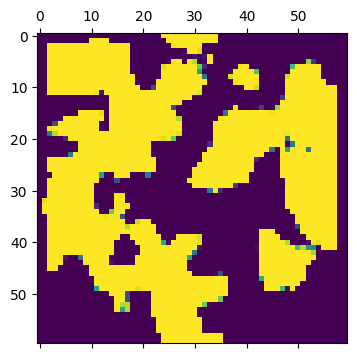

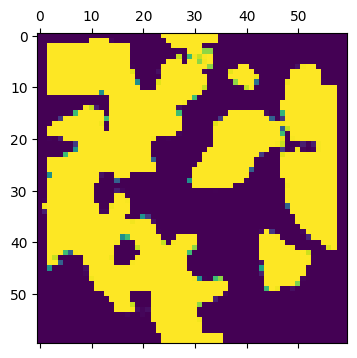

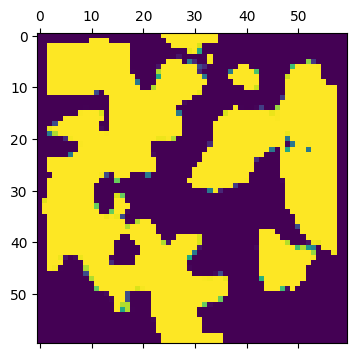

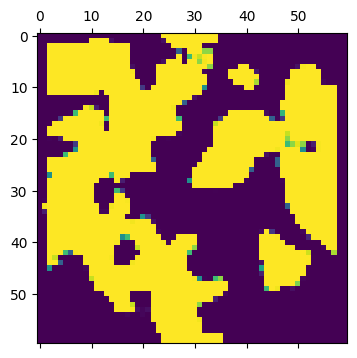

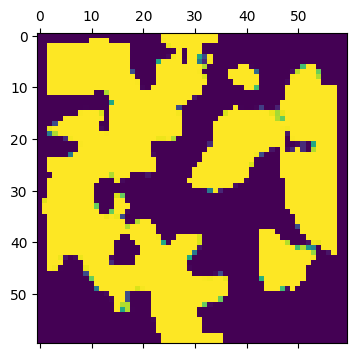

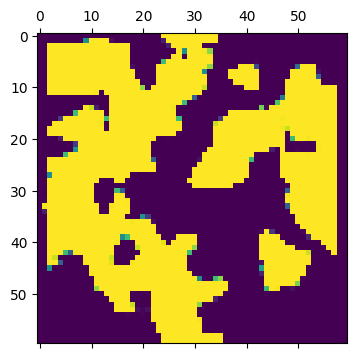

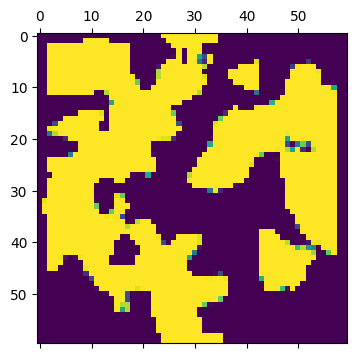

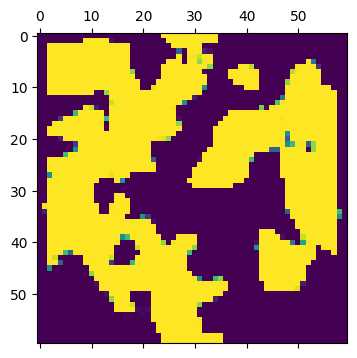

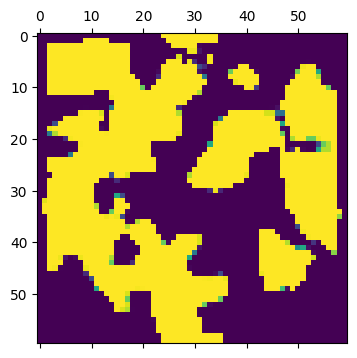

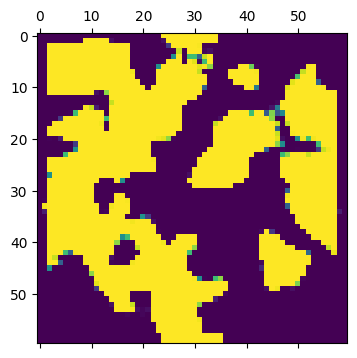

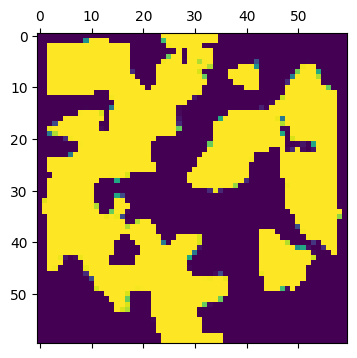

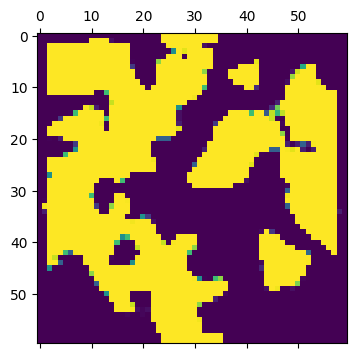

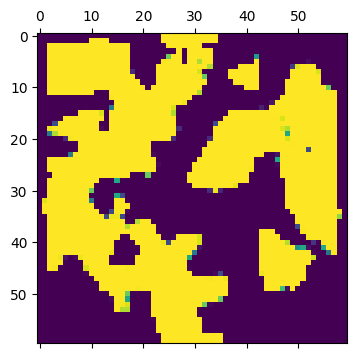

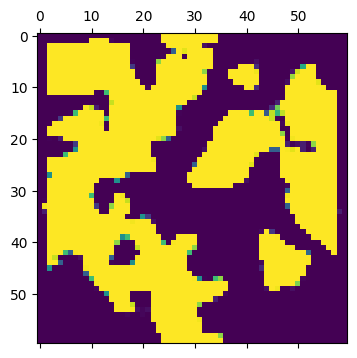

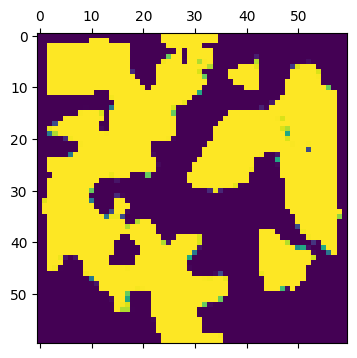

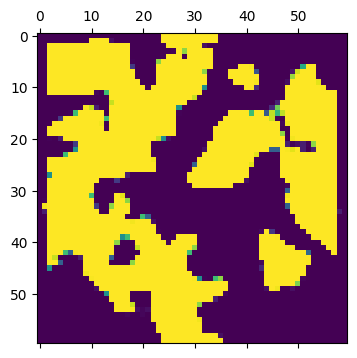

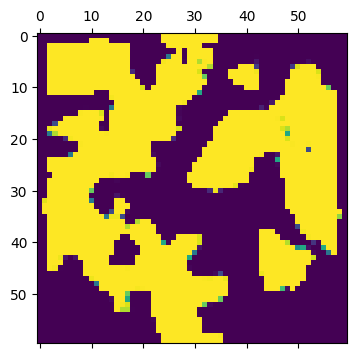

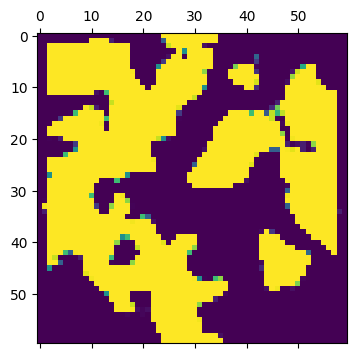

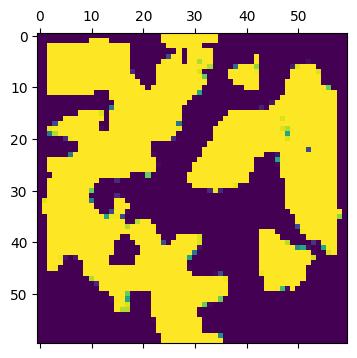

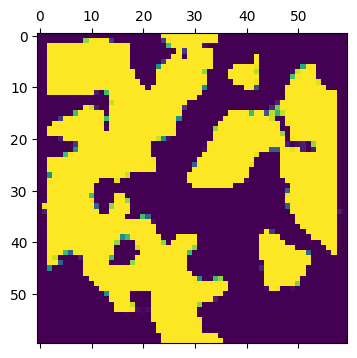

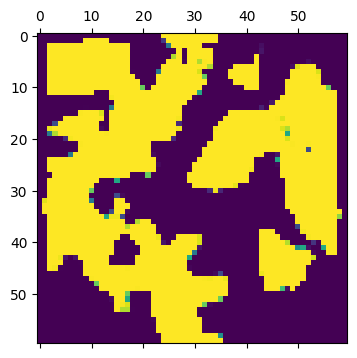

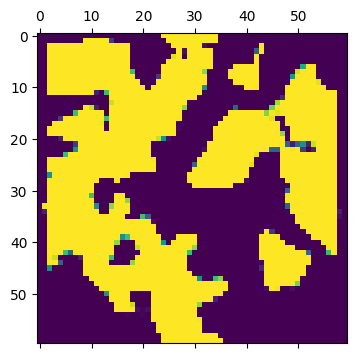

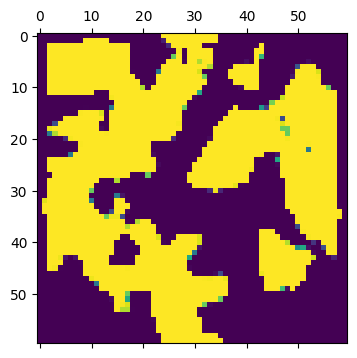

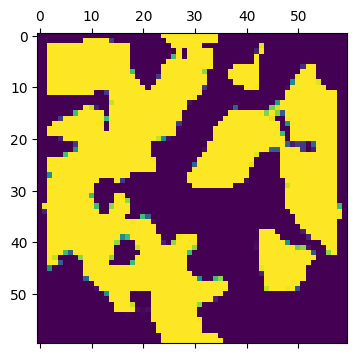

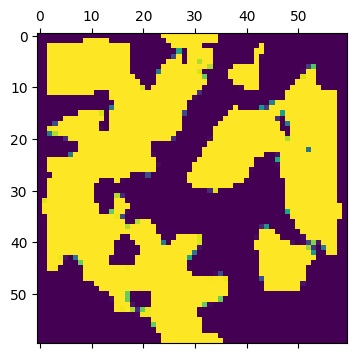

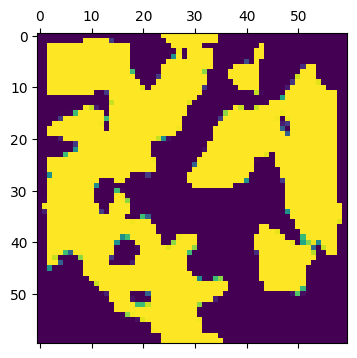

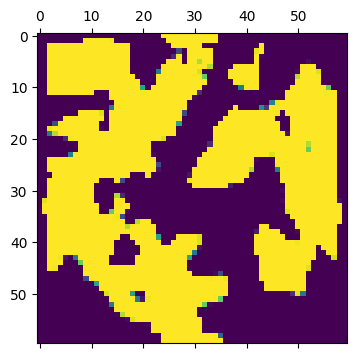

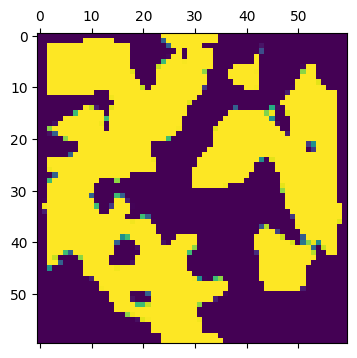

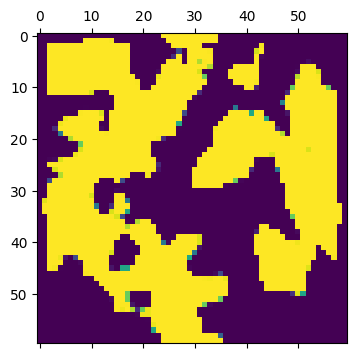

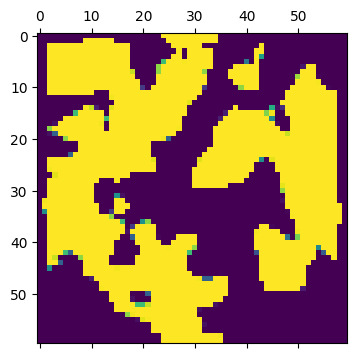

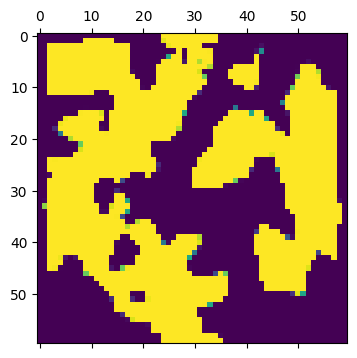

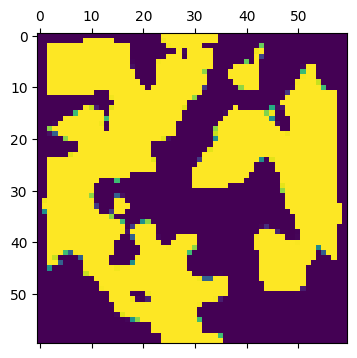

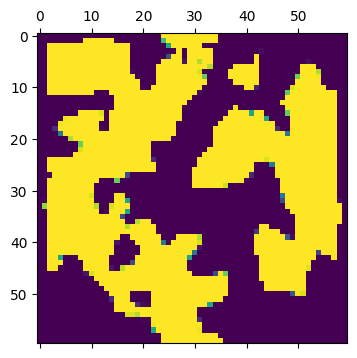

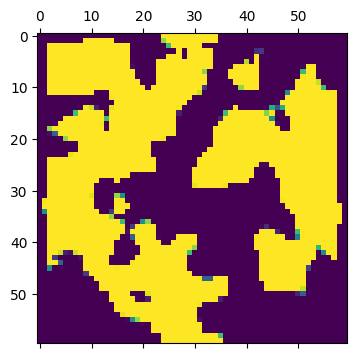

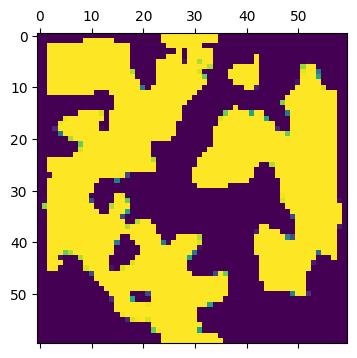

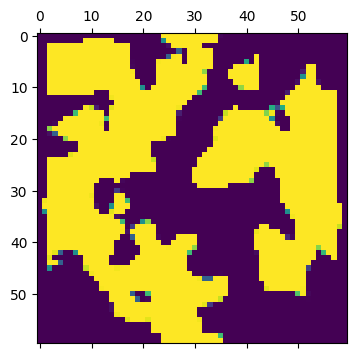

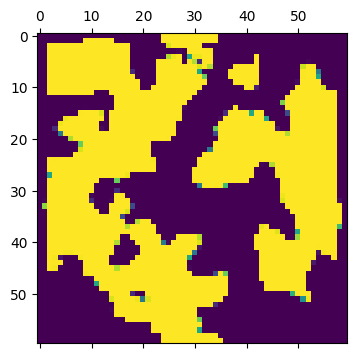

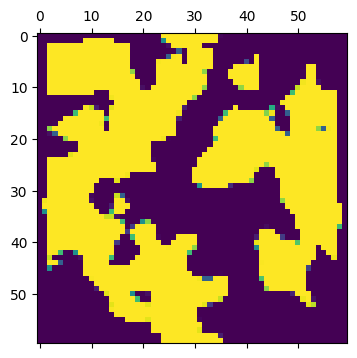

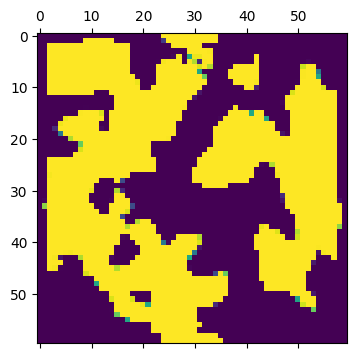

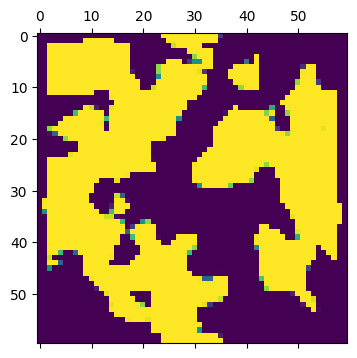

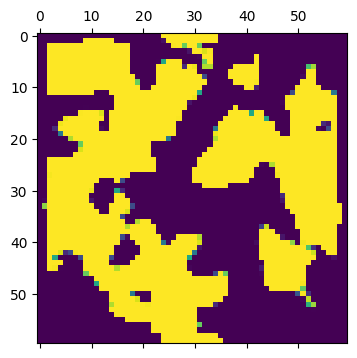

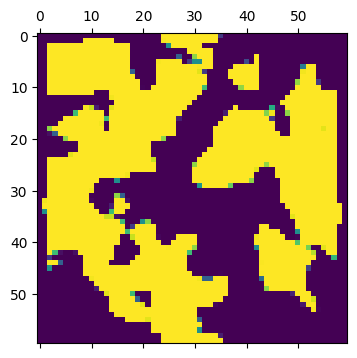

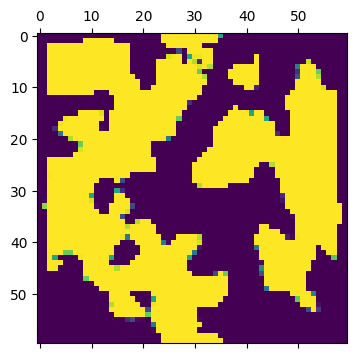

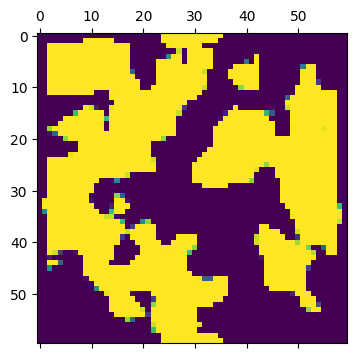

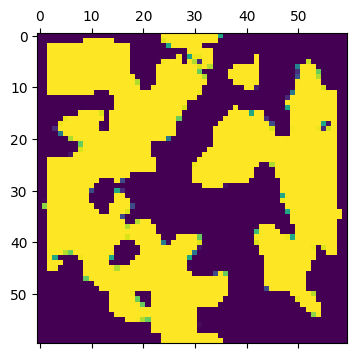

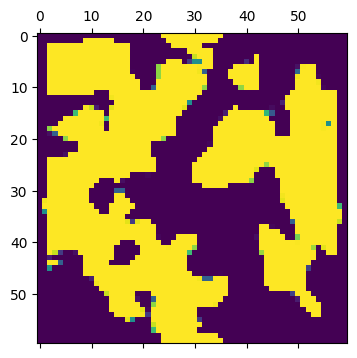

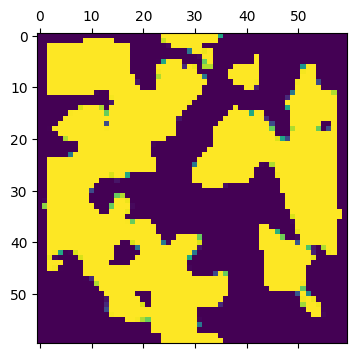

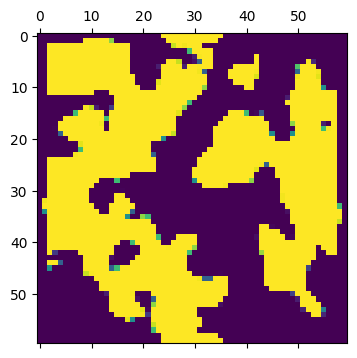

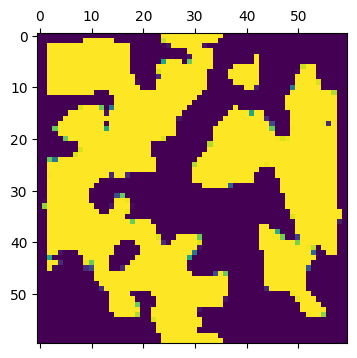

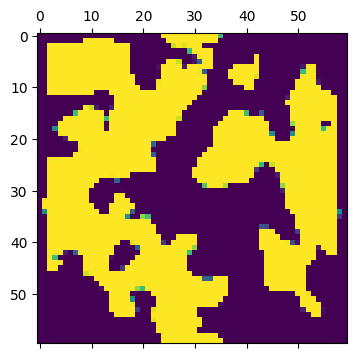

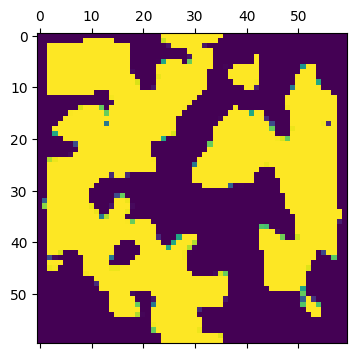

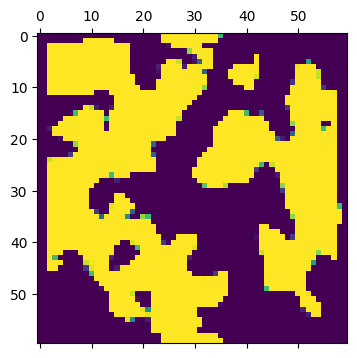

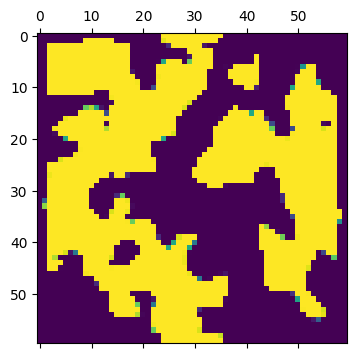

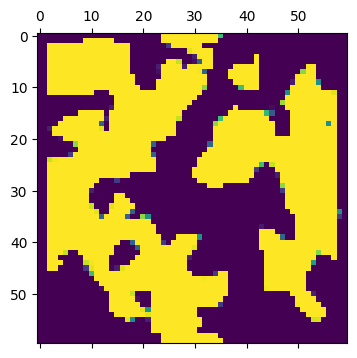

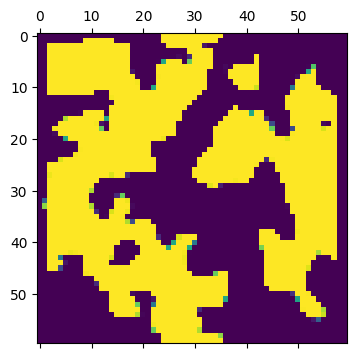

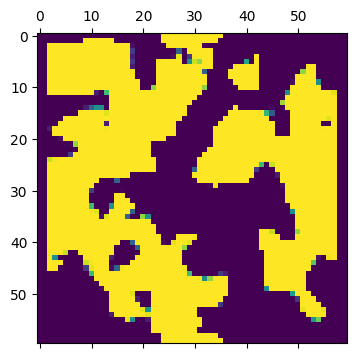

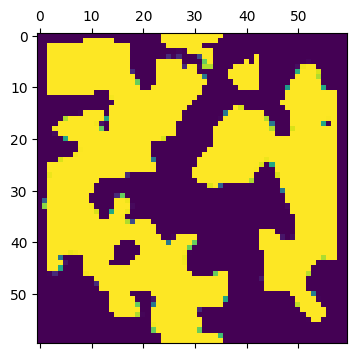

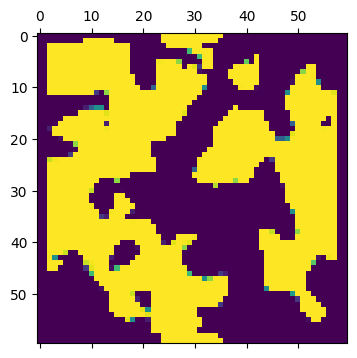

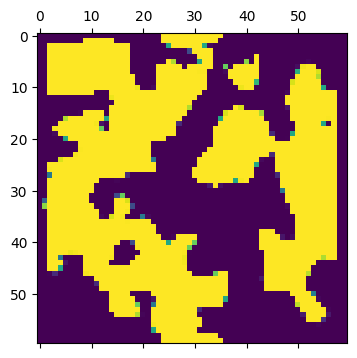

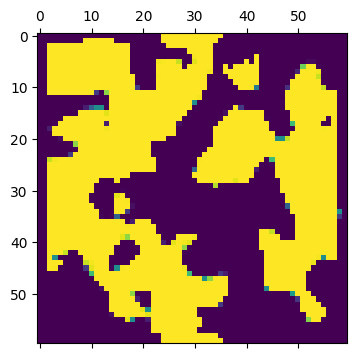

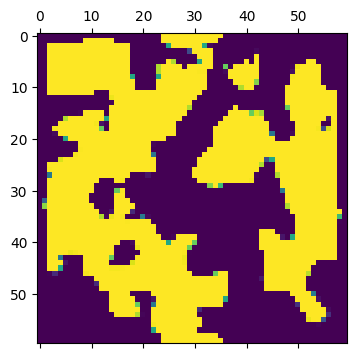

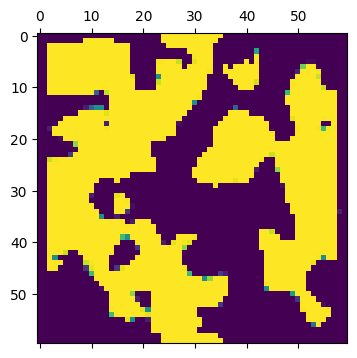

In [ ]:
for i in es:
  i=np.reshape(i,(60,60))
  plt.matshow(i)

In [ ]:
q=np.copy(es)
for i in q:
  i=np.reshape(i,(60,60))
  i=np.flip(i, axis=1)
  es=np.append(es,[np.array(i.flatten())],axis=0)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


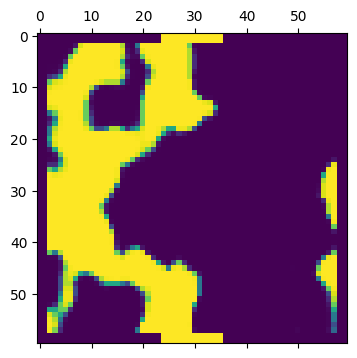

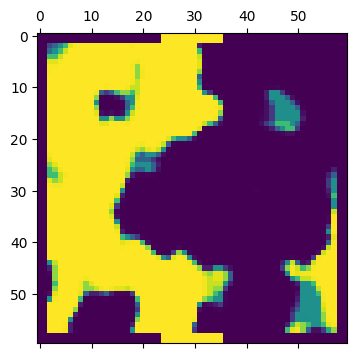

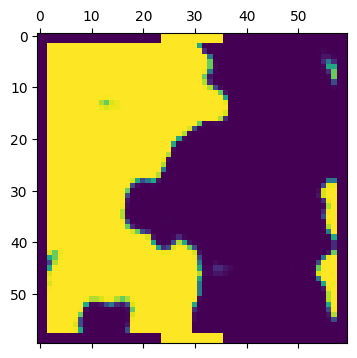

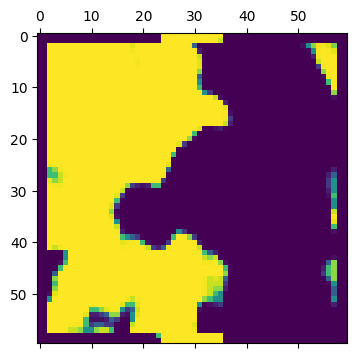

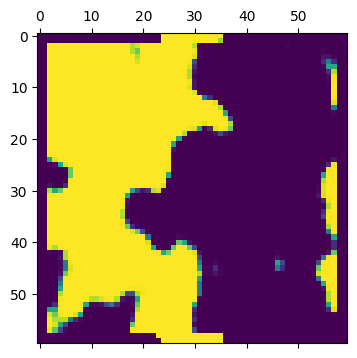

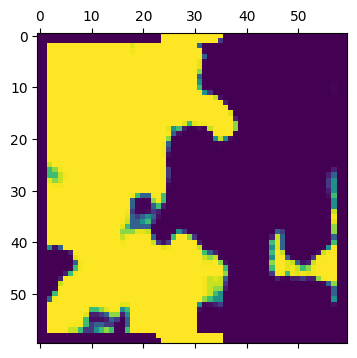

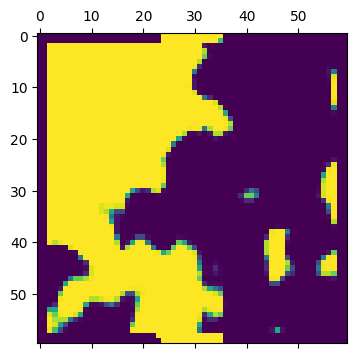

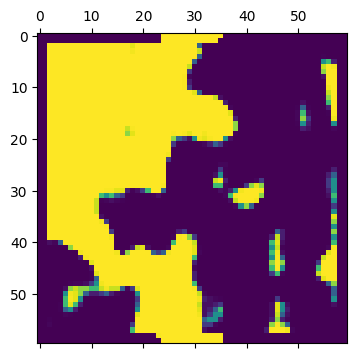

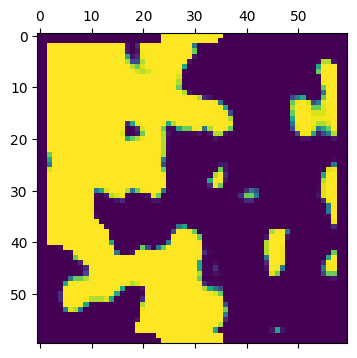

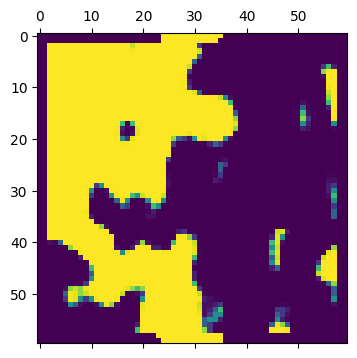

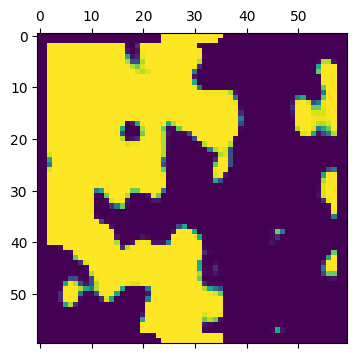

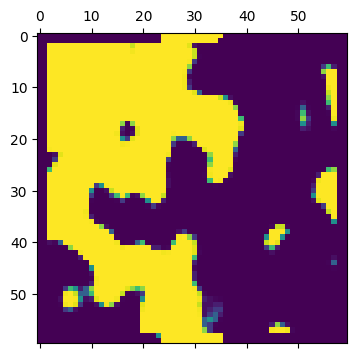

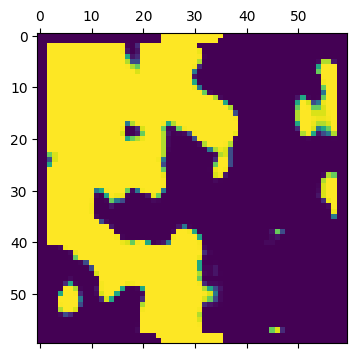

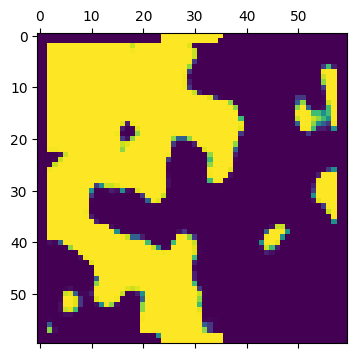

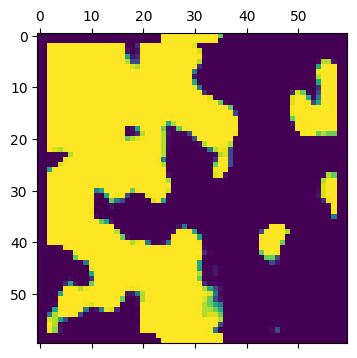

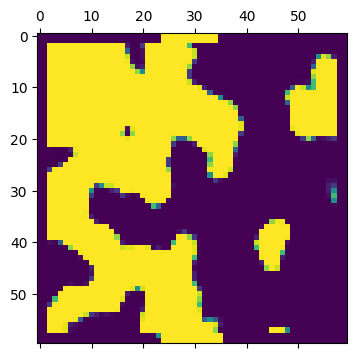

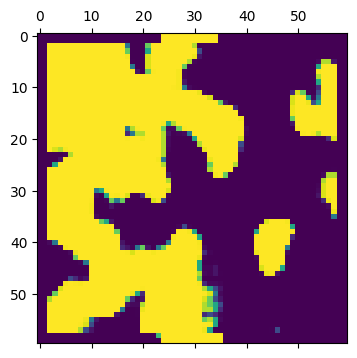

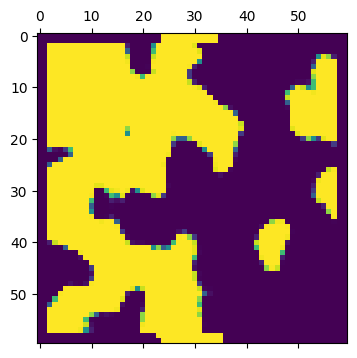

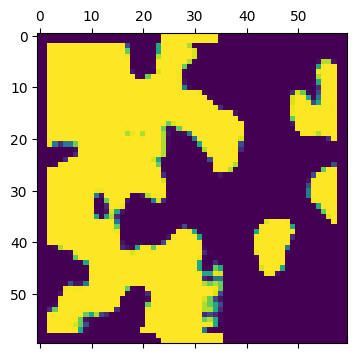

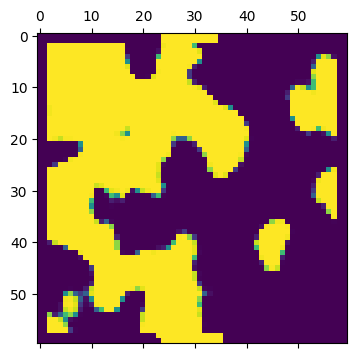

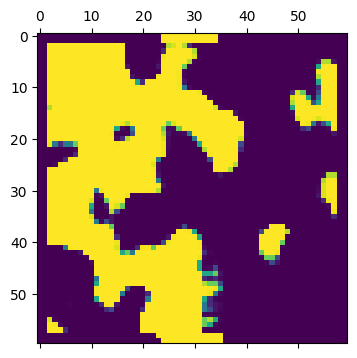

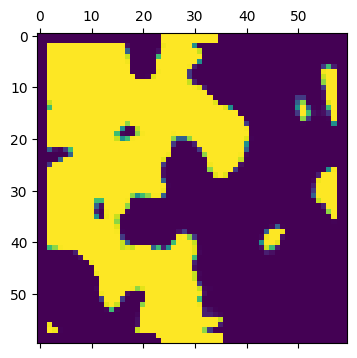

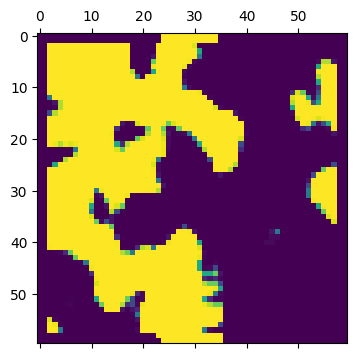

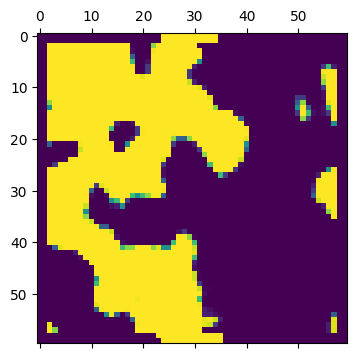

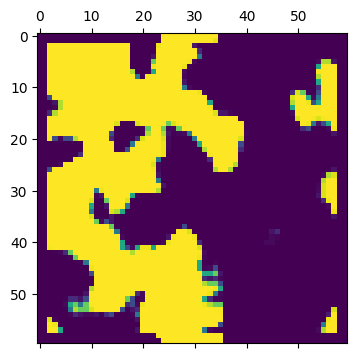

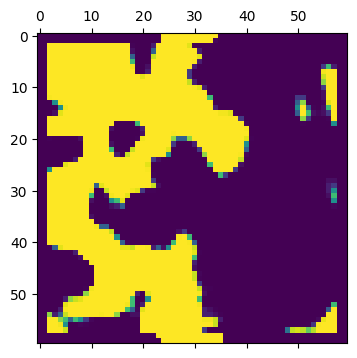

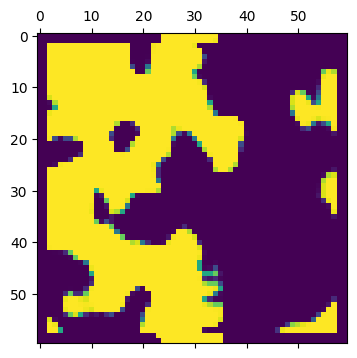

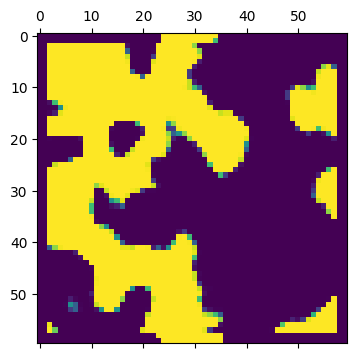

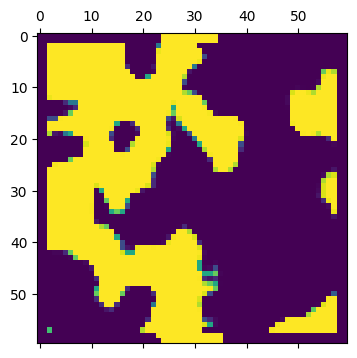

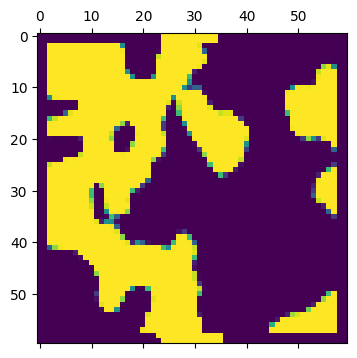

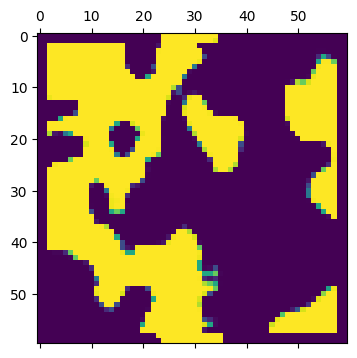

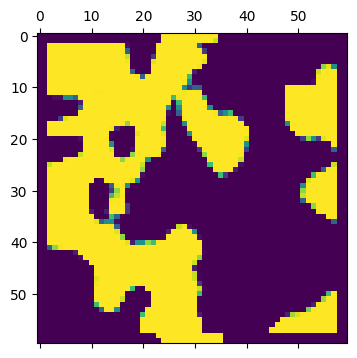

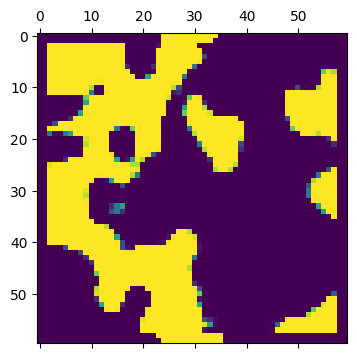

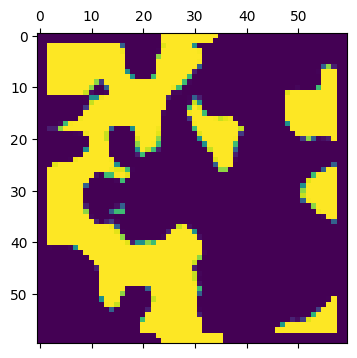

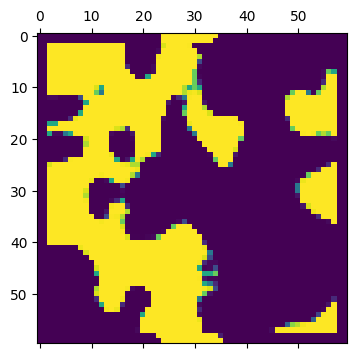

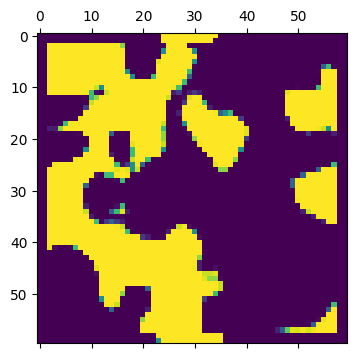

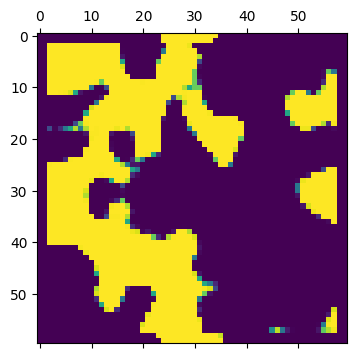

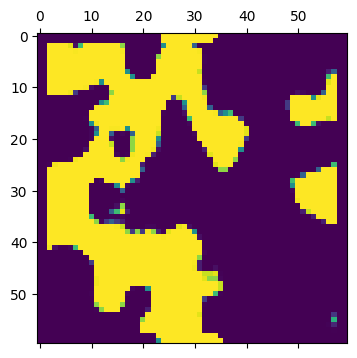

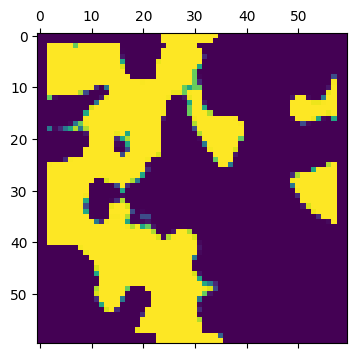

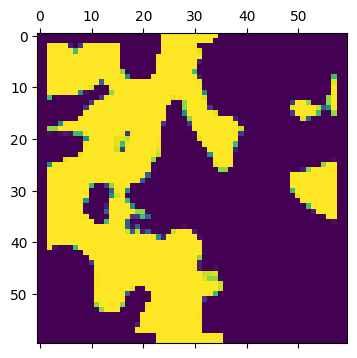

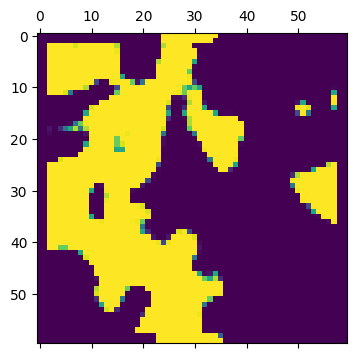

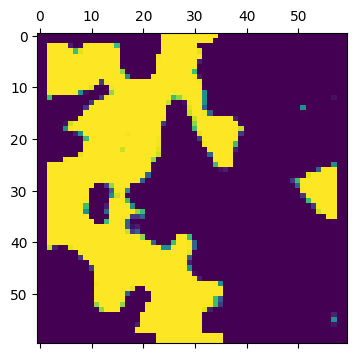

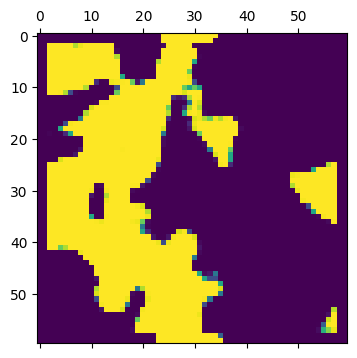

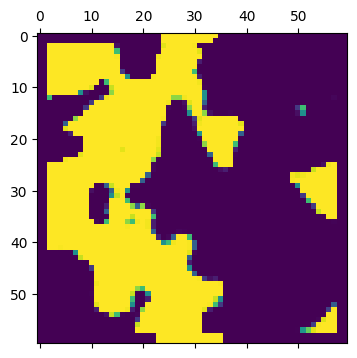

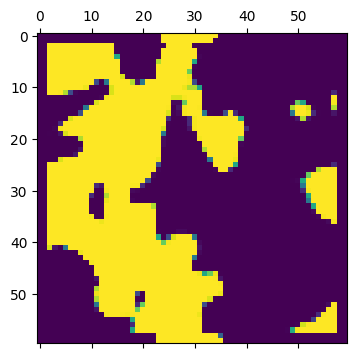

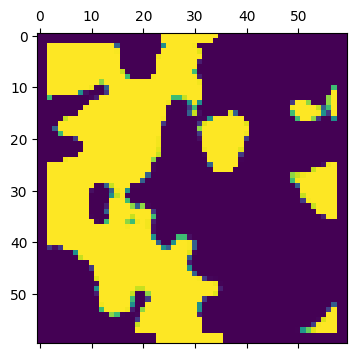

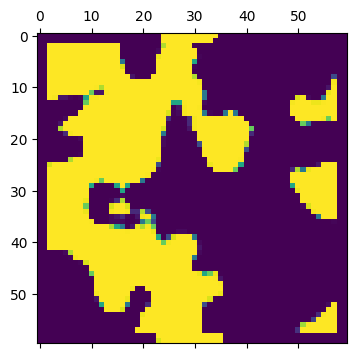

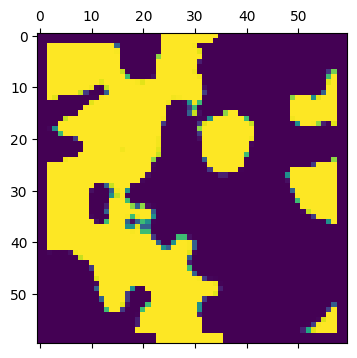

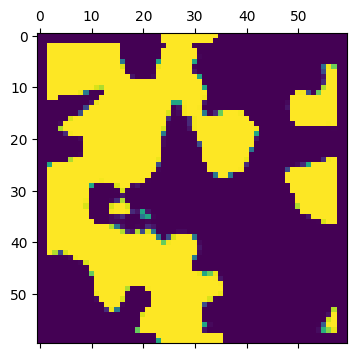

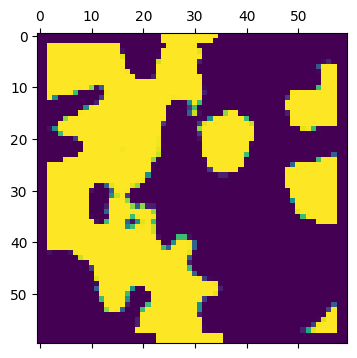

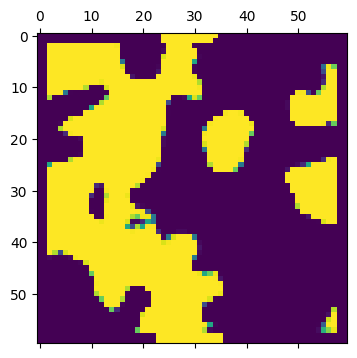

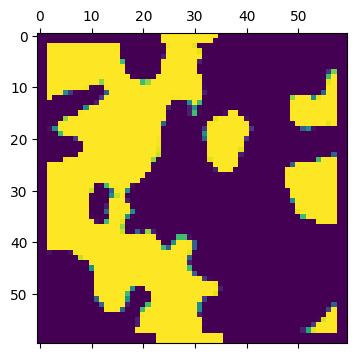

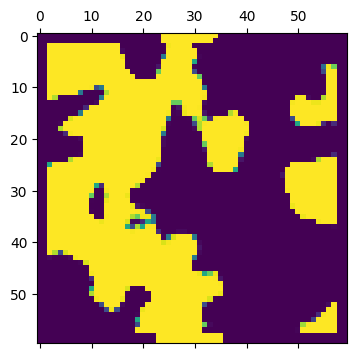

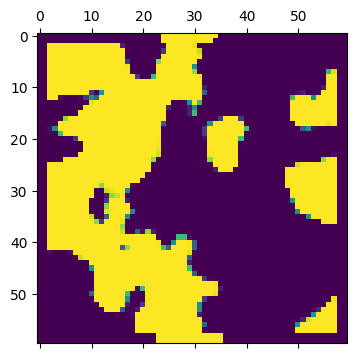

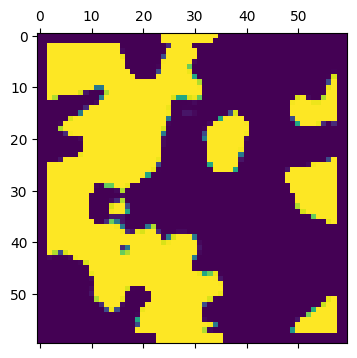

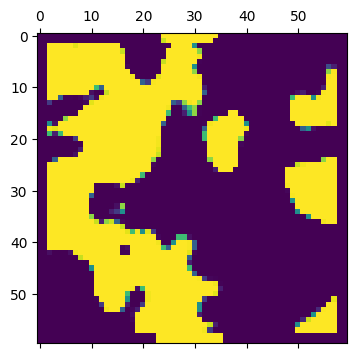

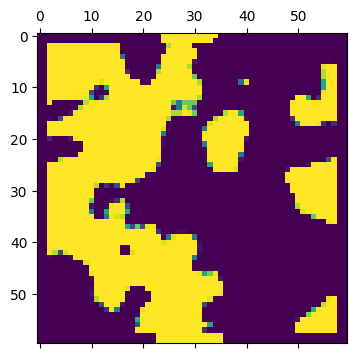

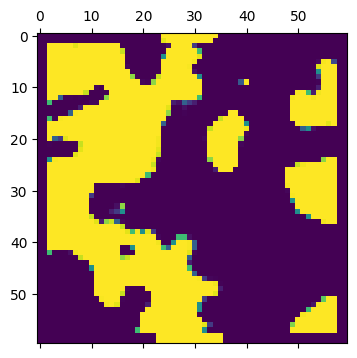

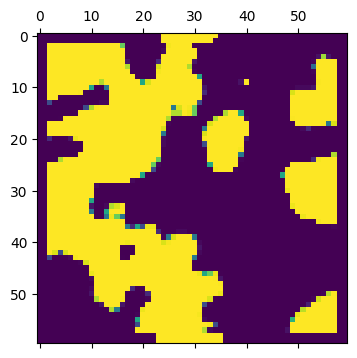

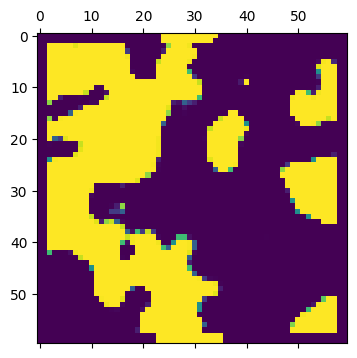

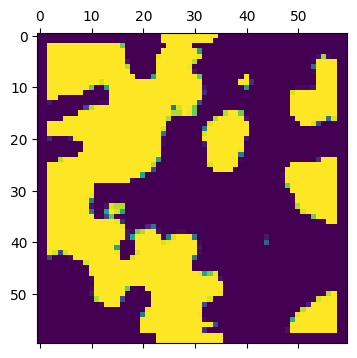

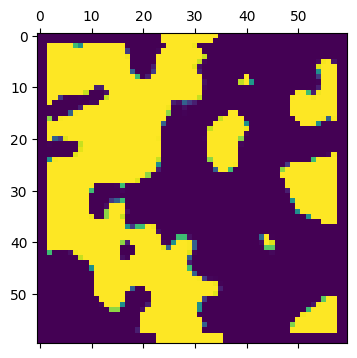

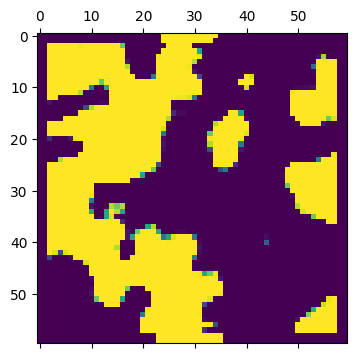

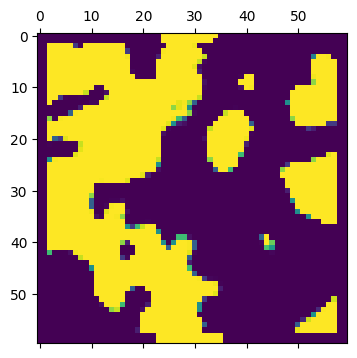

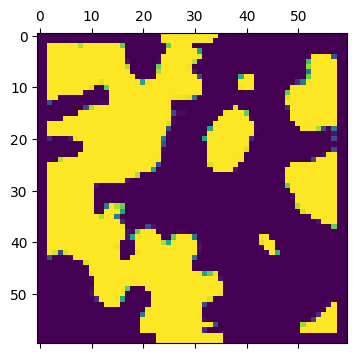

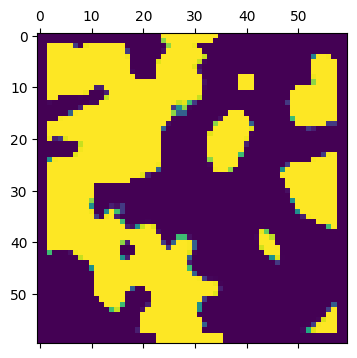

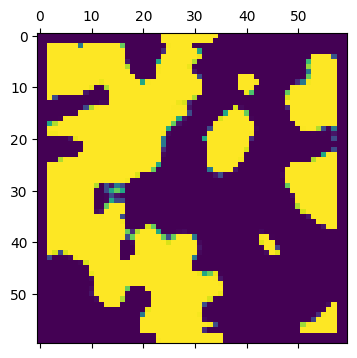

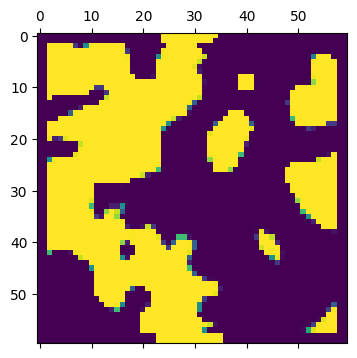

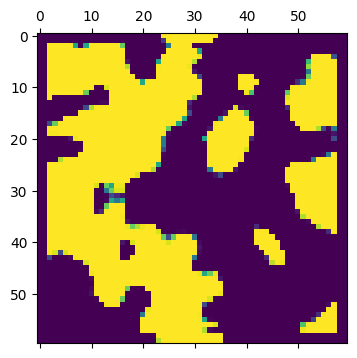

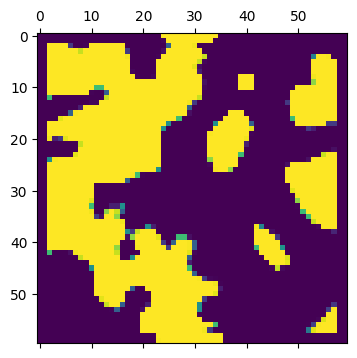

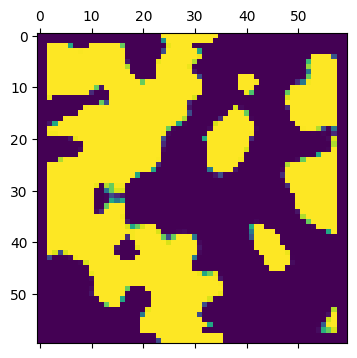

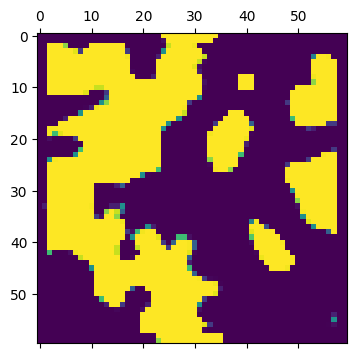

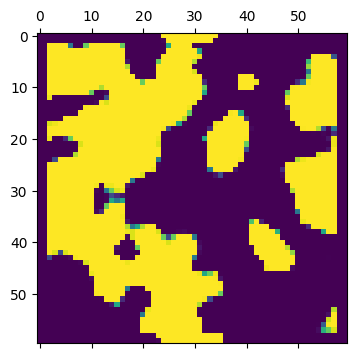

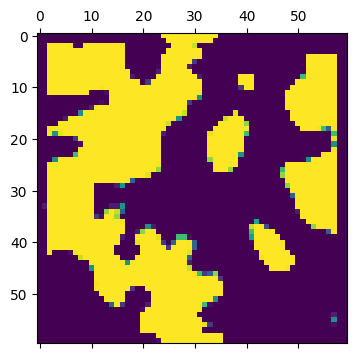

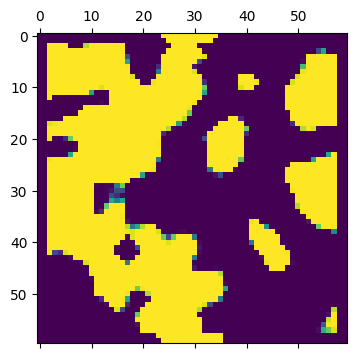

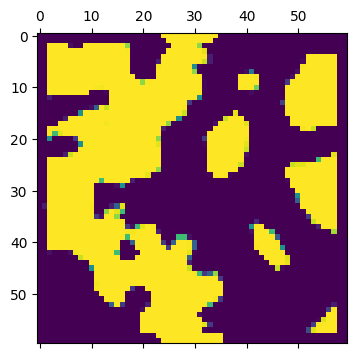

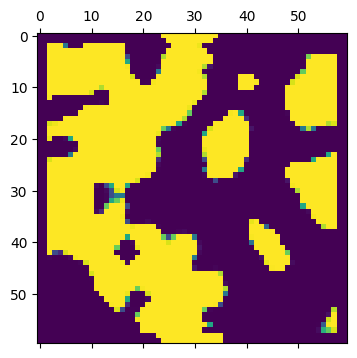

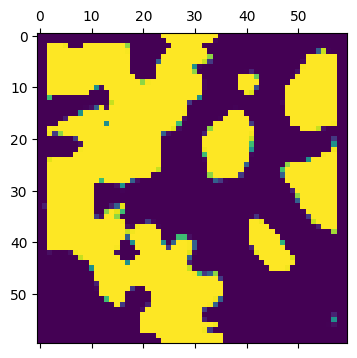

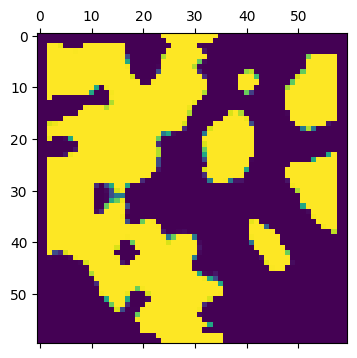

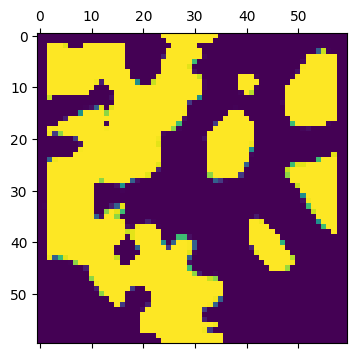

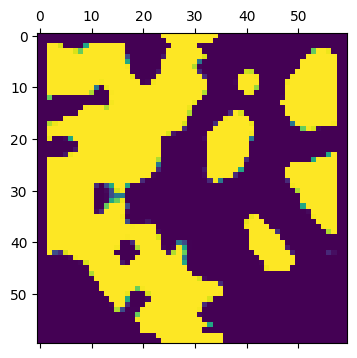

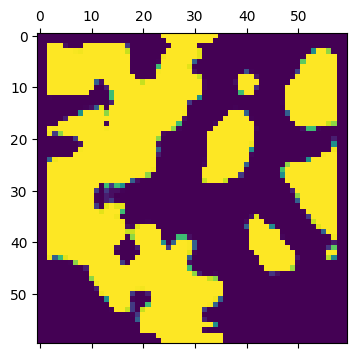

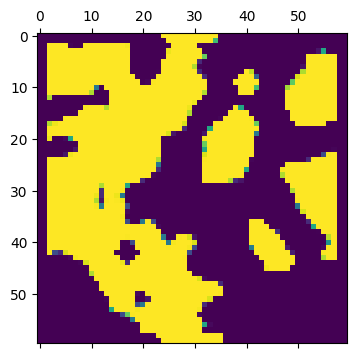

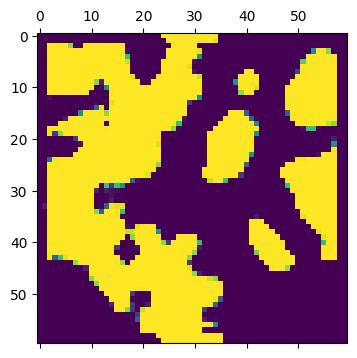

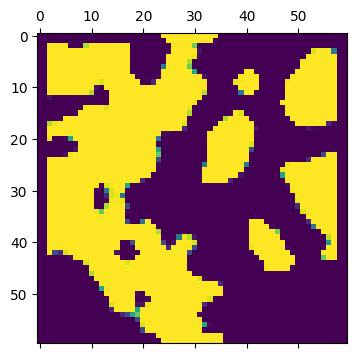

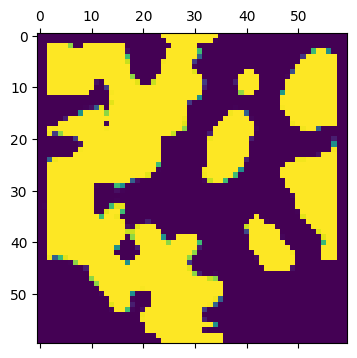

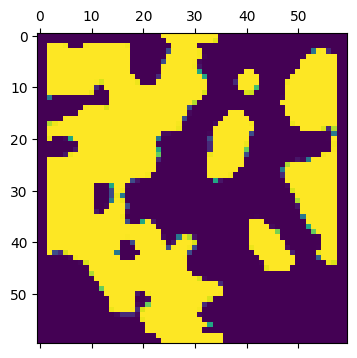

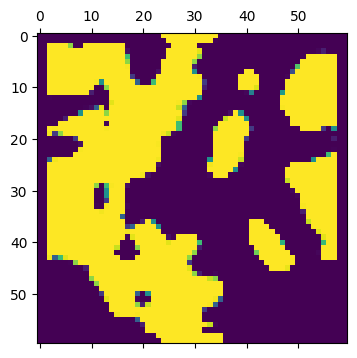

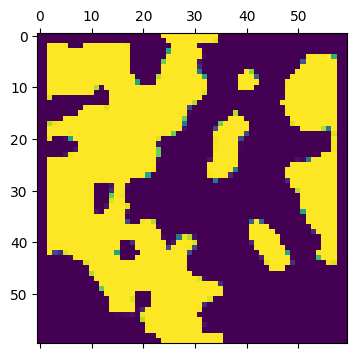

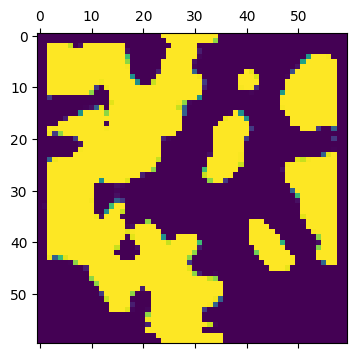

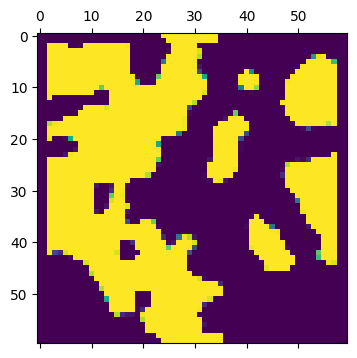

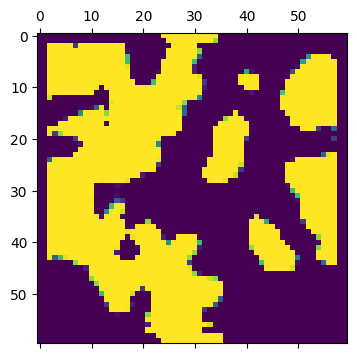

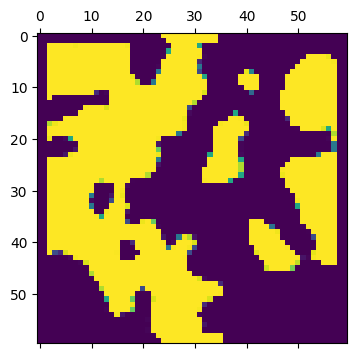

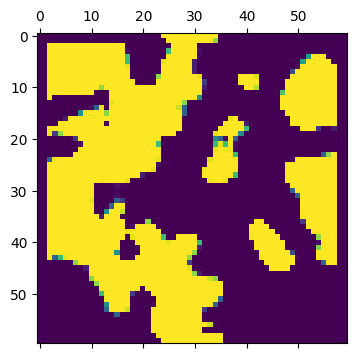

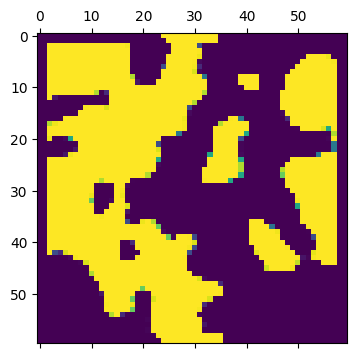

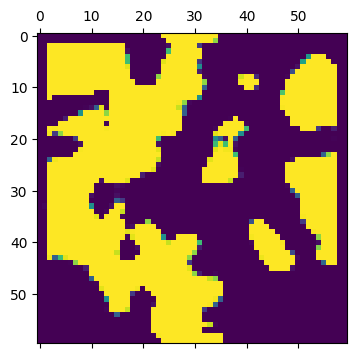

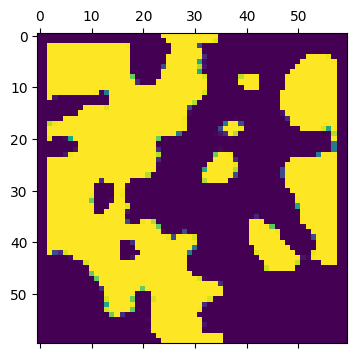

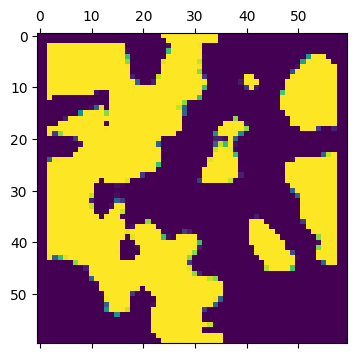

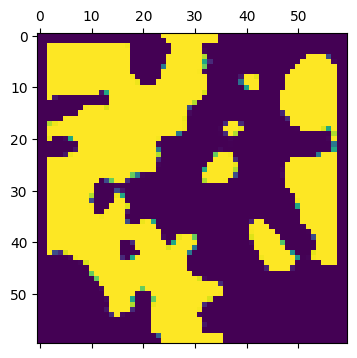

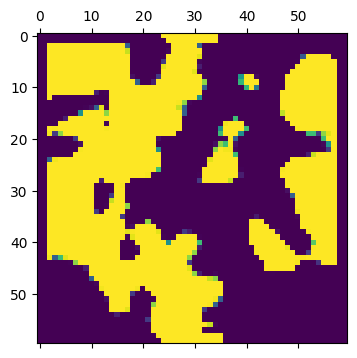

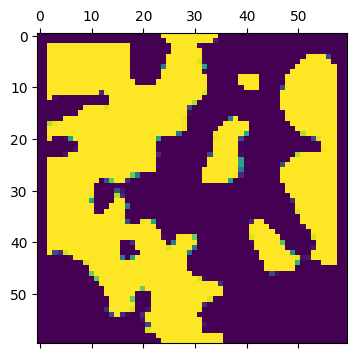

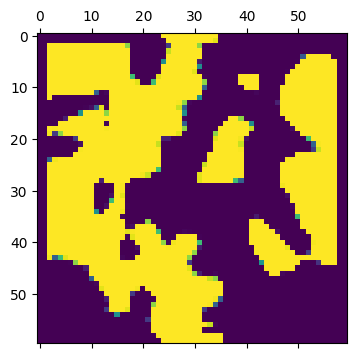

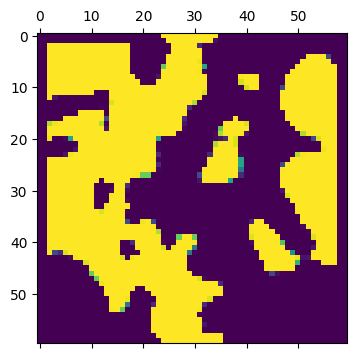

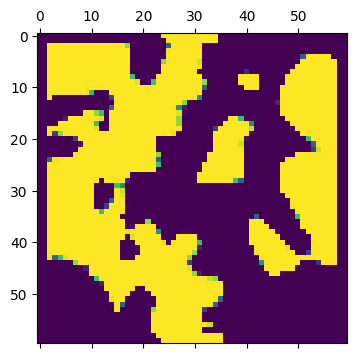

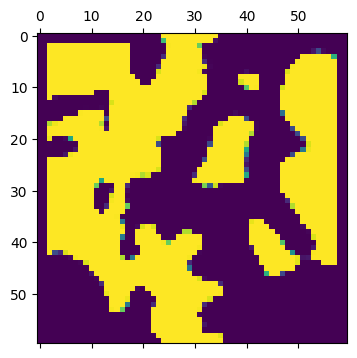

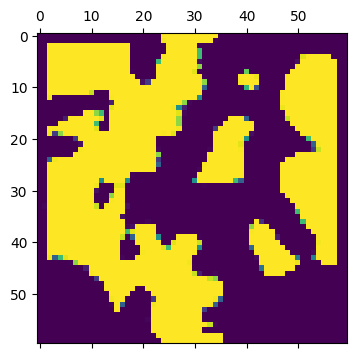

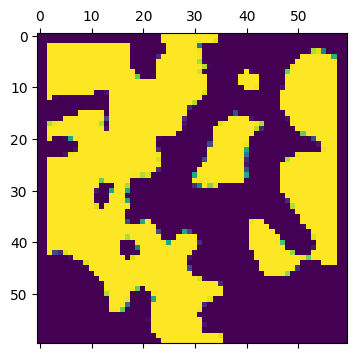

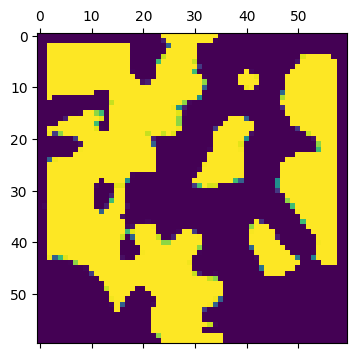

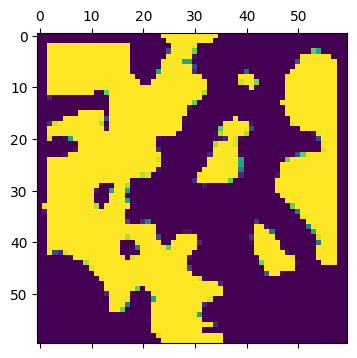

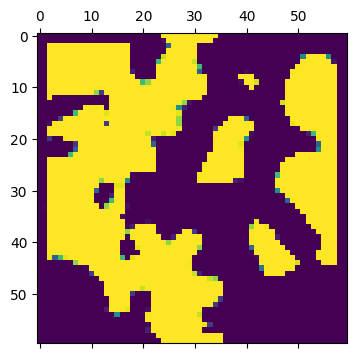

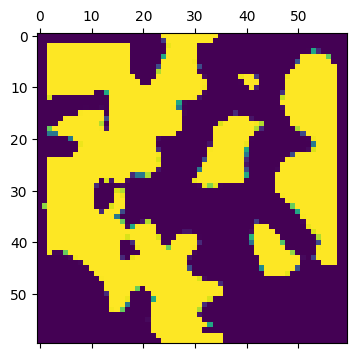

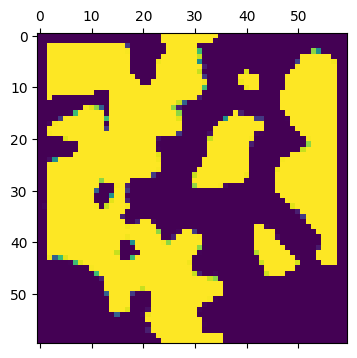

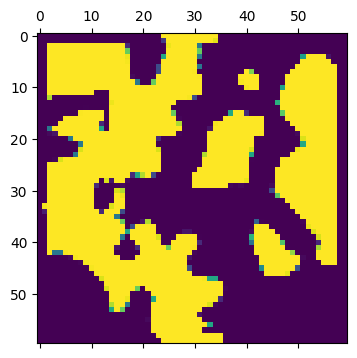

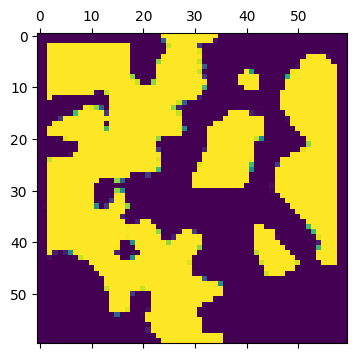

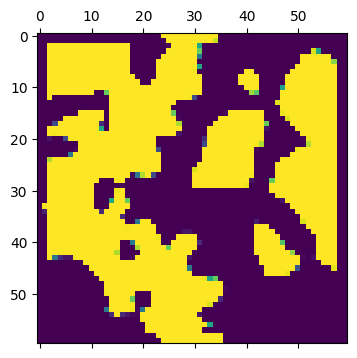

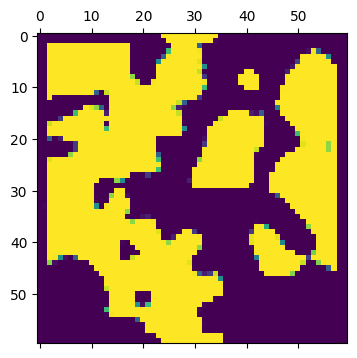

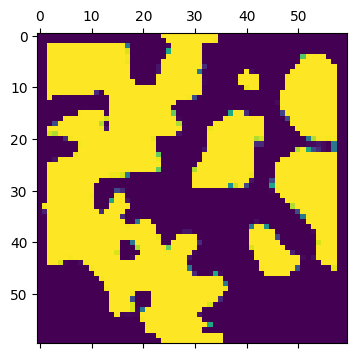

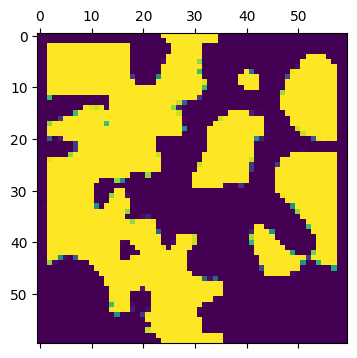

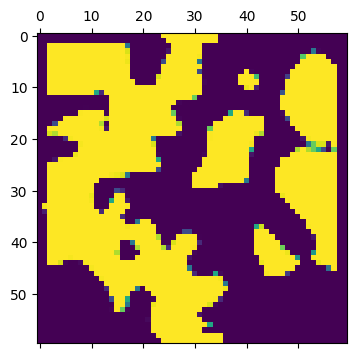

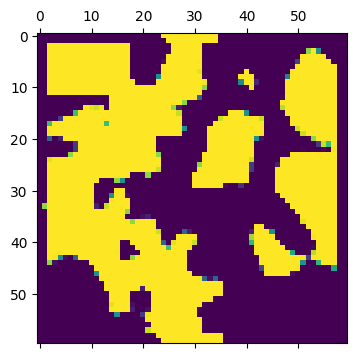

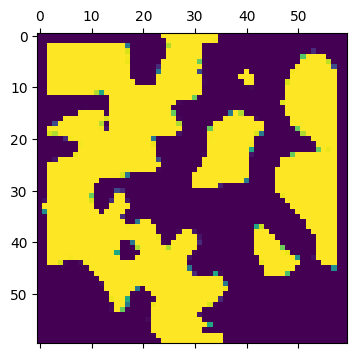

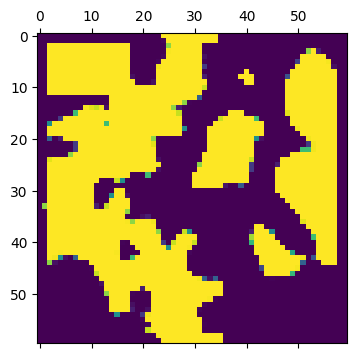

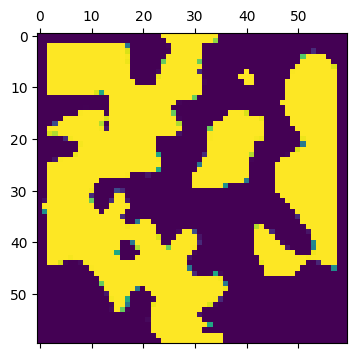

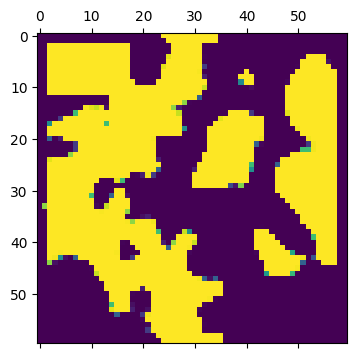

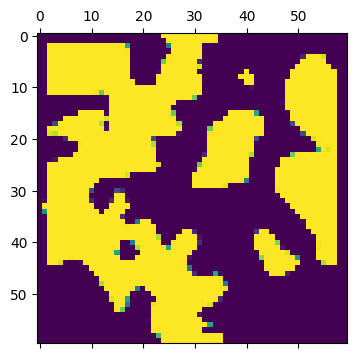

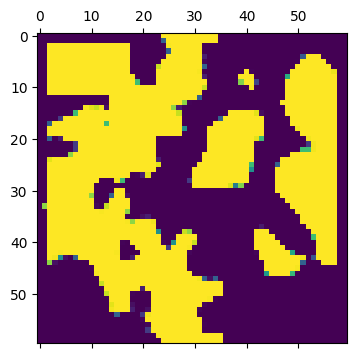

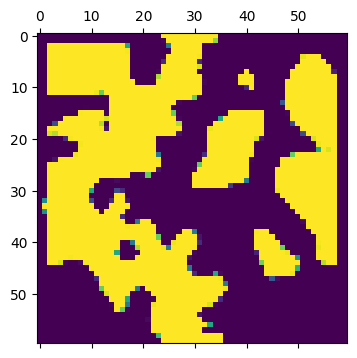

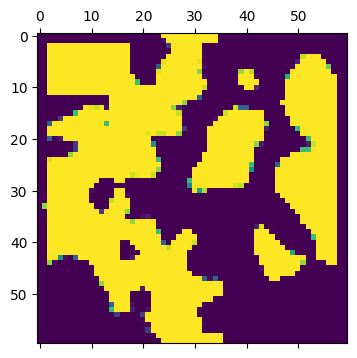

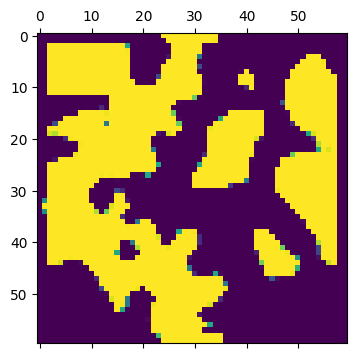

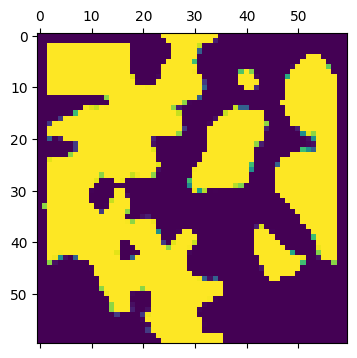

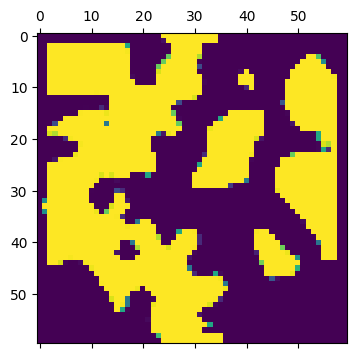

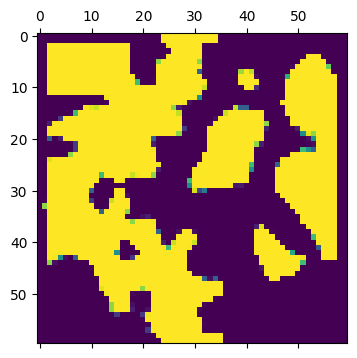

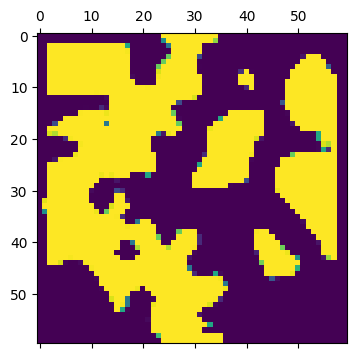

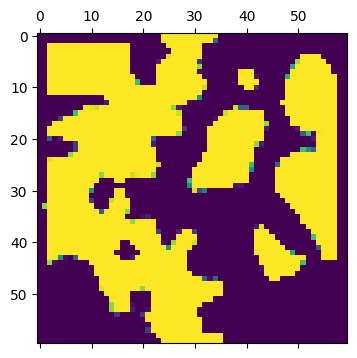

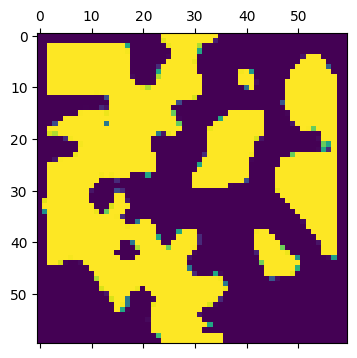

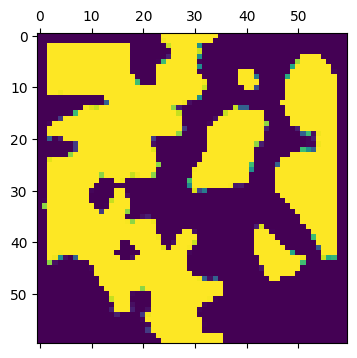

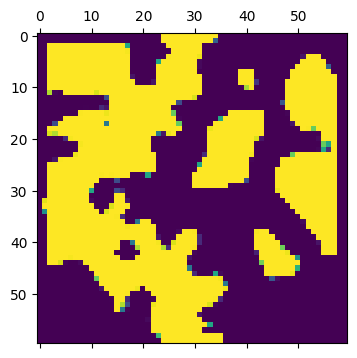

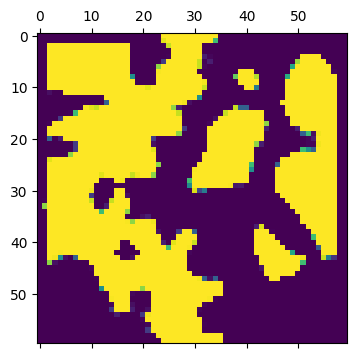

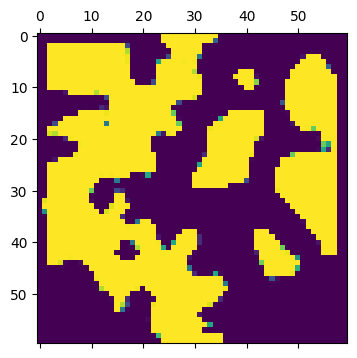

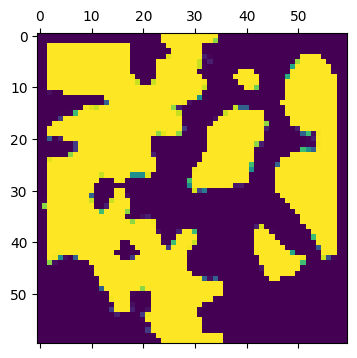

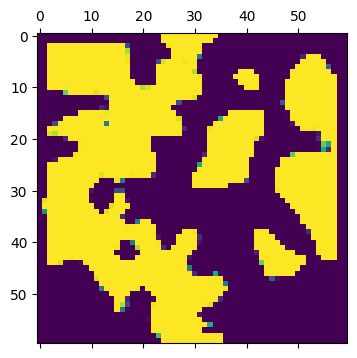

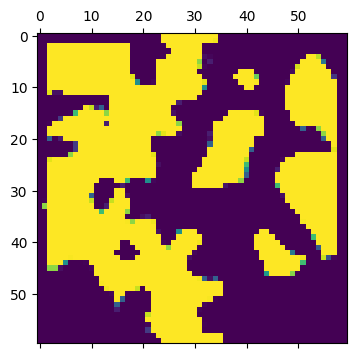

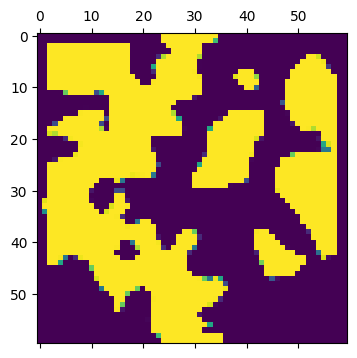

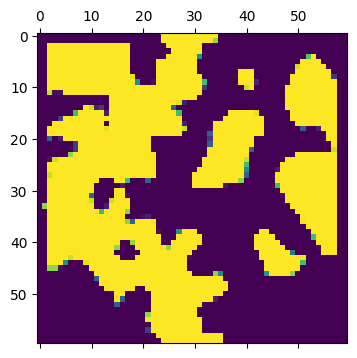

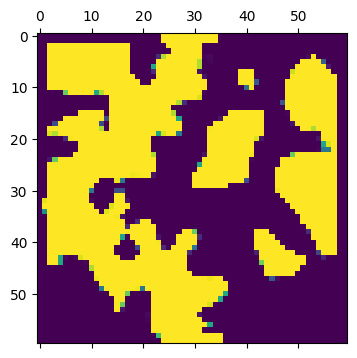

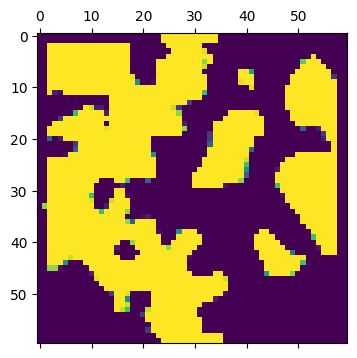

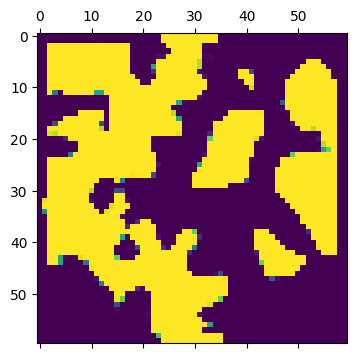

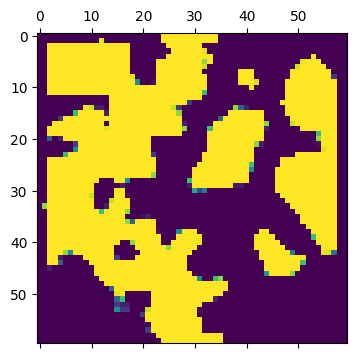

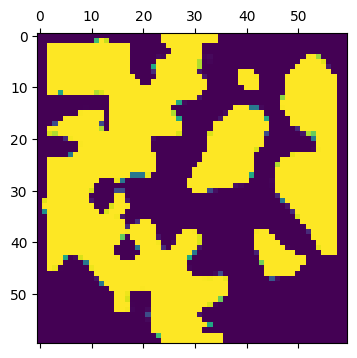

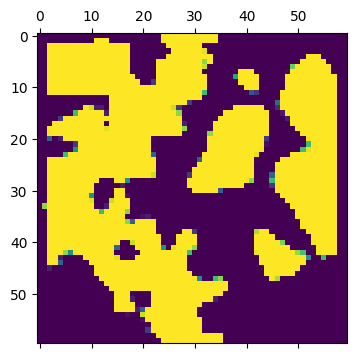

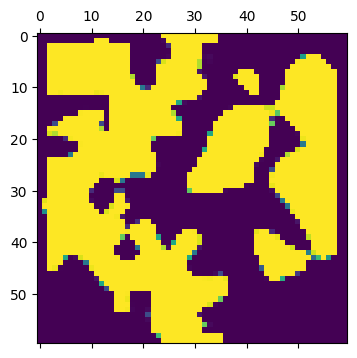

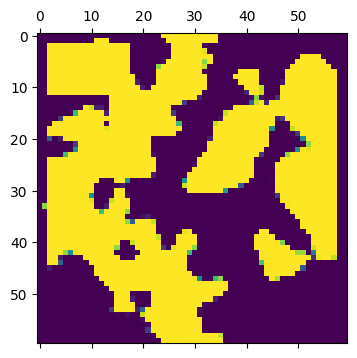

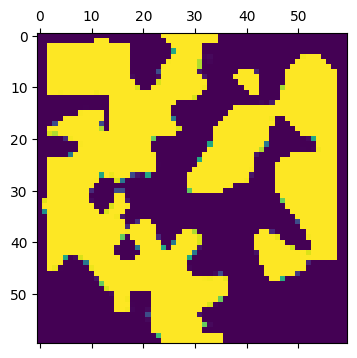

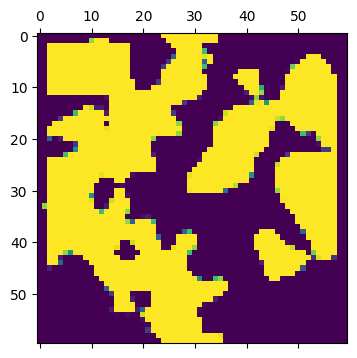

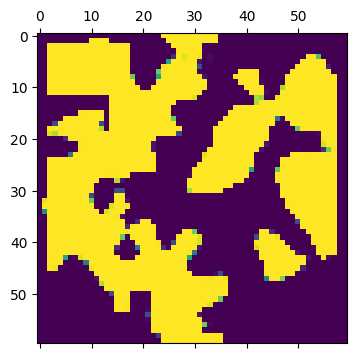

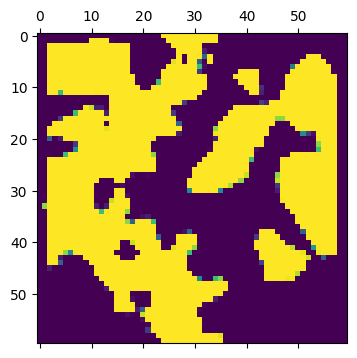

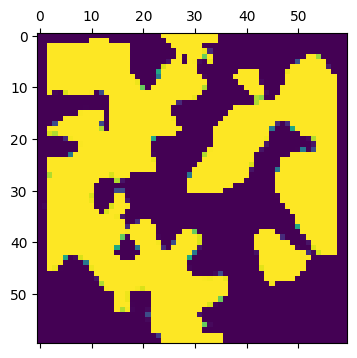

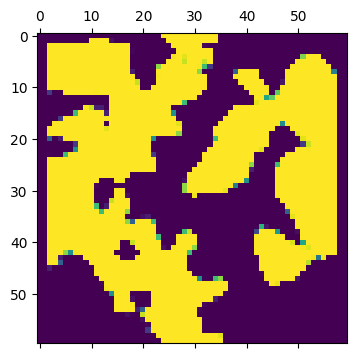

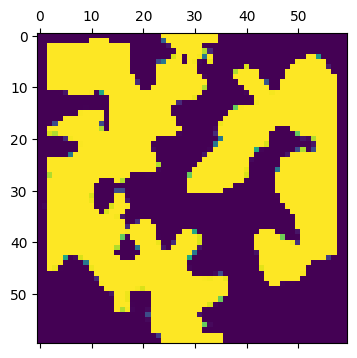

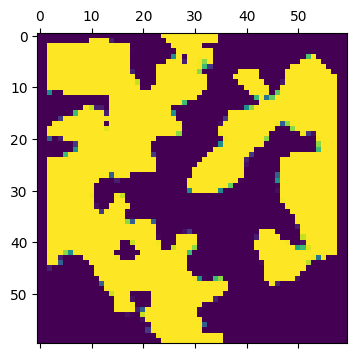

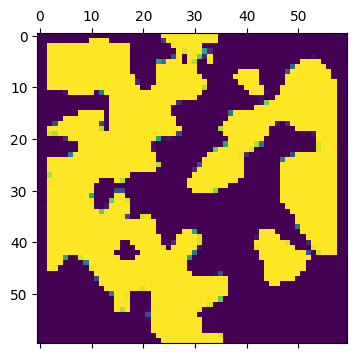

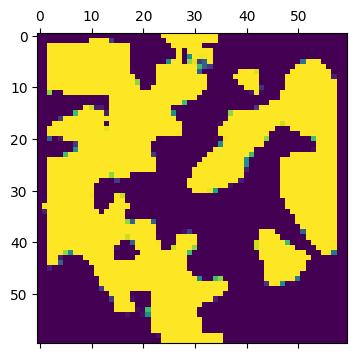

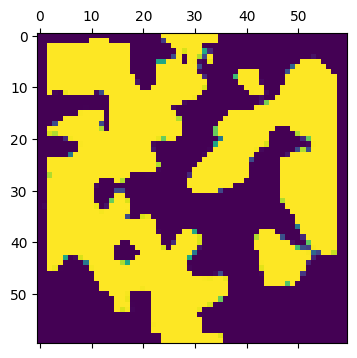

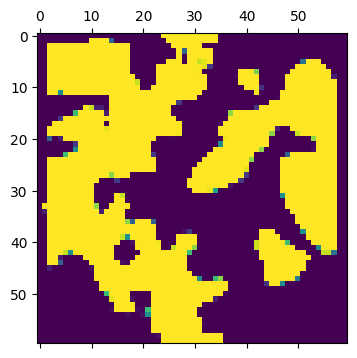

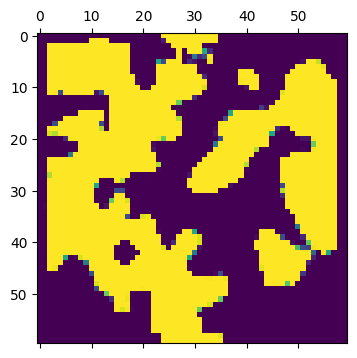

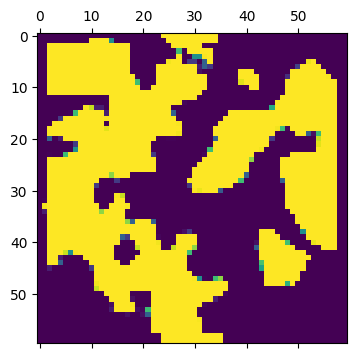

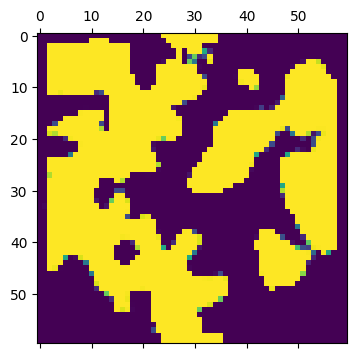

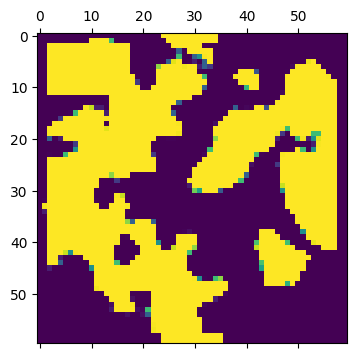

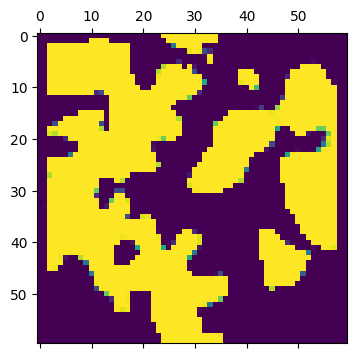

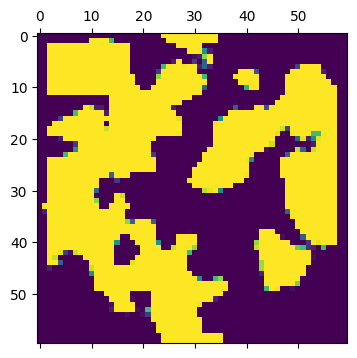

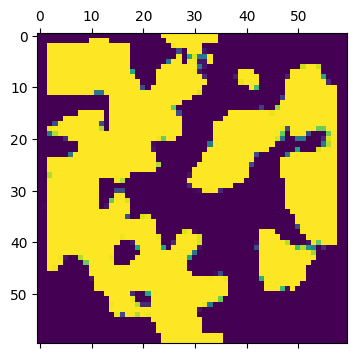

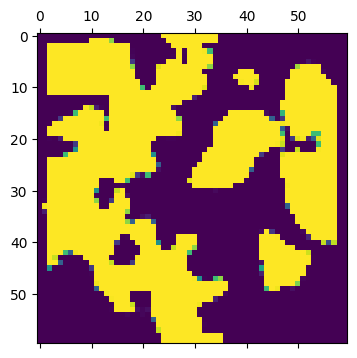

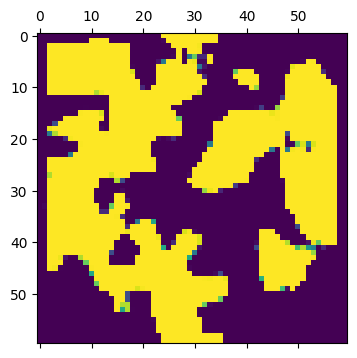

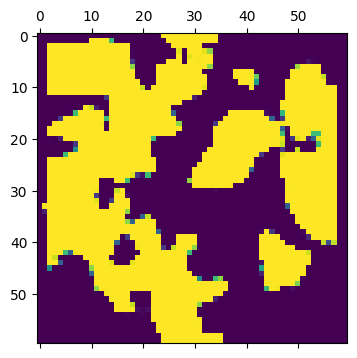

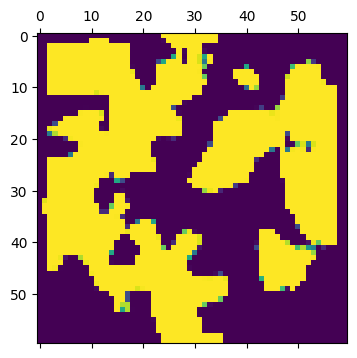

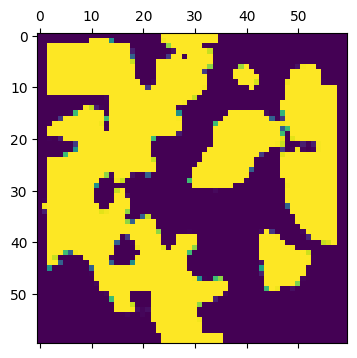

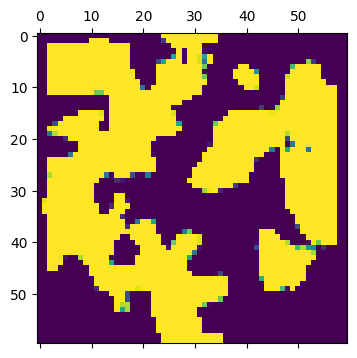

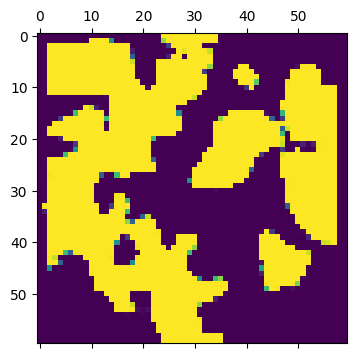

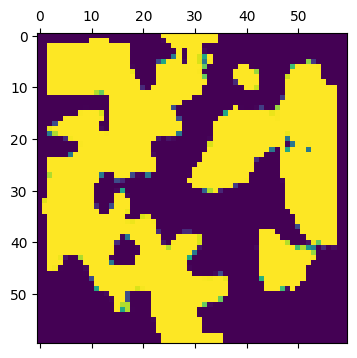

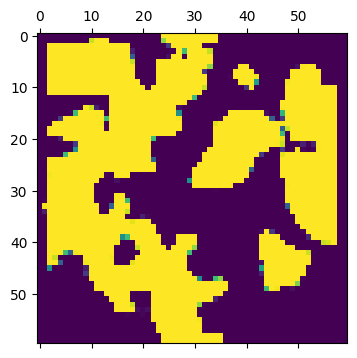

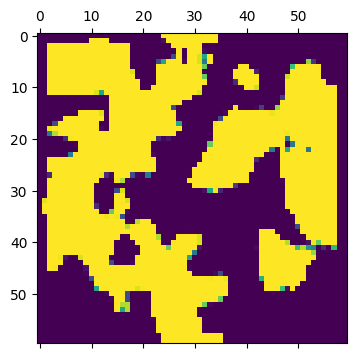

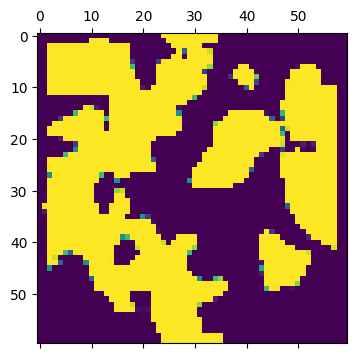

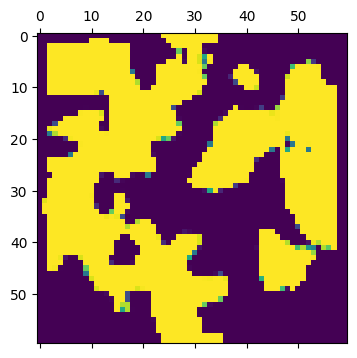

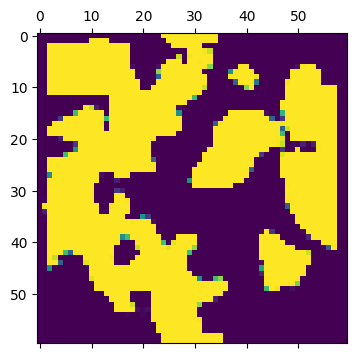

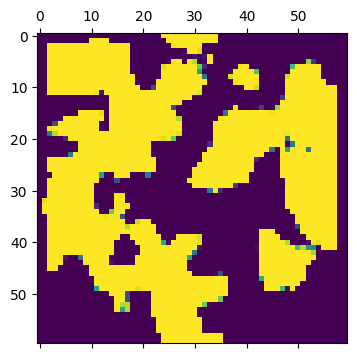

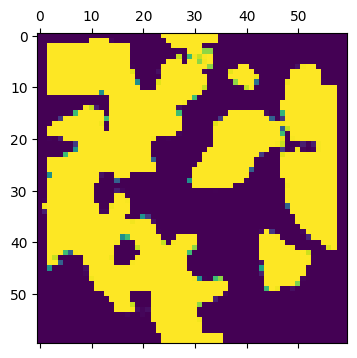

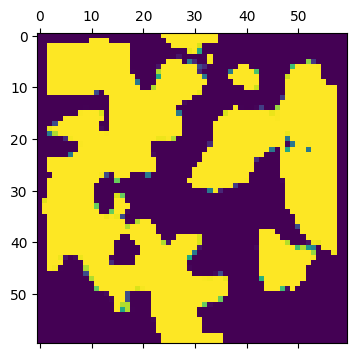

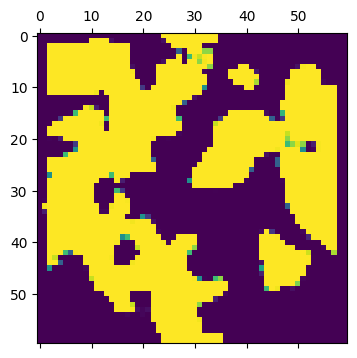

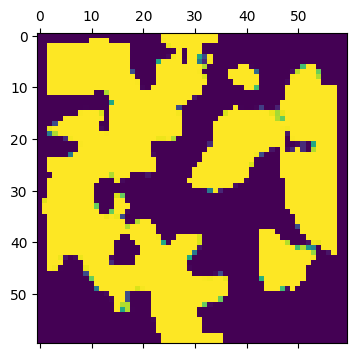

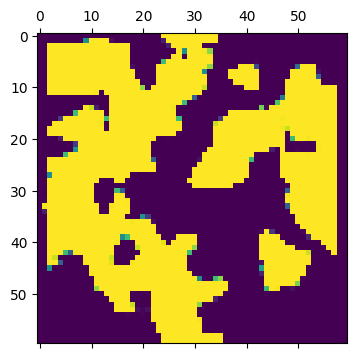

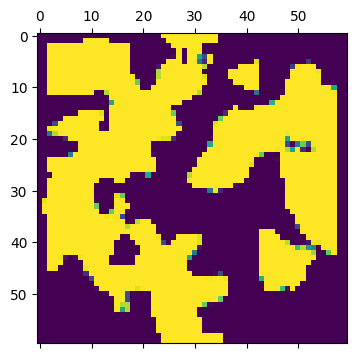

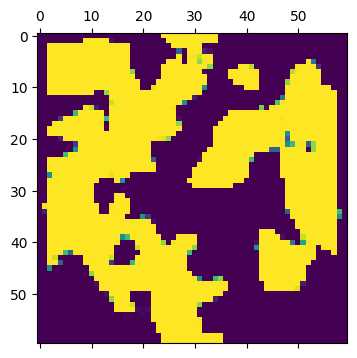

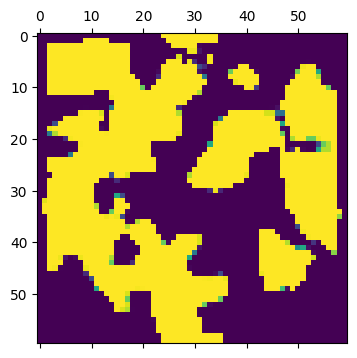

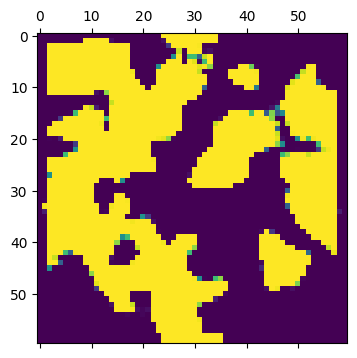

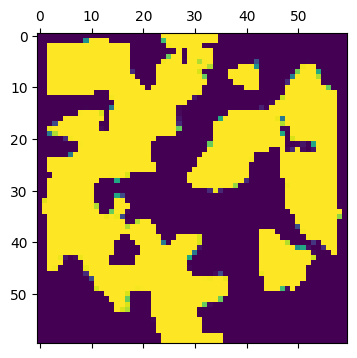

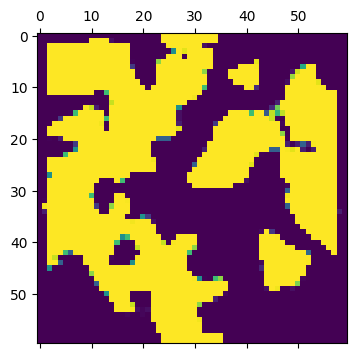

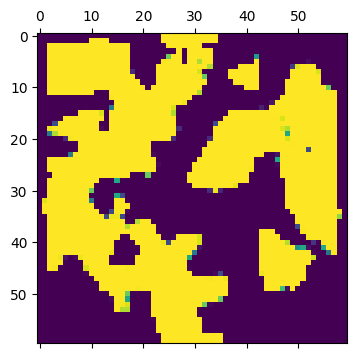

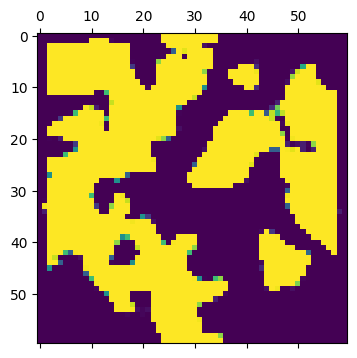

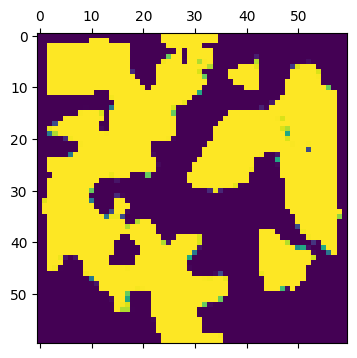

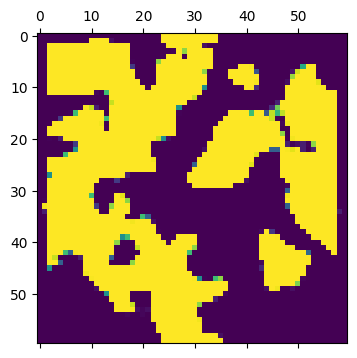

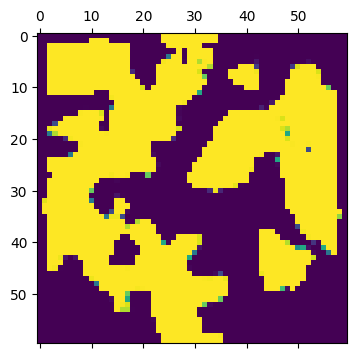

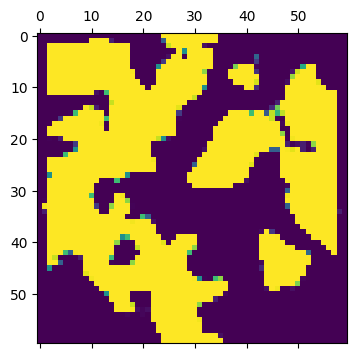

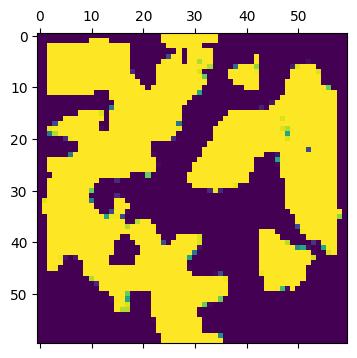

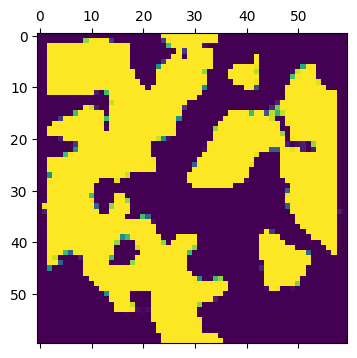

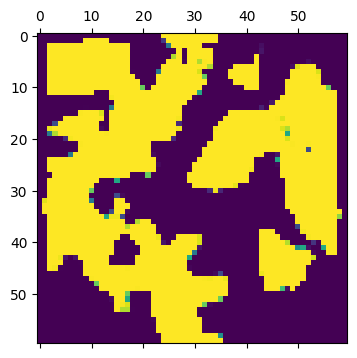

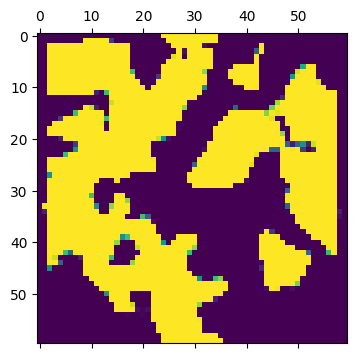

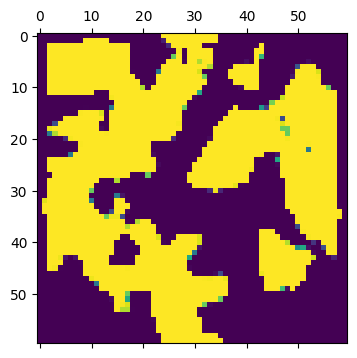

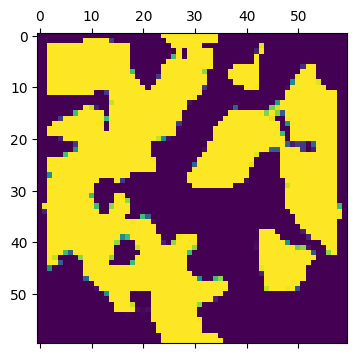

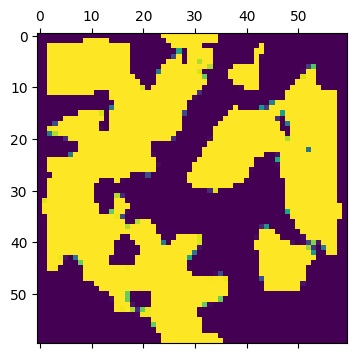

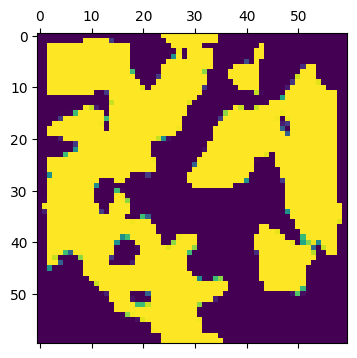

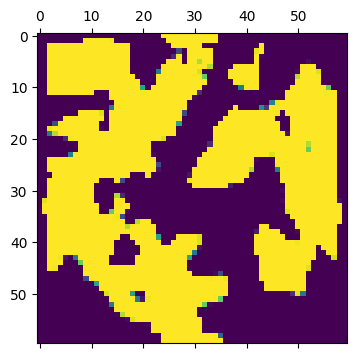

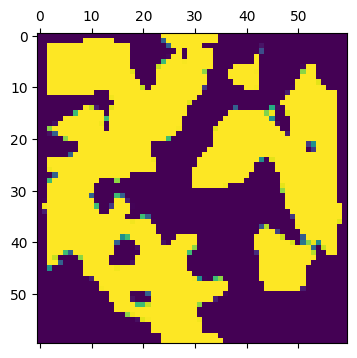

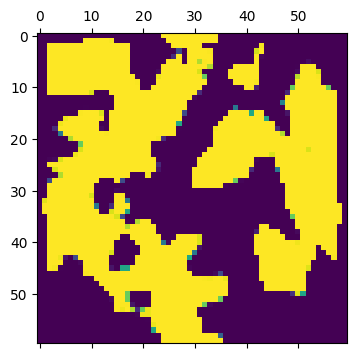

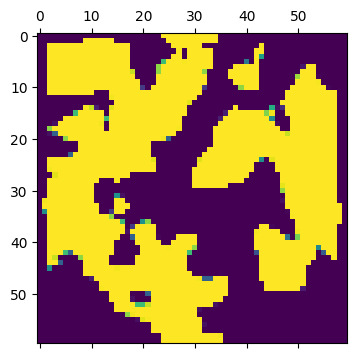

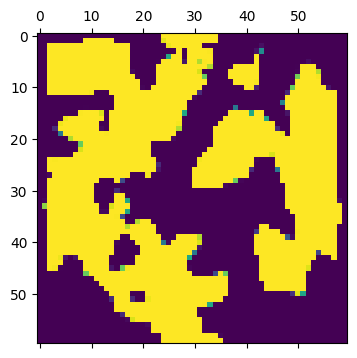

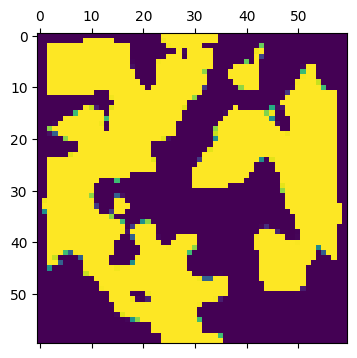

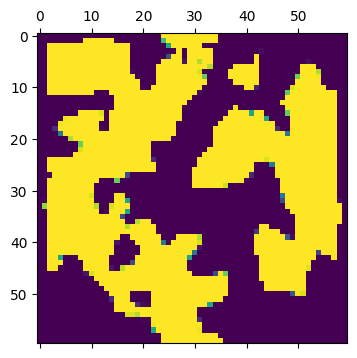

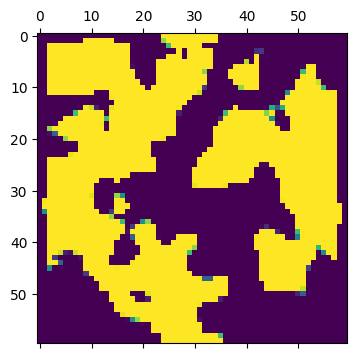

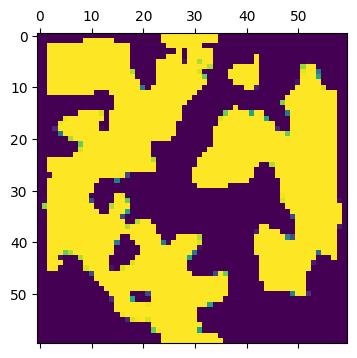

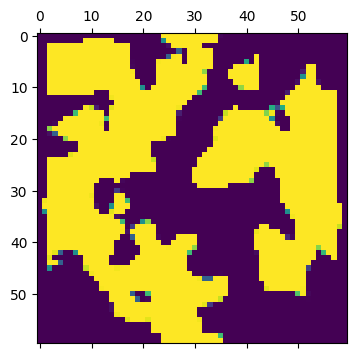

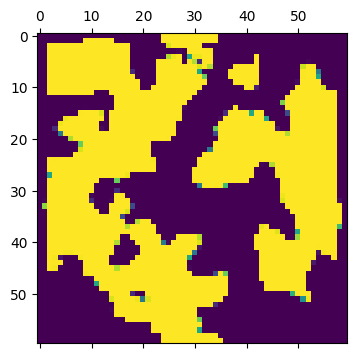

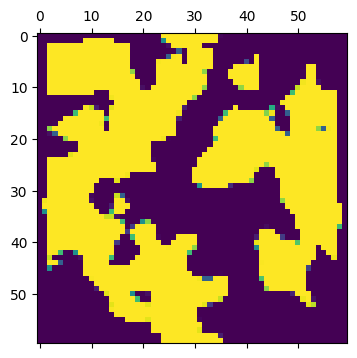

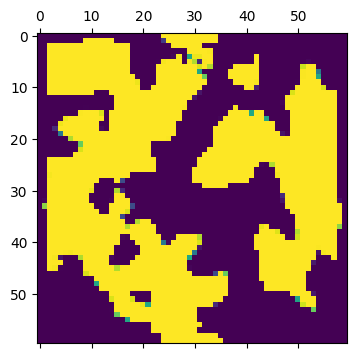

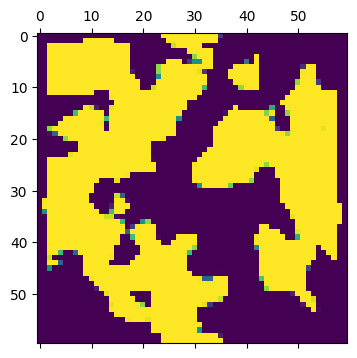

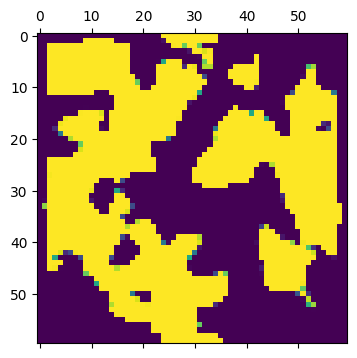

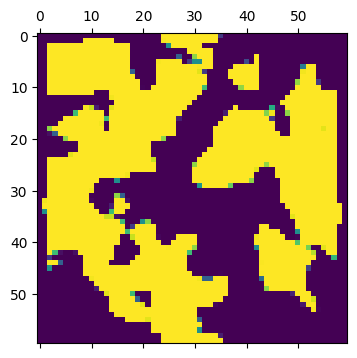

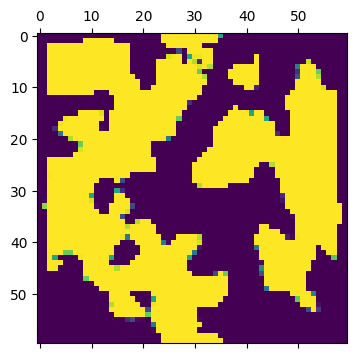

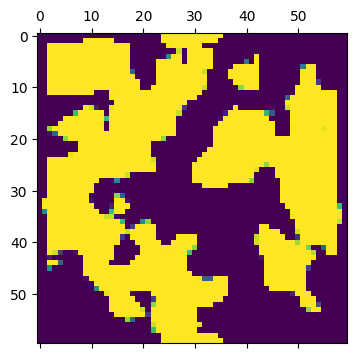

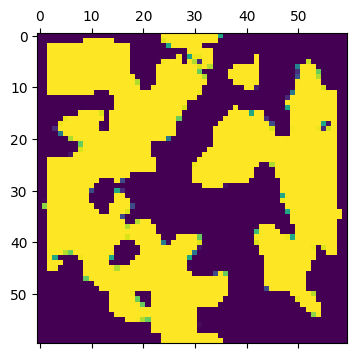

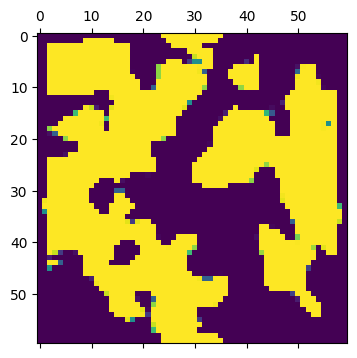

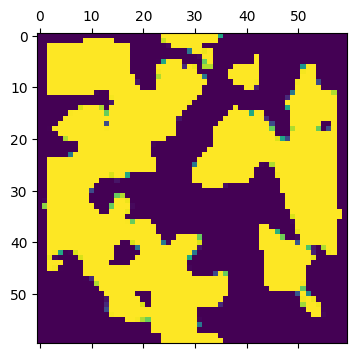

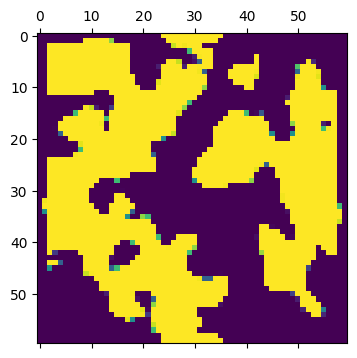

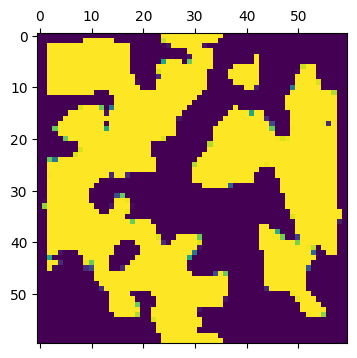

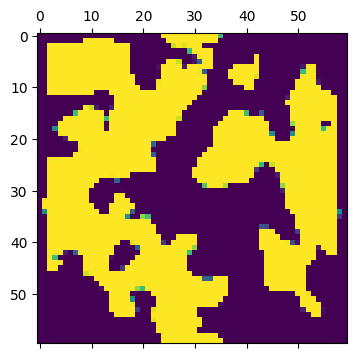

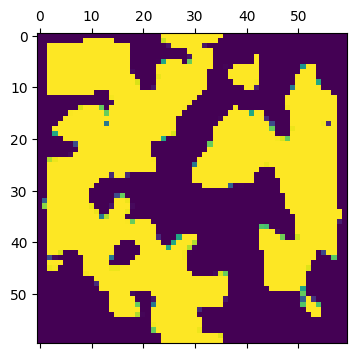

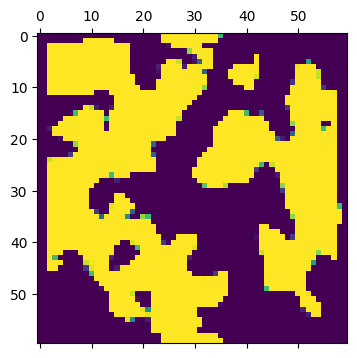

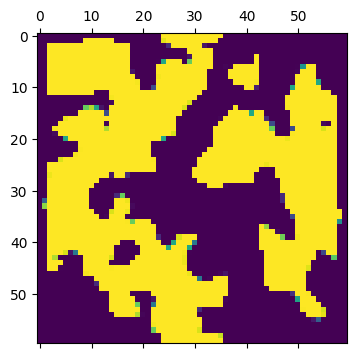

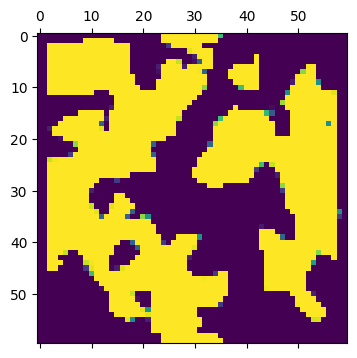

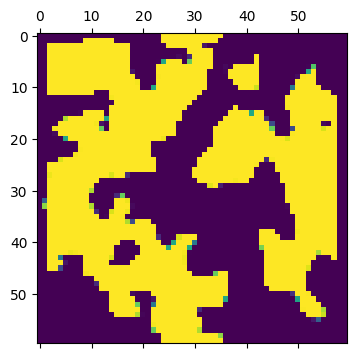

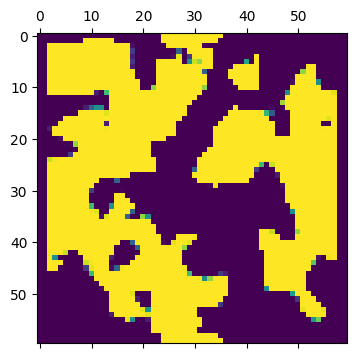

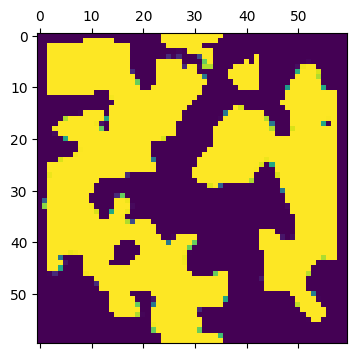

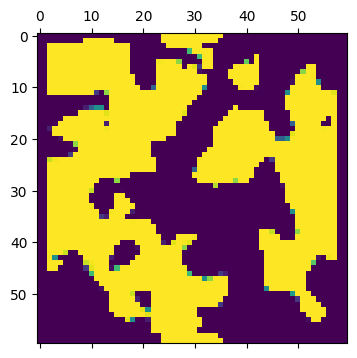

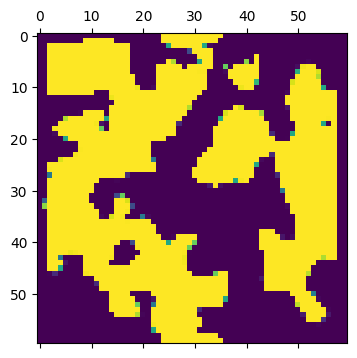

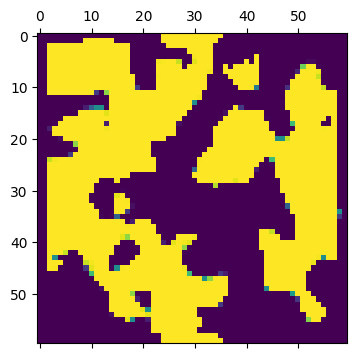

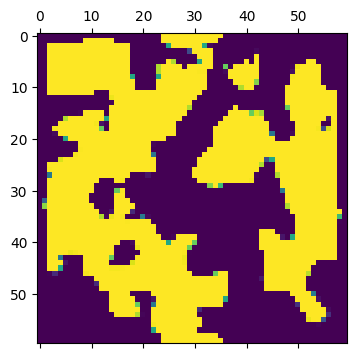

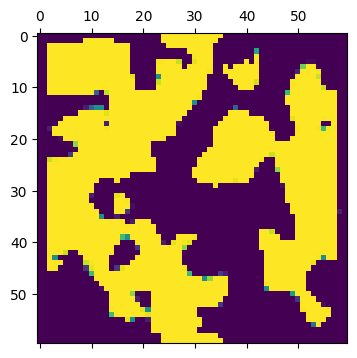

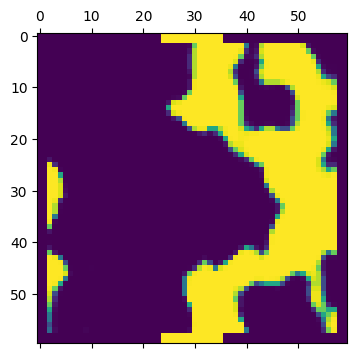

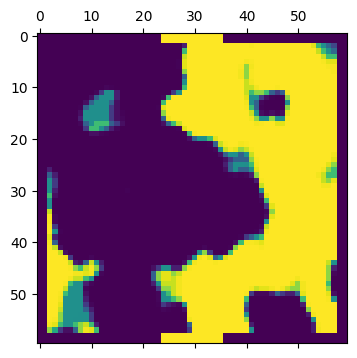

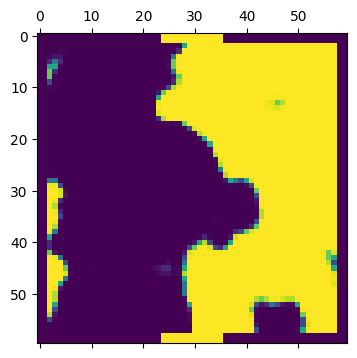

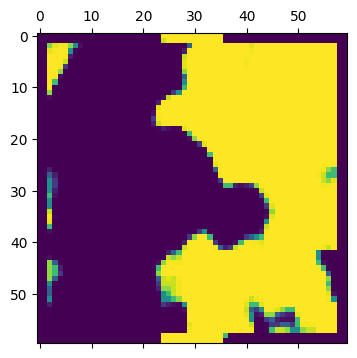

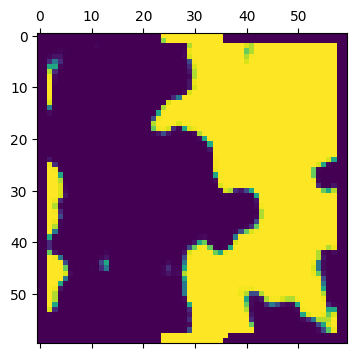

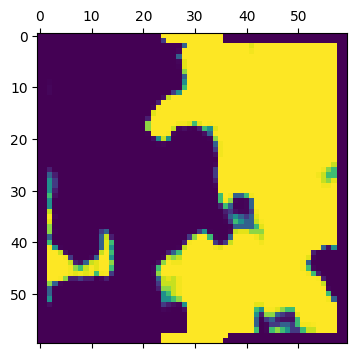

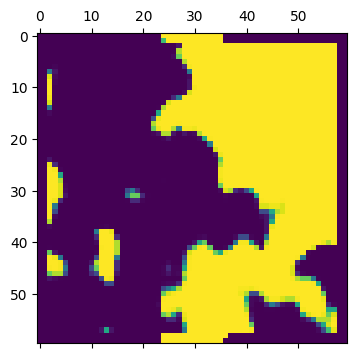

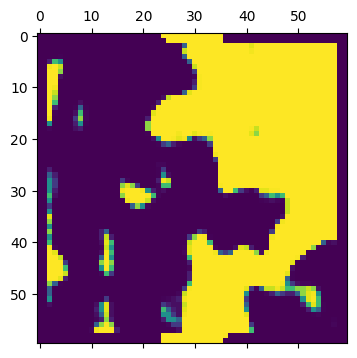

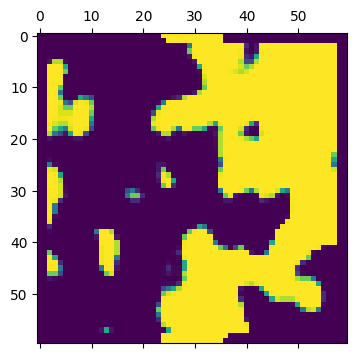

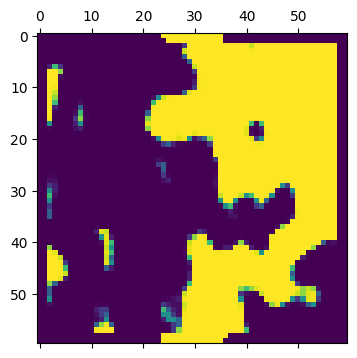

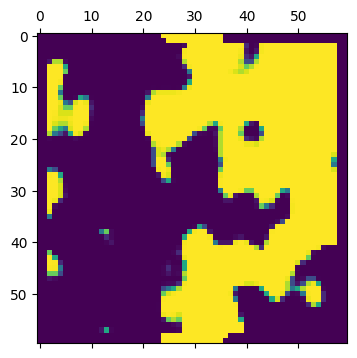

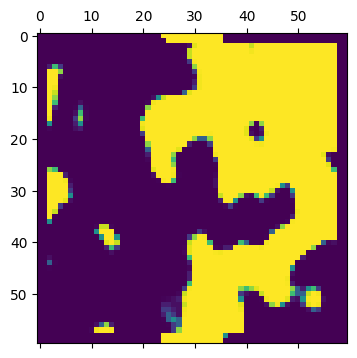

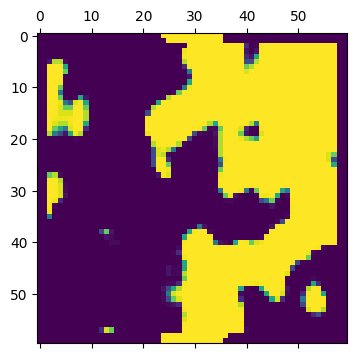

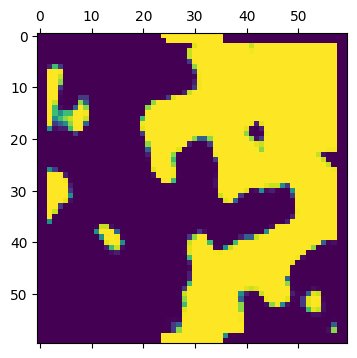

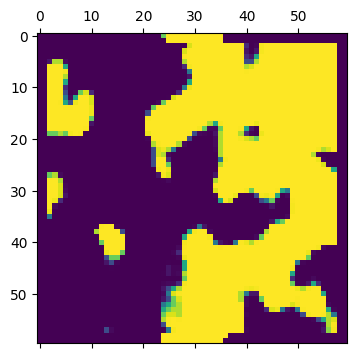

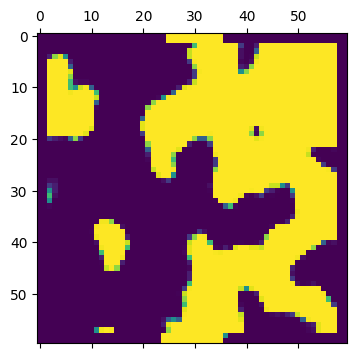

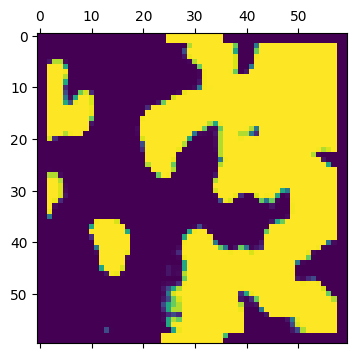

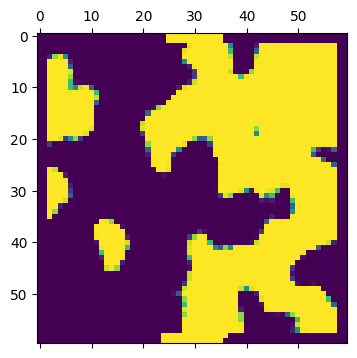

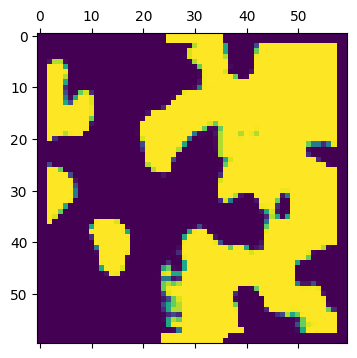

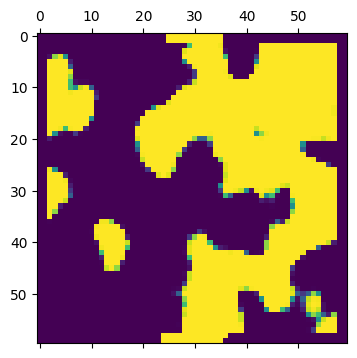

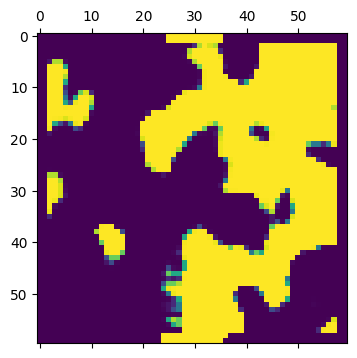

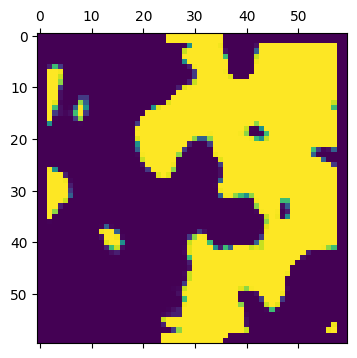

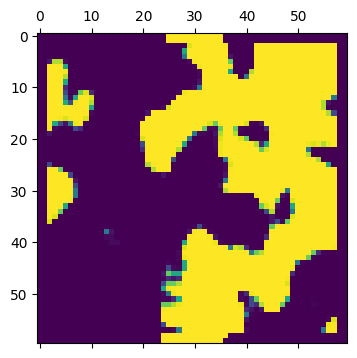

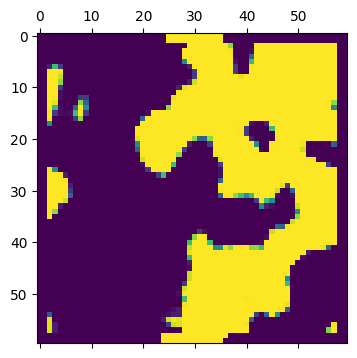

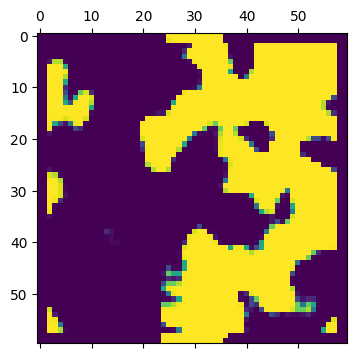

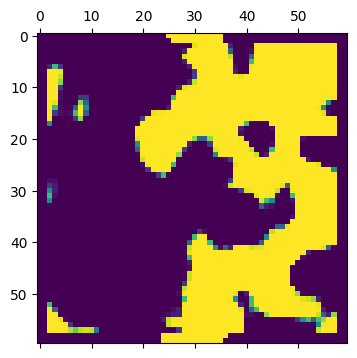

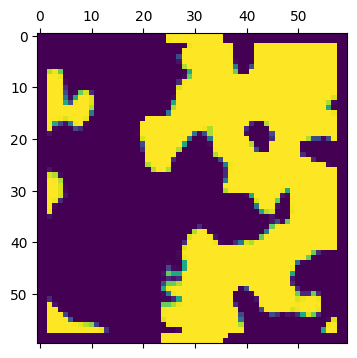

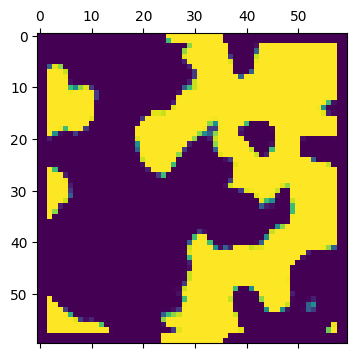

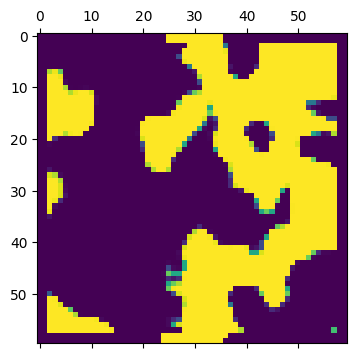

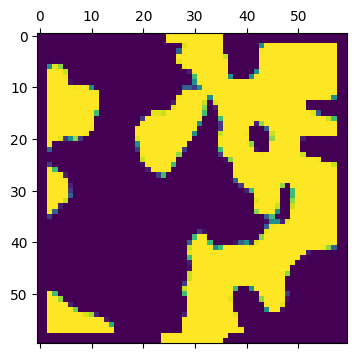

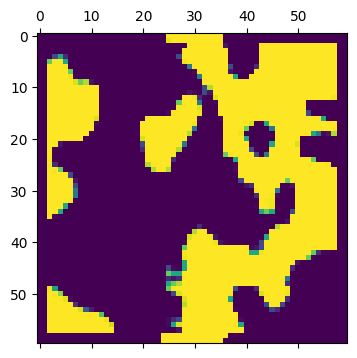

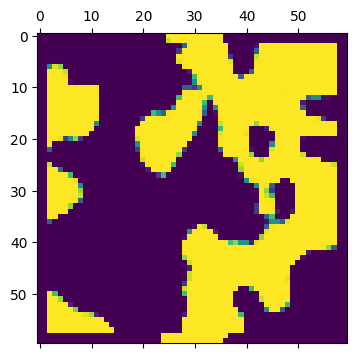

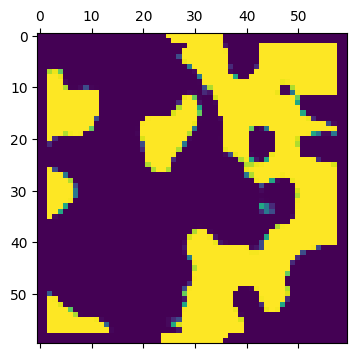

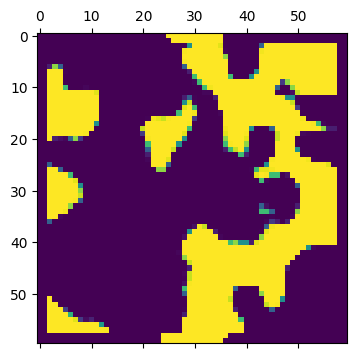

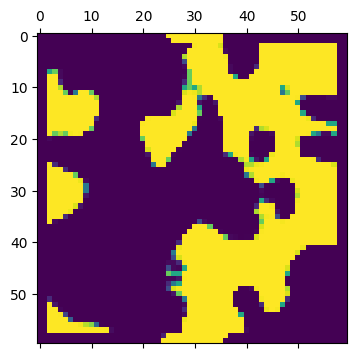

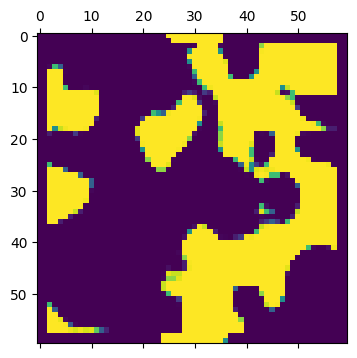

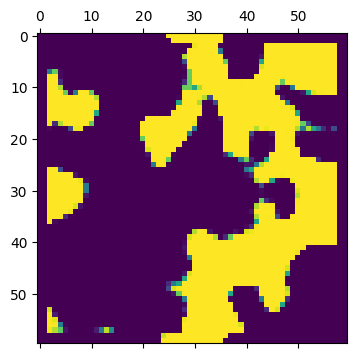

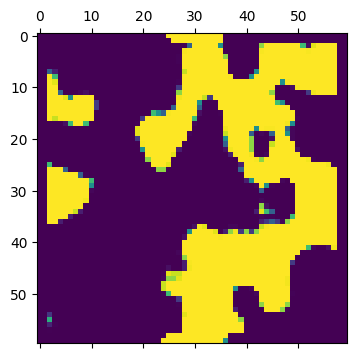

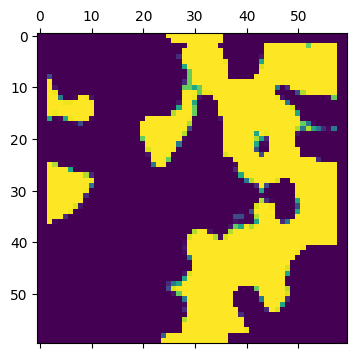

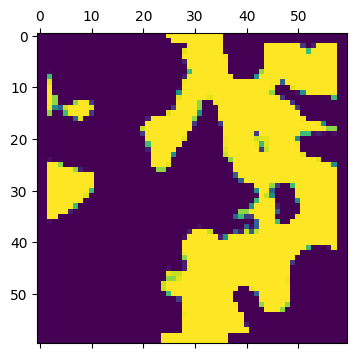

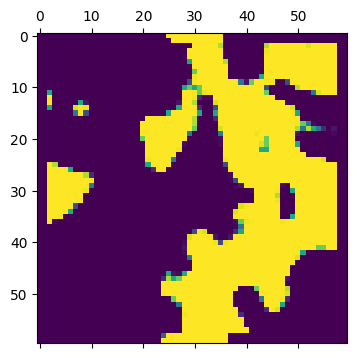

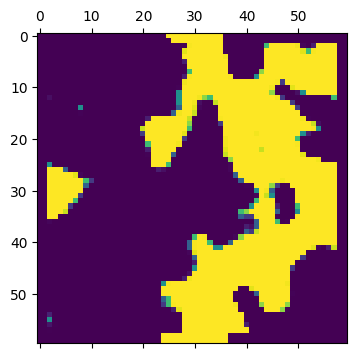

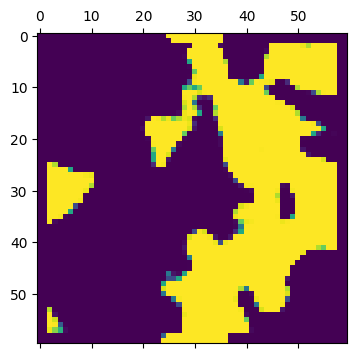

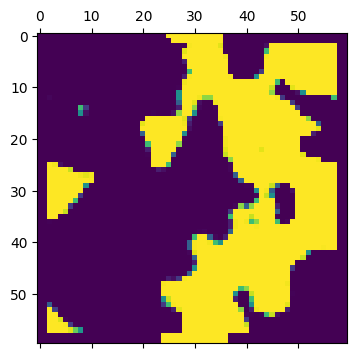

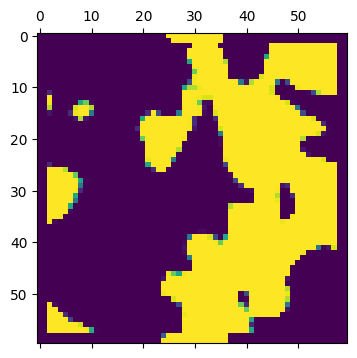

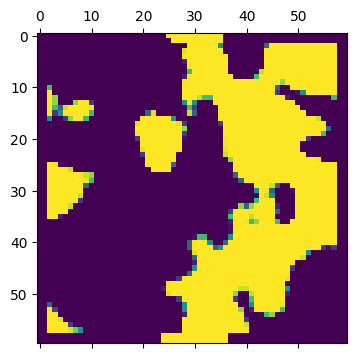

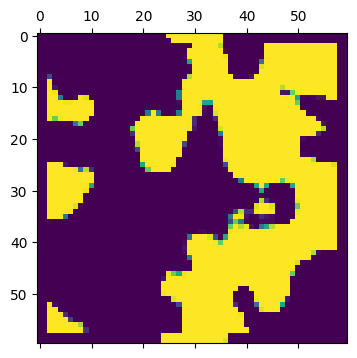

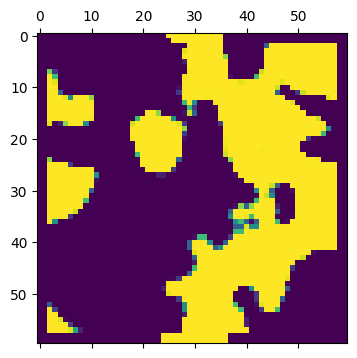

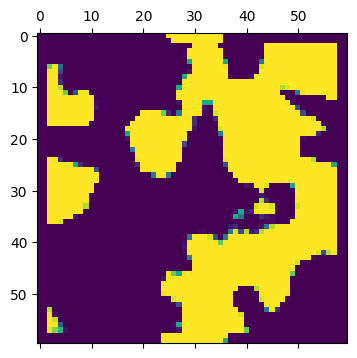

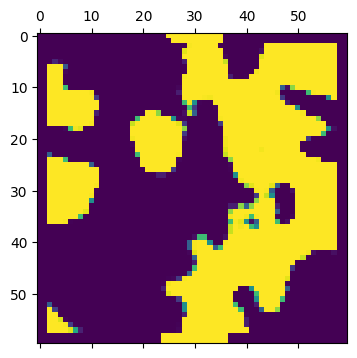

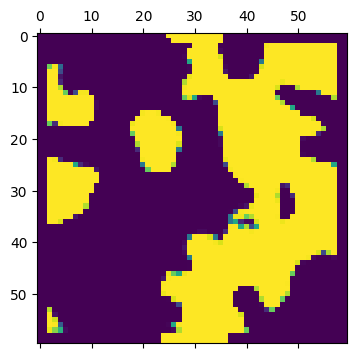

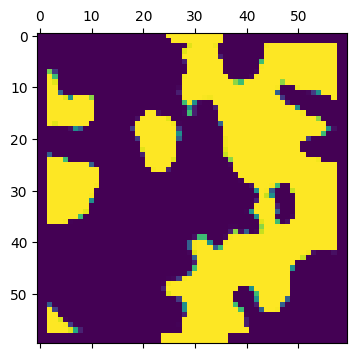

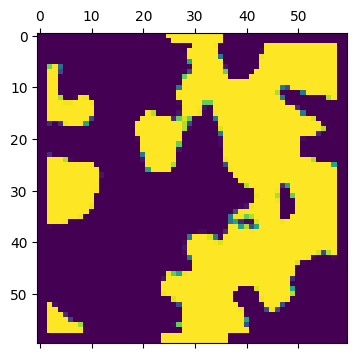

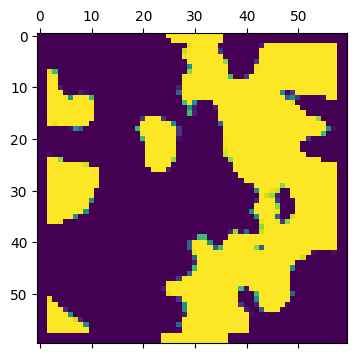

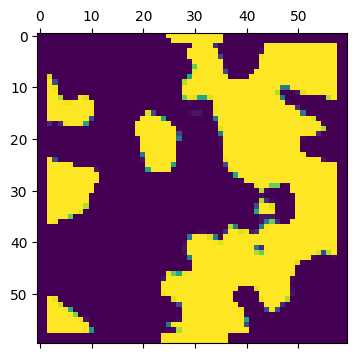

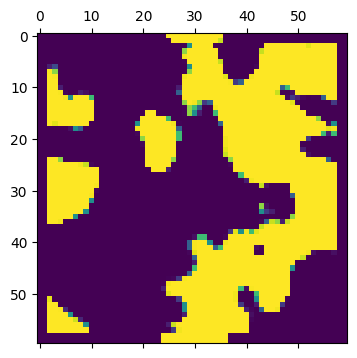

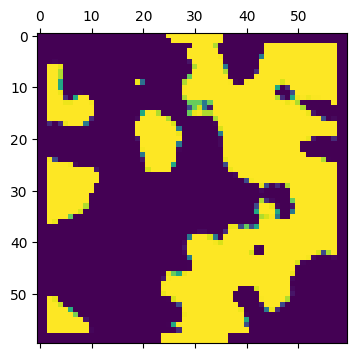

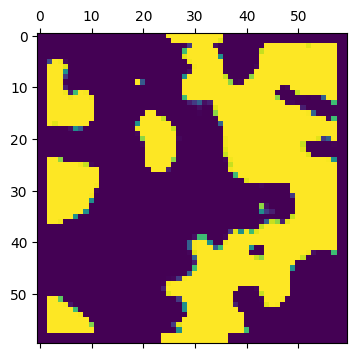

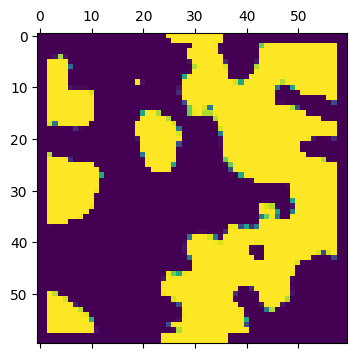

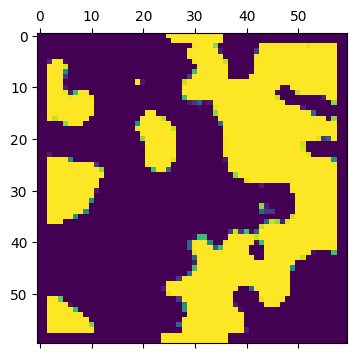

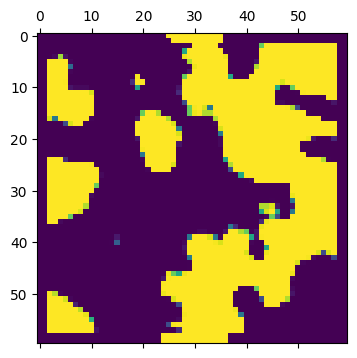

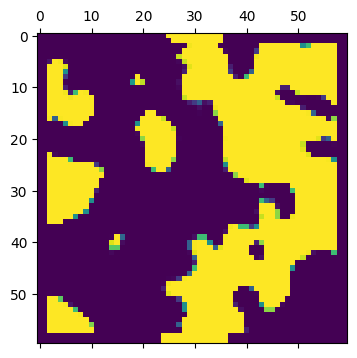

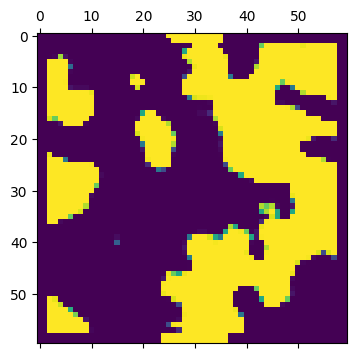

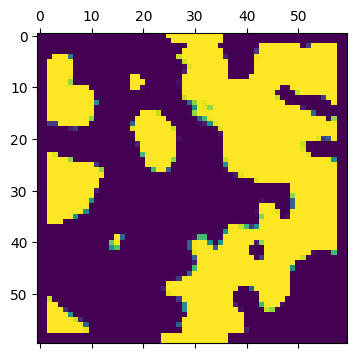

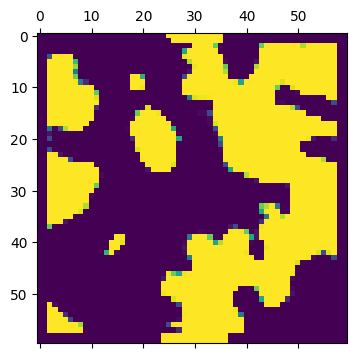

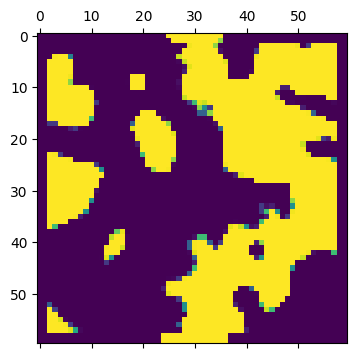

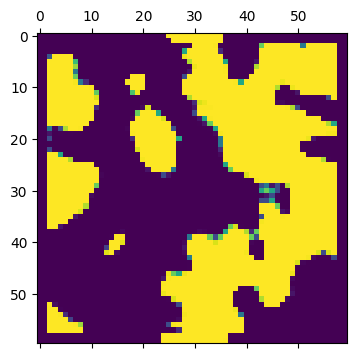

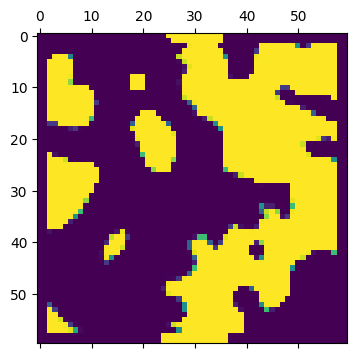

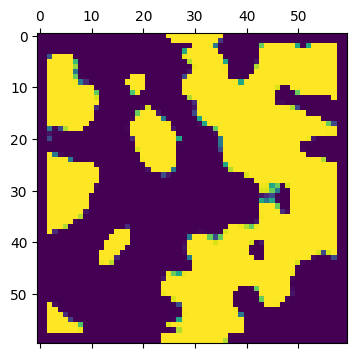

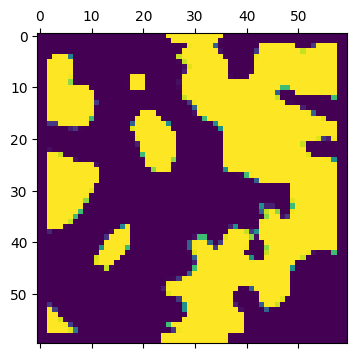

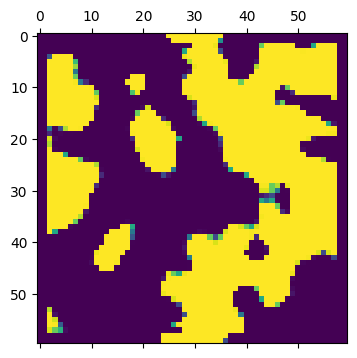

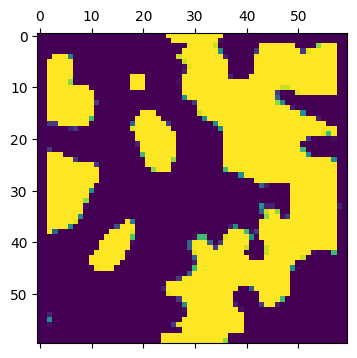

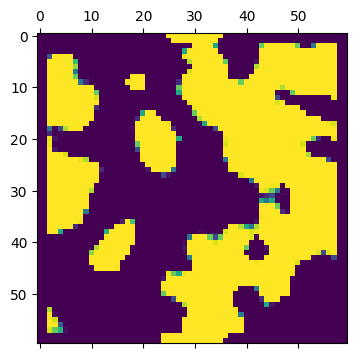

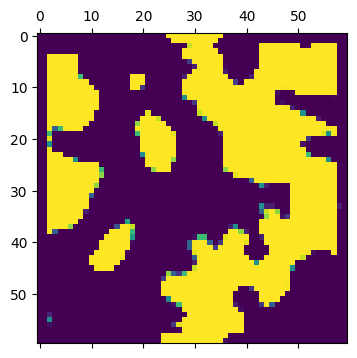

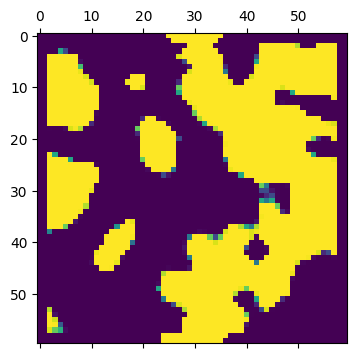

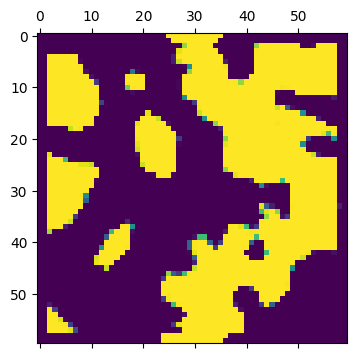

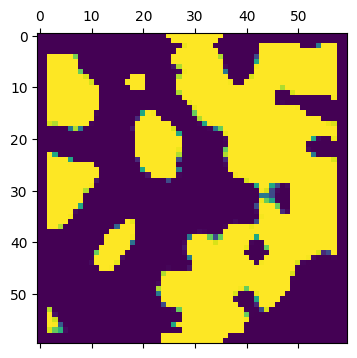

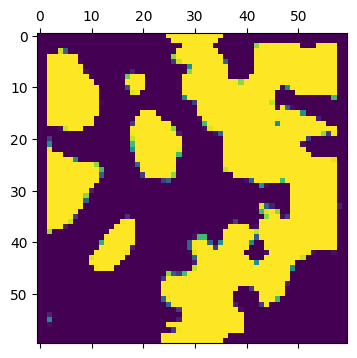

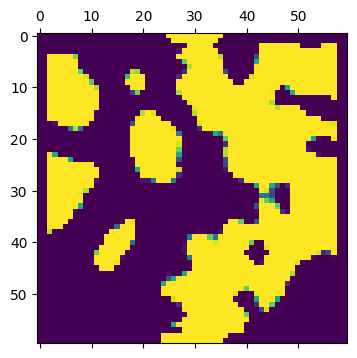

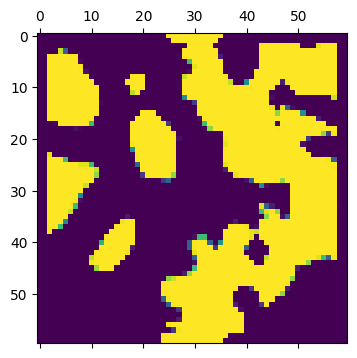

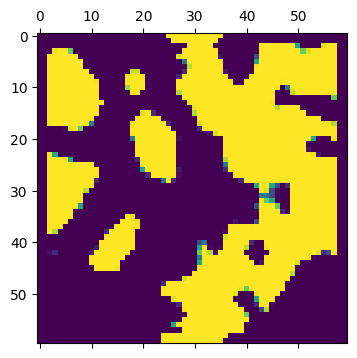

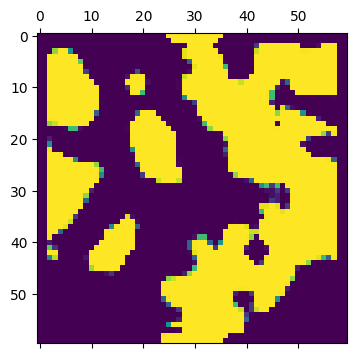

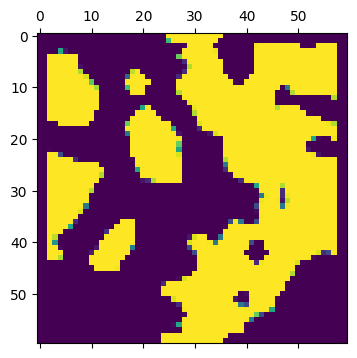

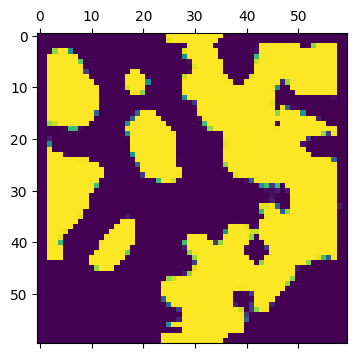

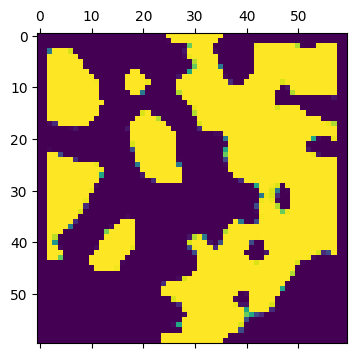

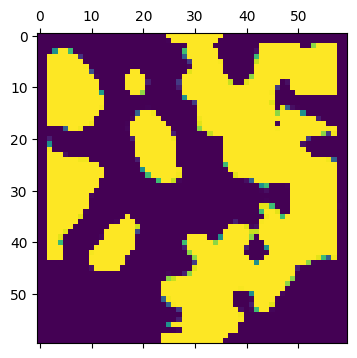

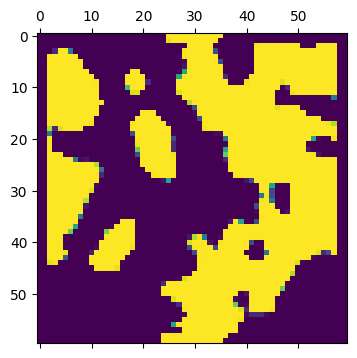

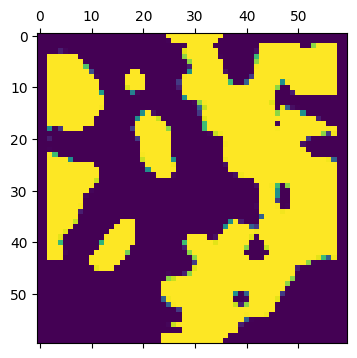

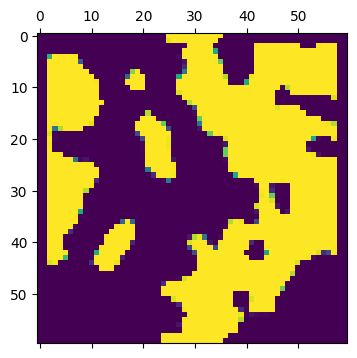

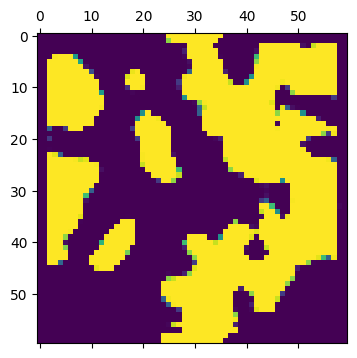

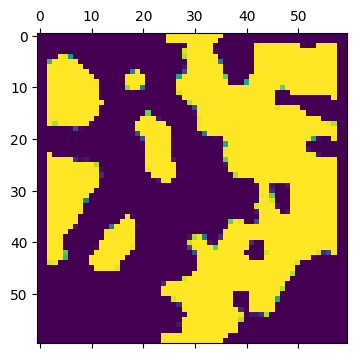

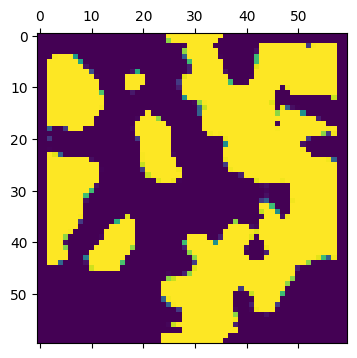

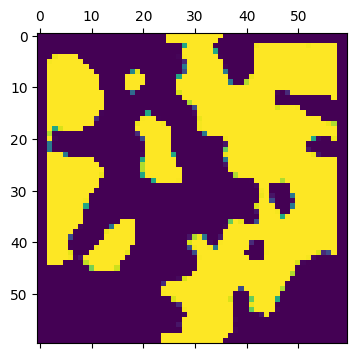

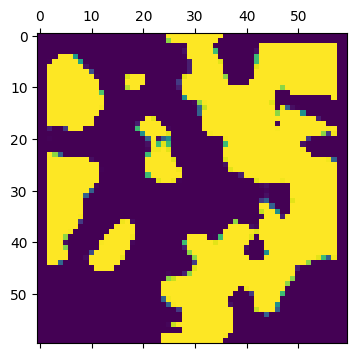

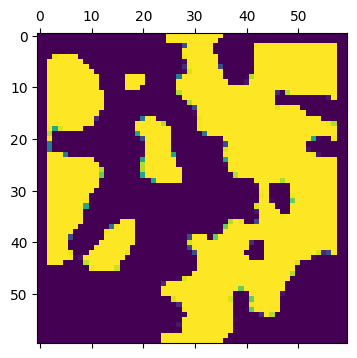

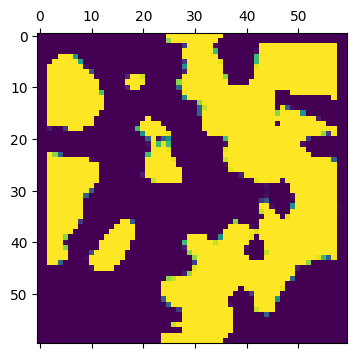

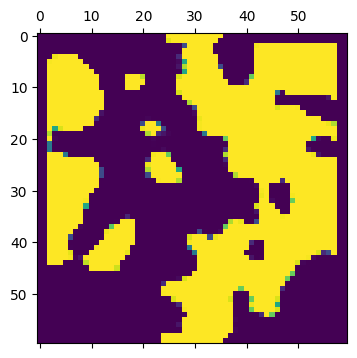

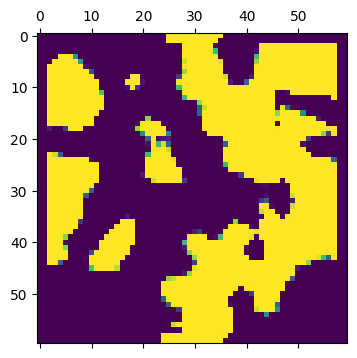

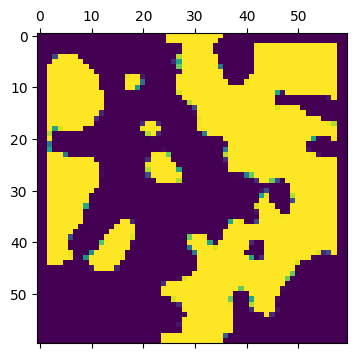

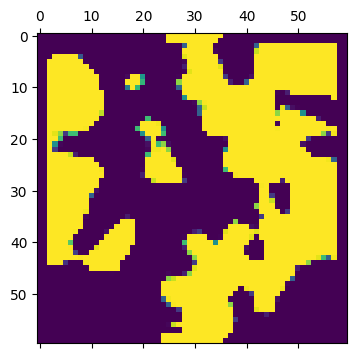

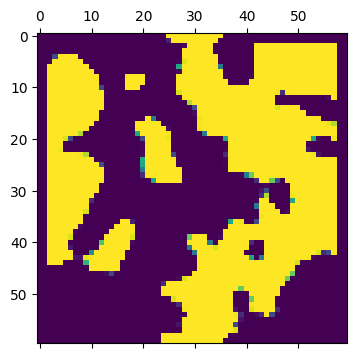

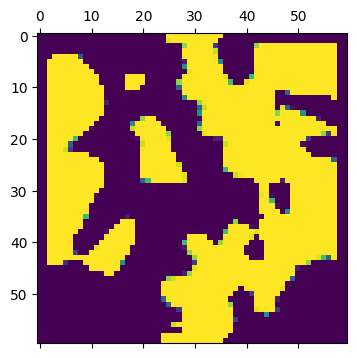

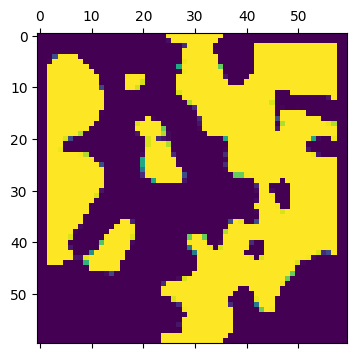

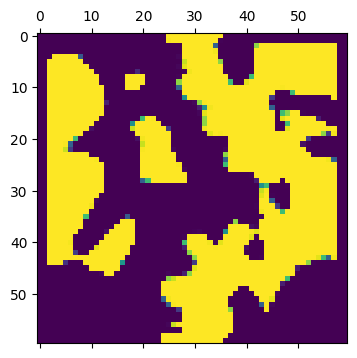

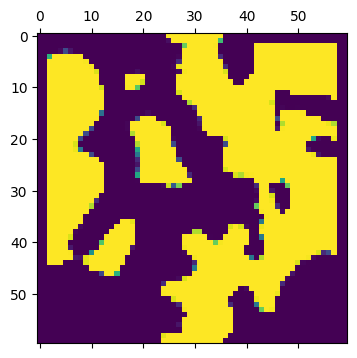

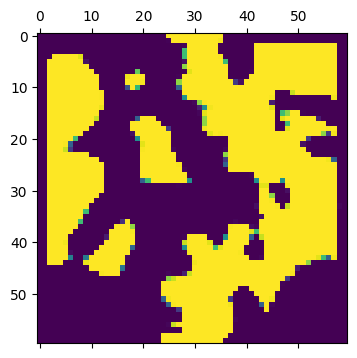

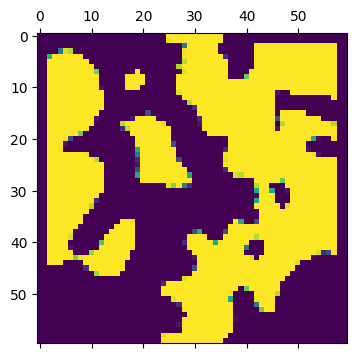

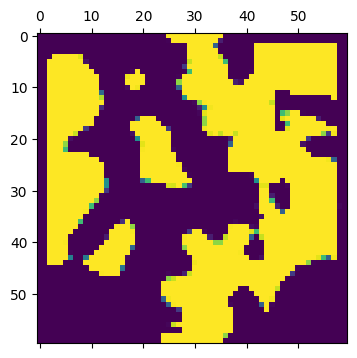

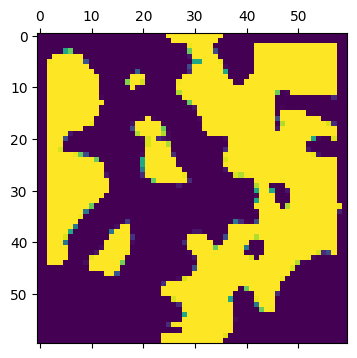

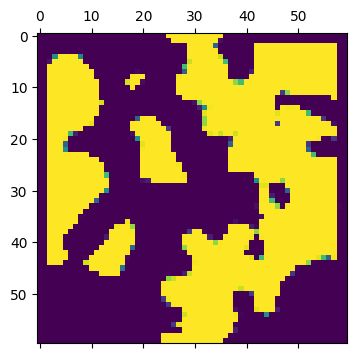

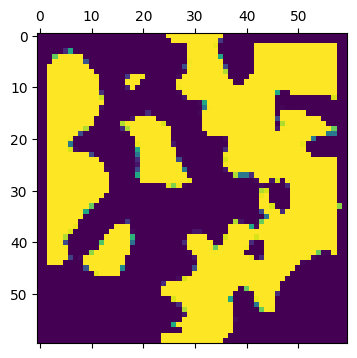

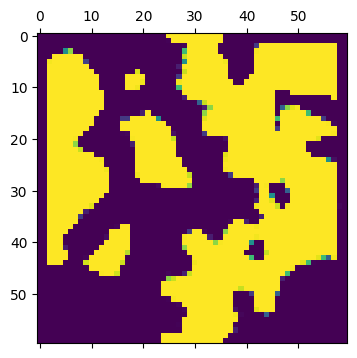

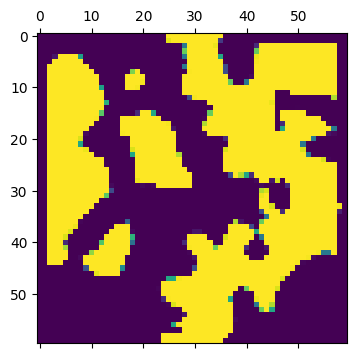

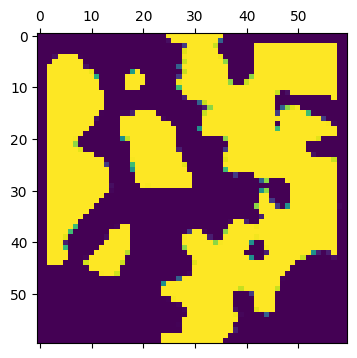

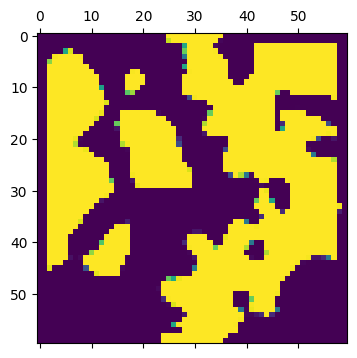

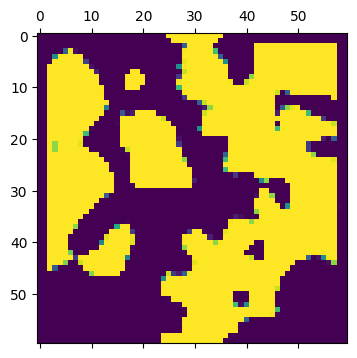

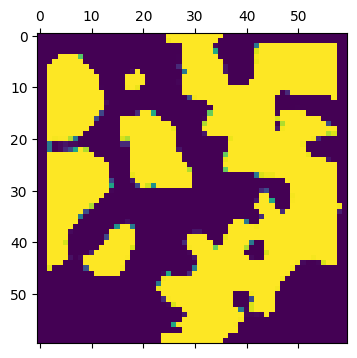

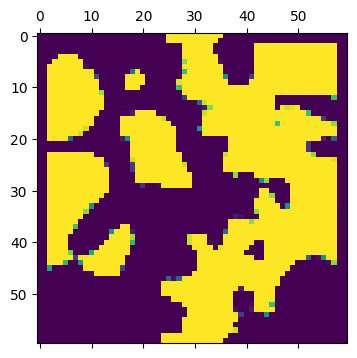

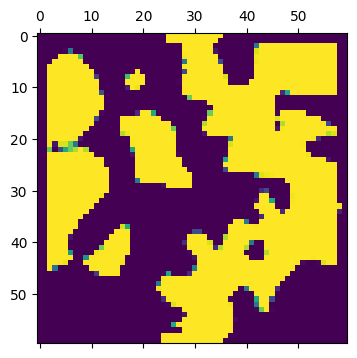

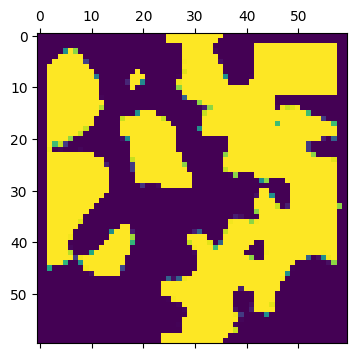

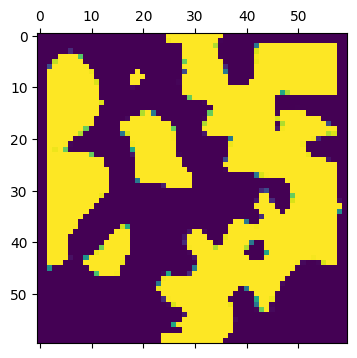

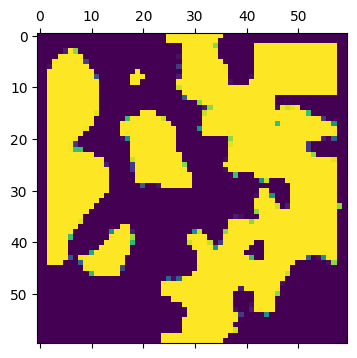

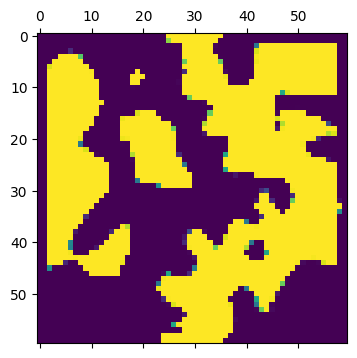

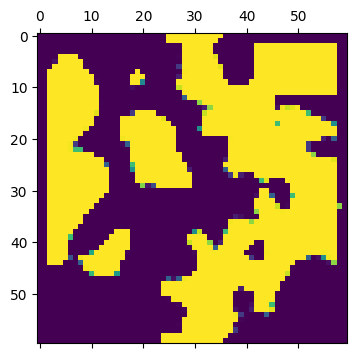

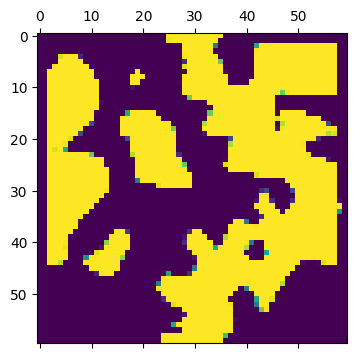

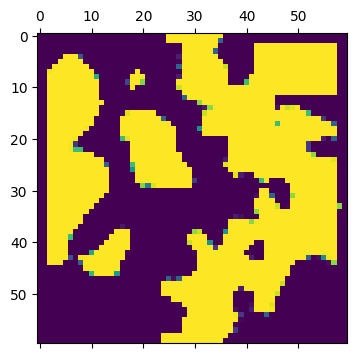

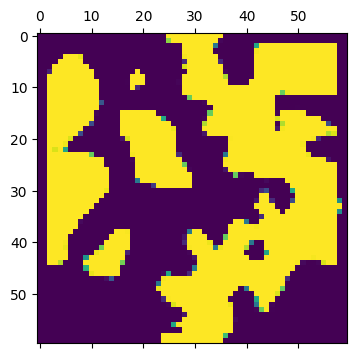

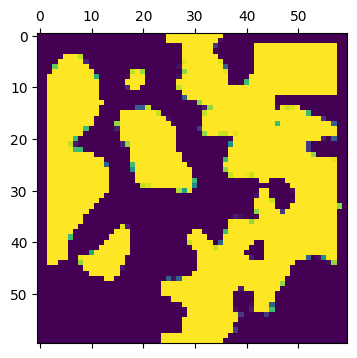

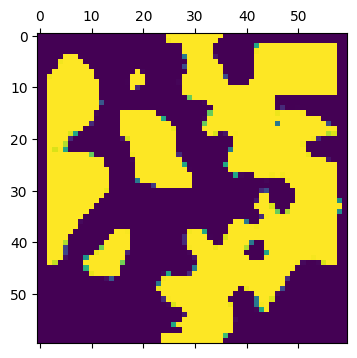

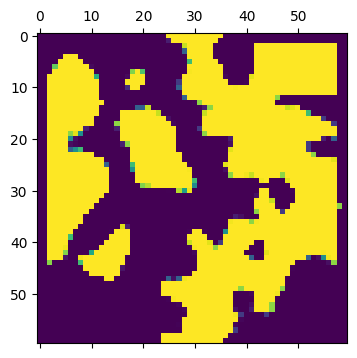

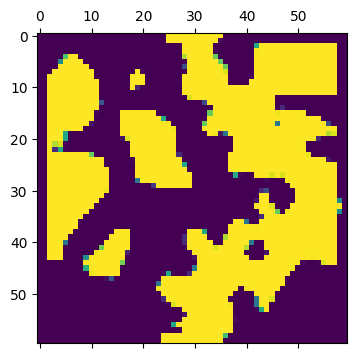

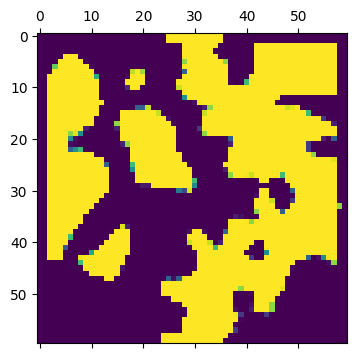

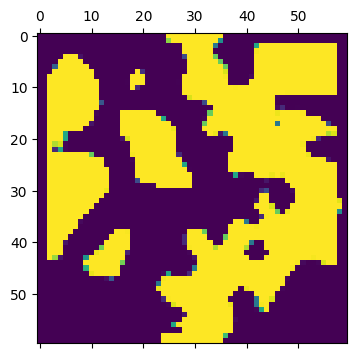

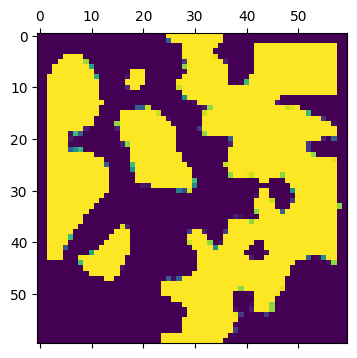

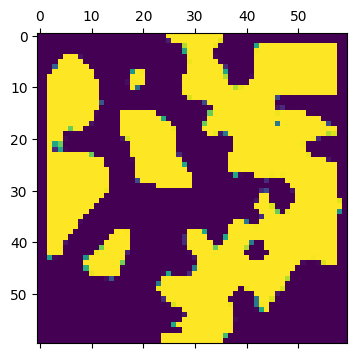

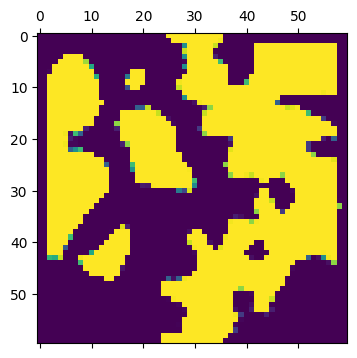

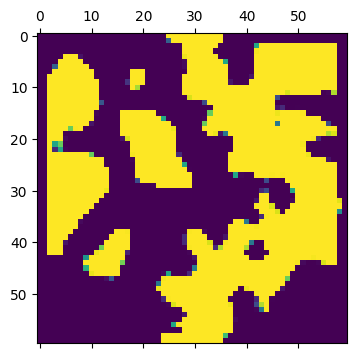

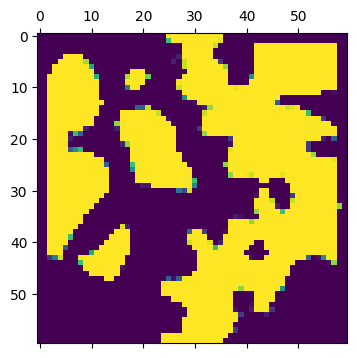

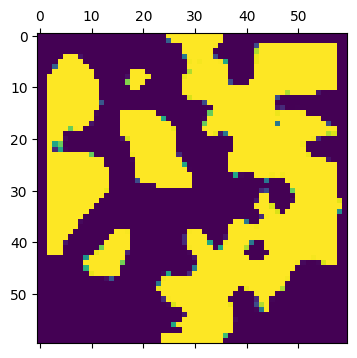

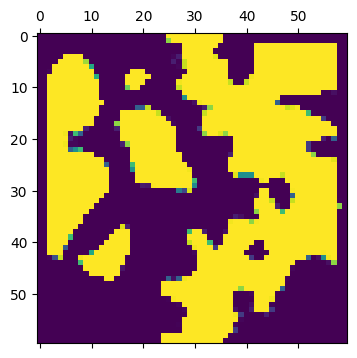

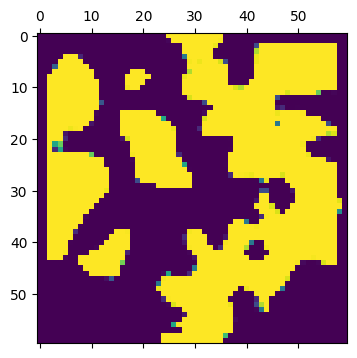

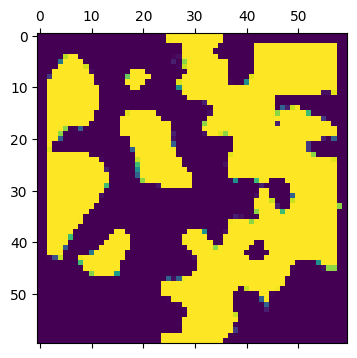

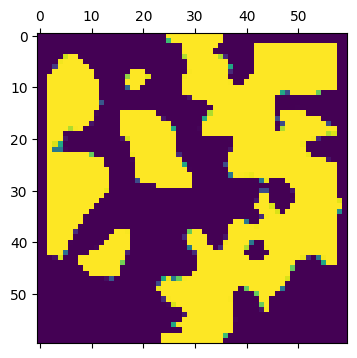

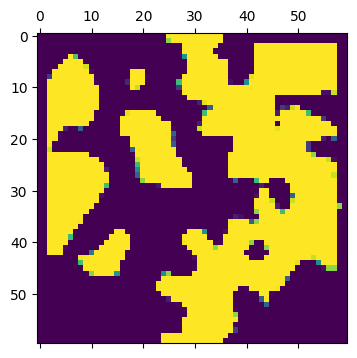

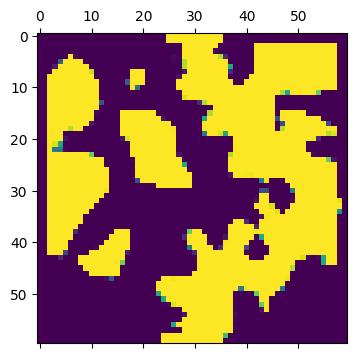

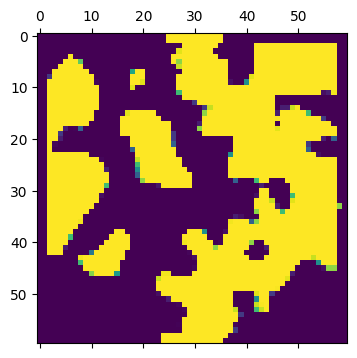

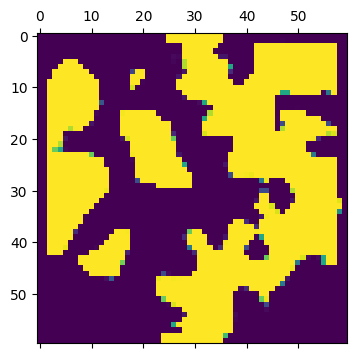

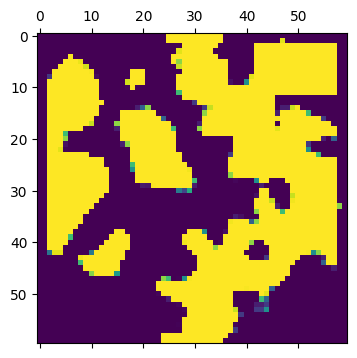

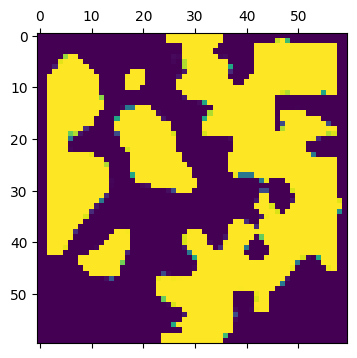

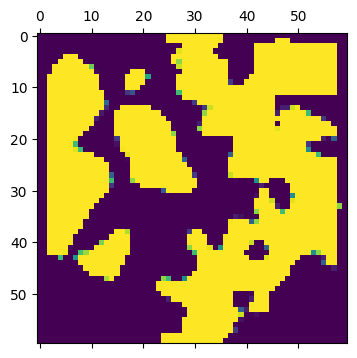

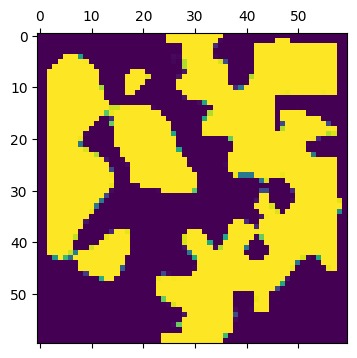

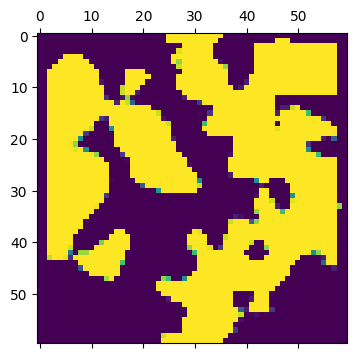

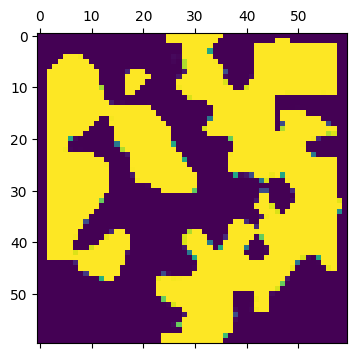

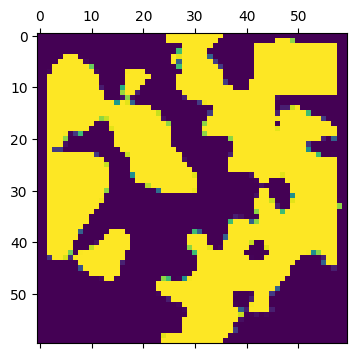

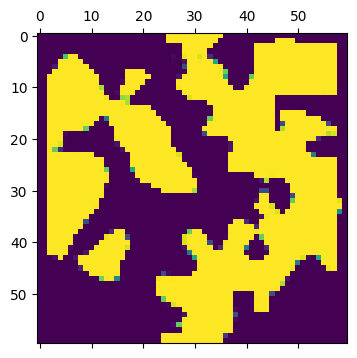

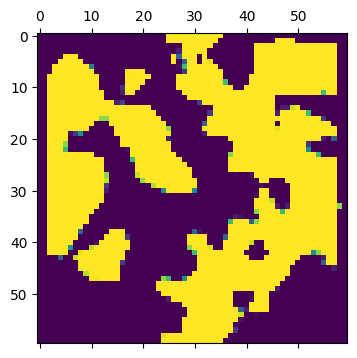

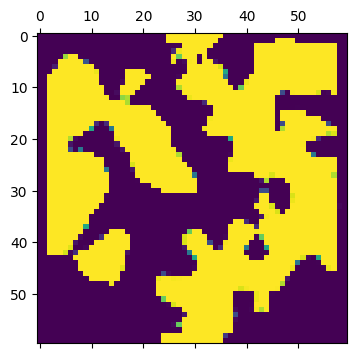

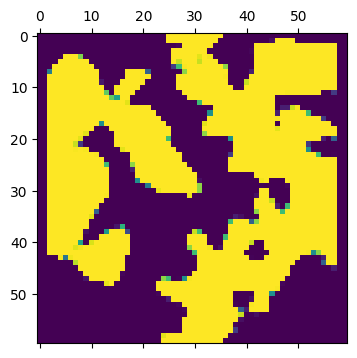

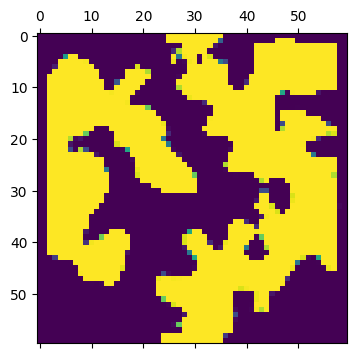

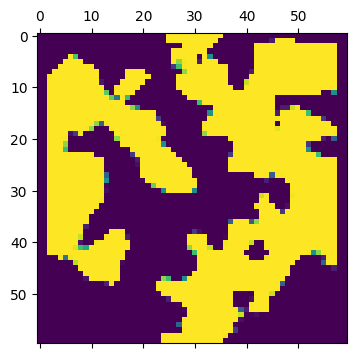

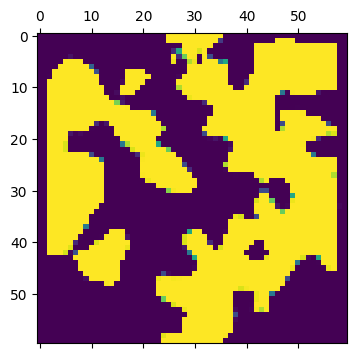

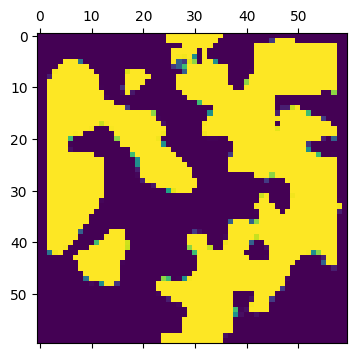

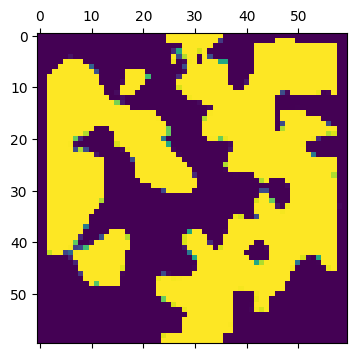

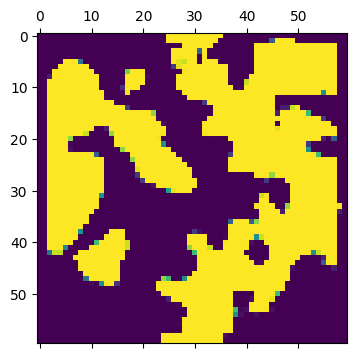

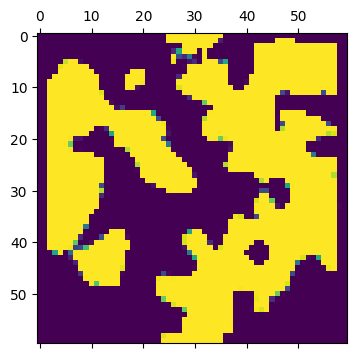

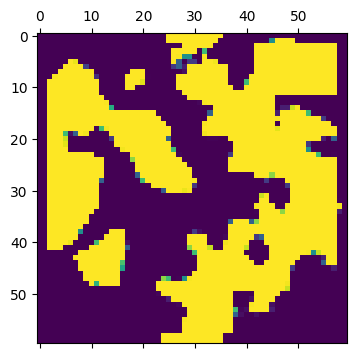

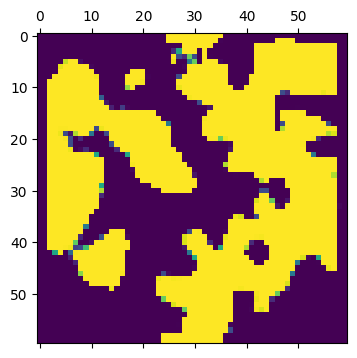

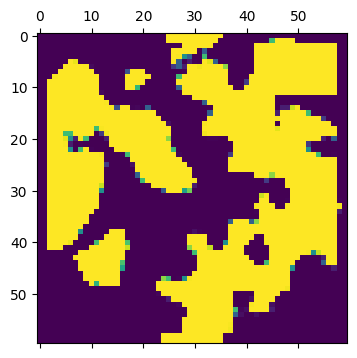

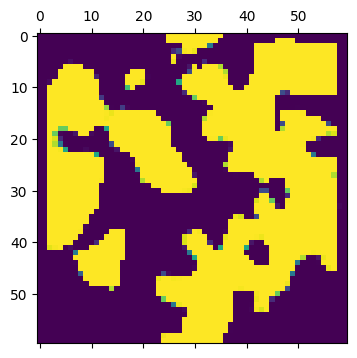

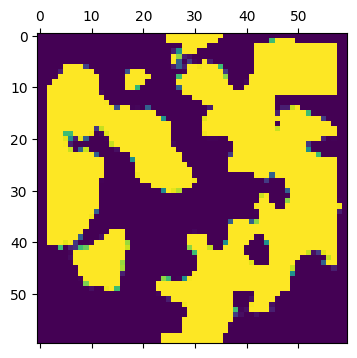

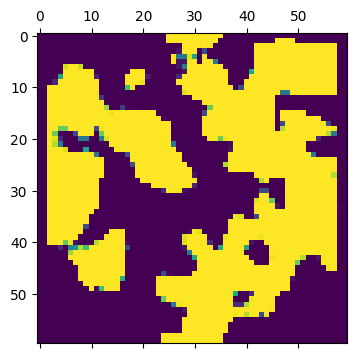

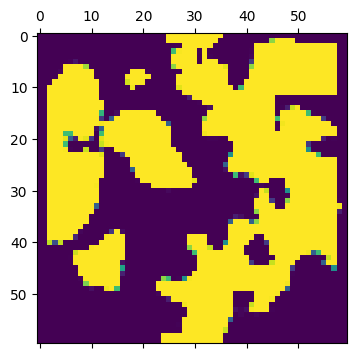

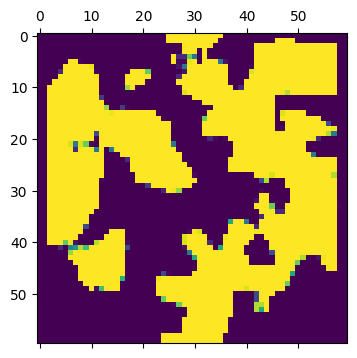

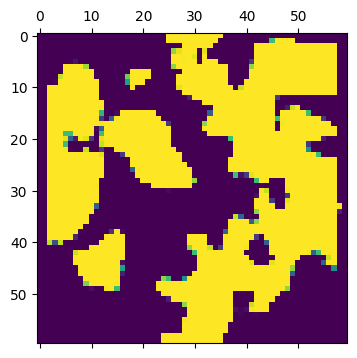

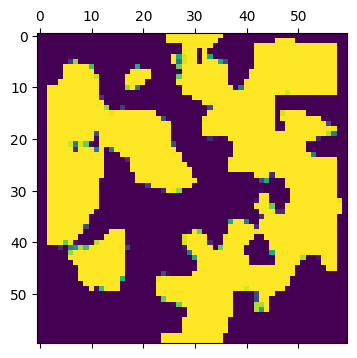

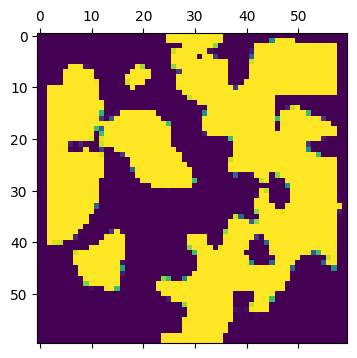

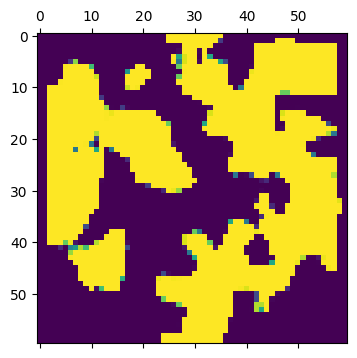

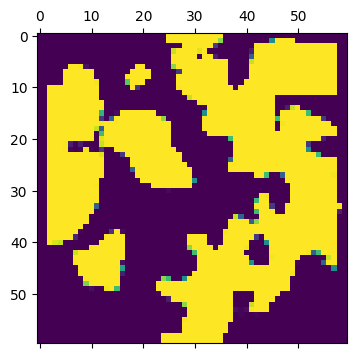

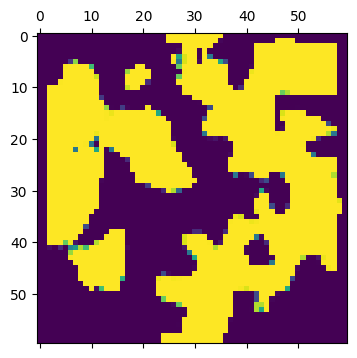

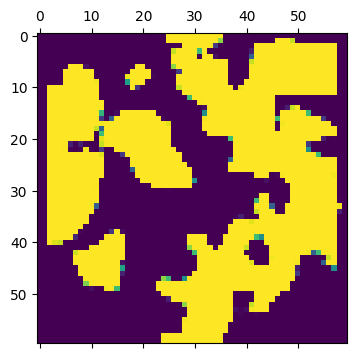

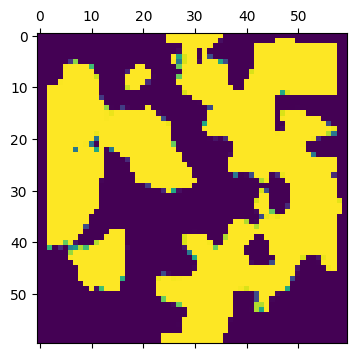

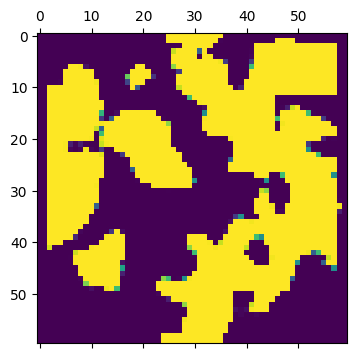

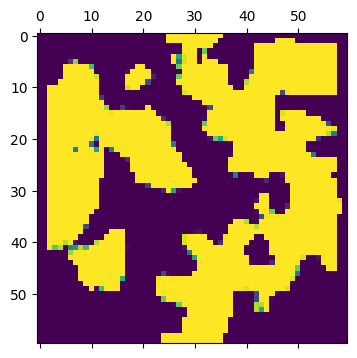

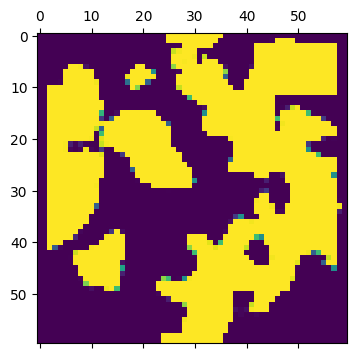

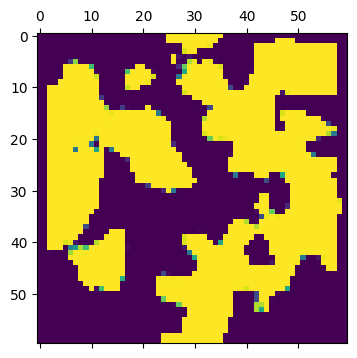

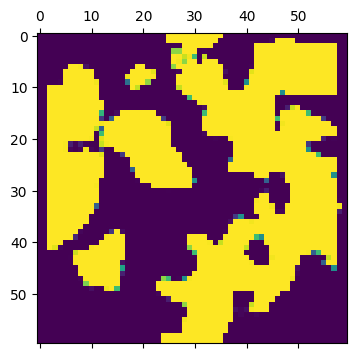

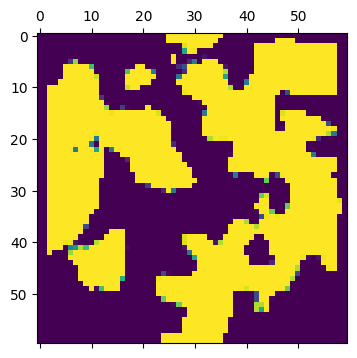

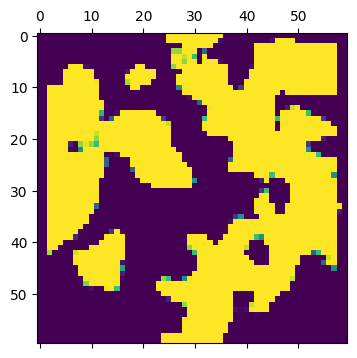

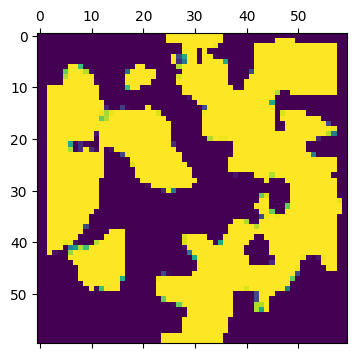

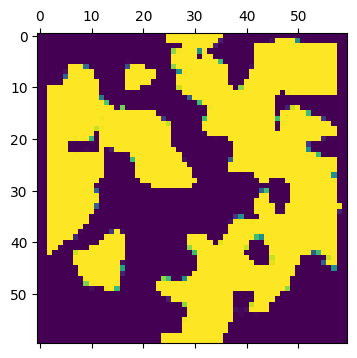

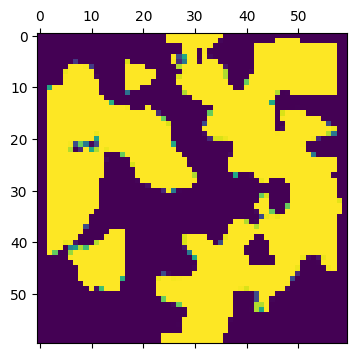

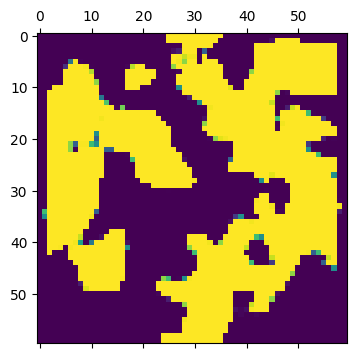

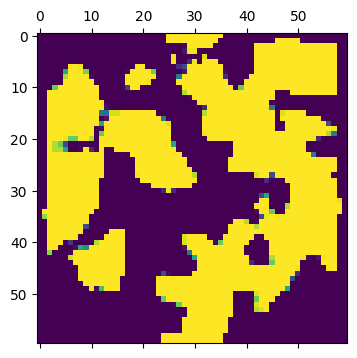

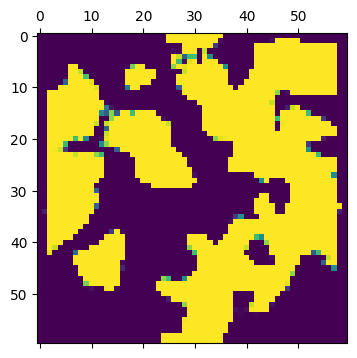

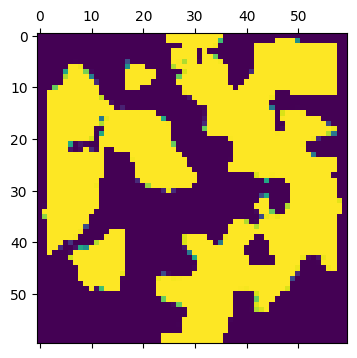

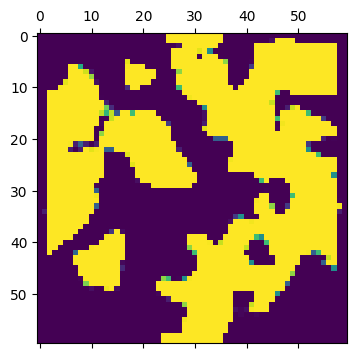

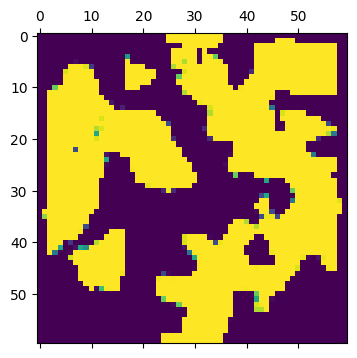

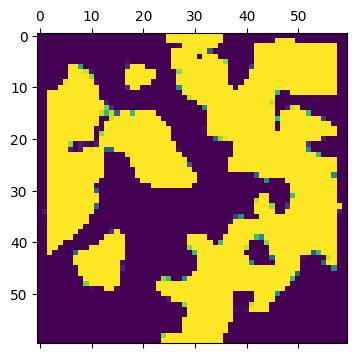

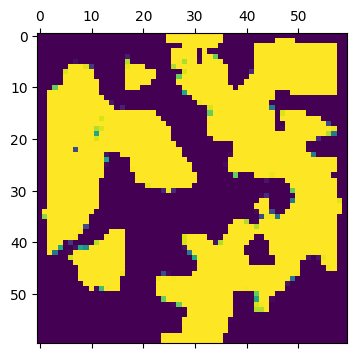

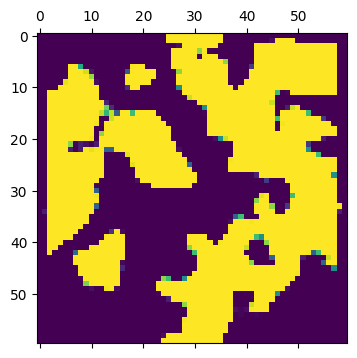

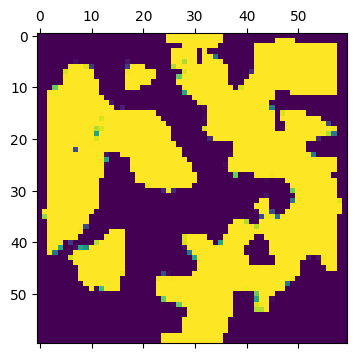

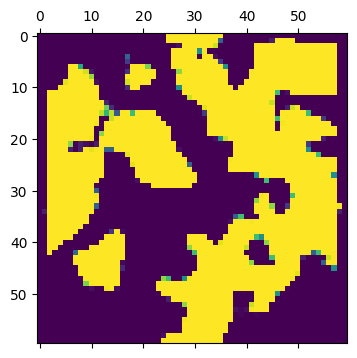

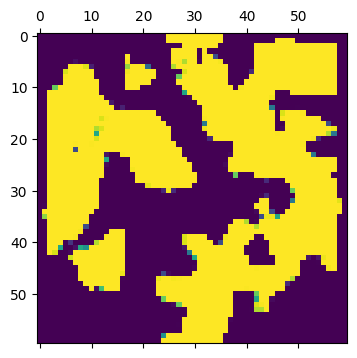

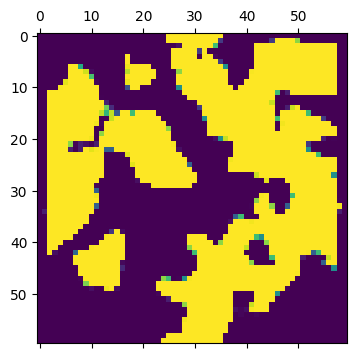

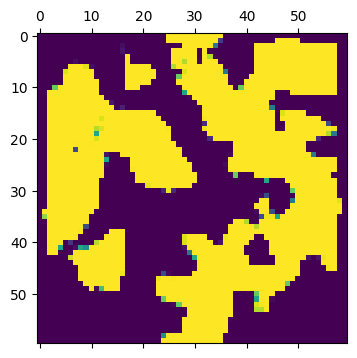

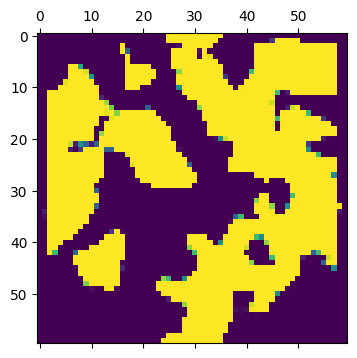

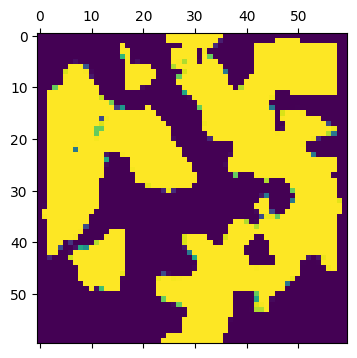

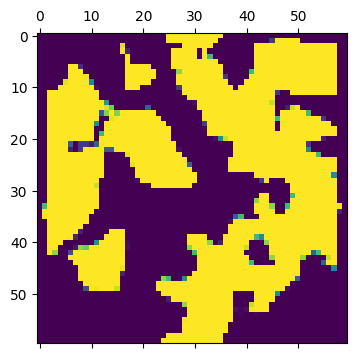

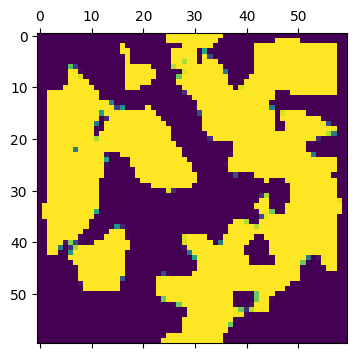

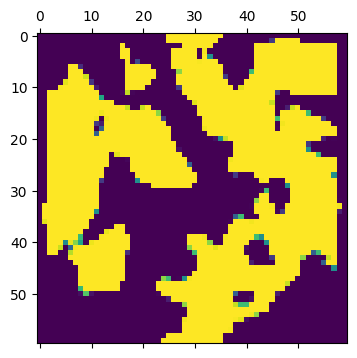

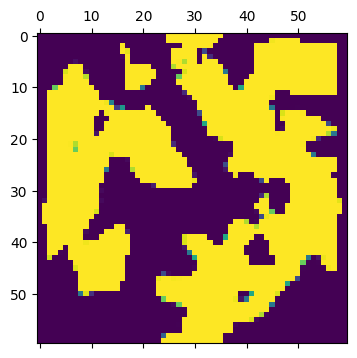

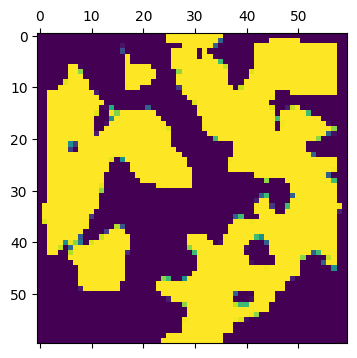

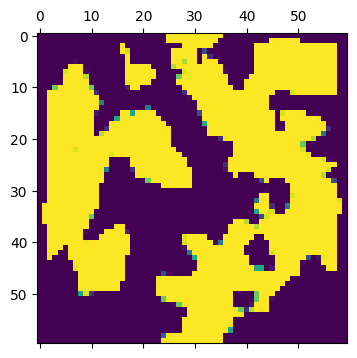

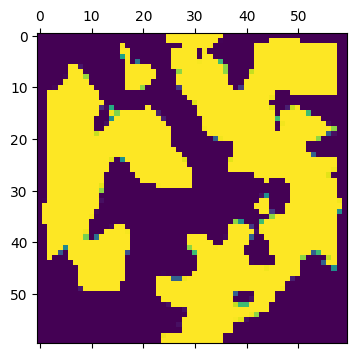

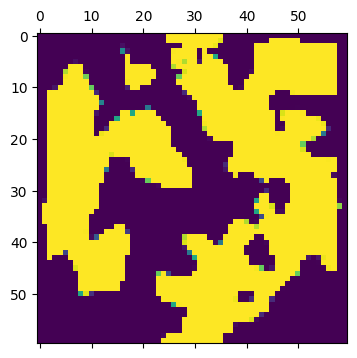

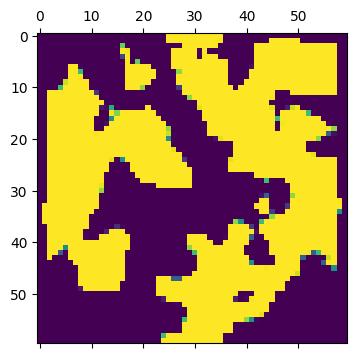

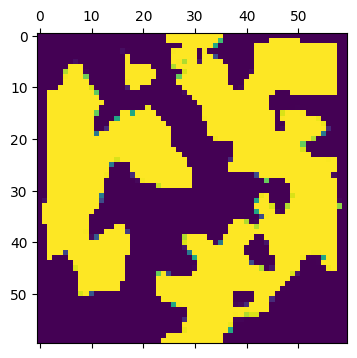

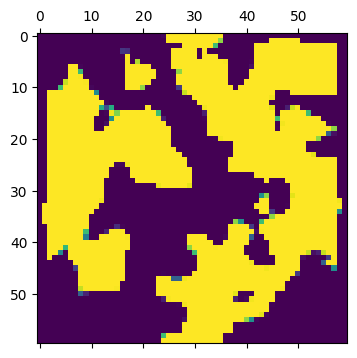

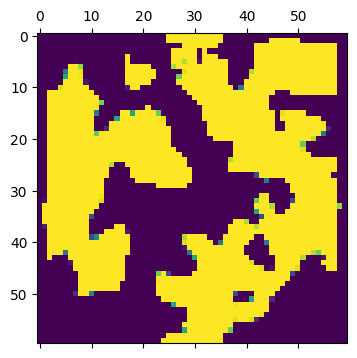

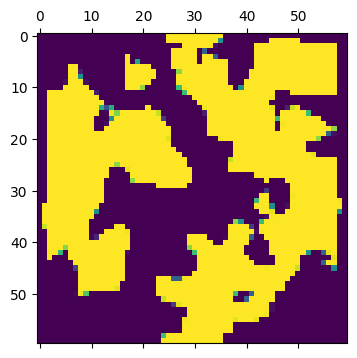

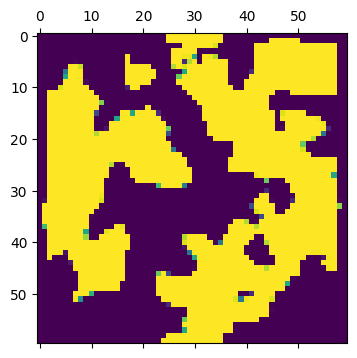

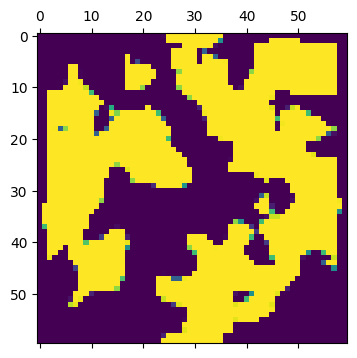

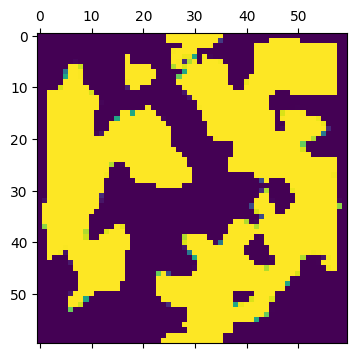

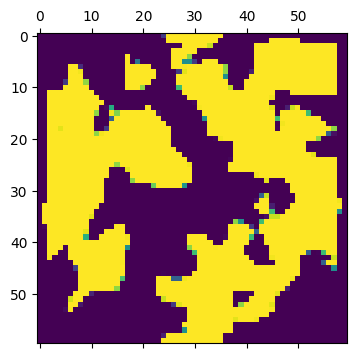

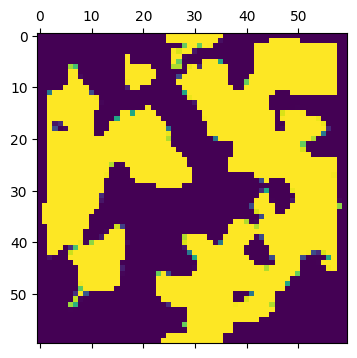

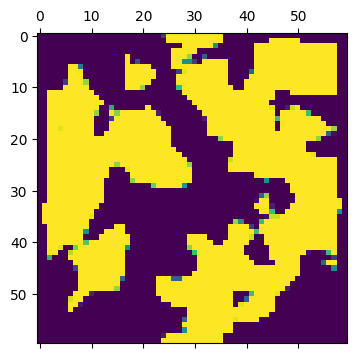

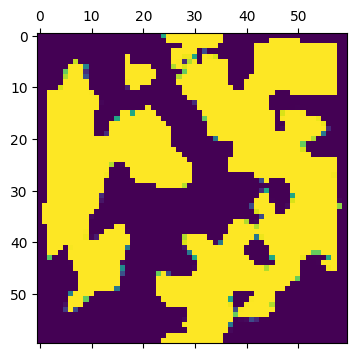

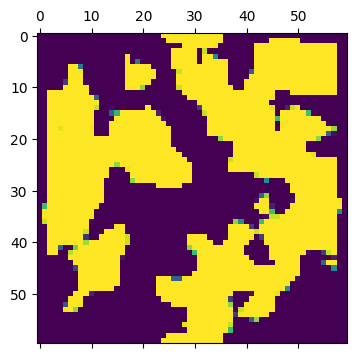

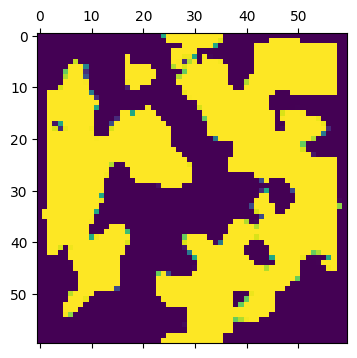

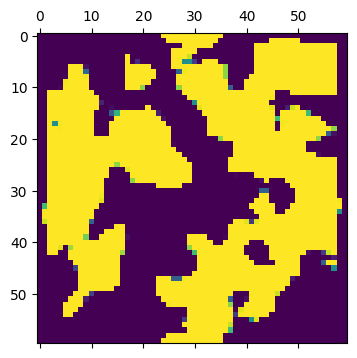

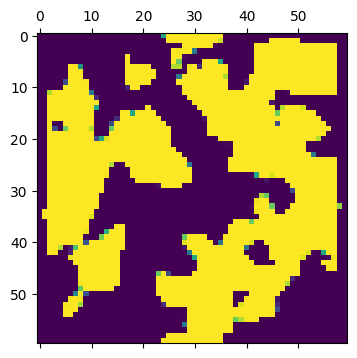

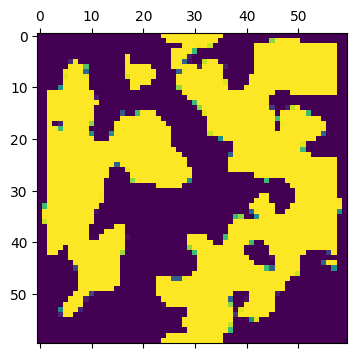

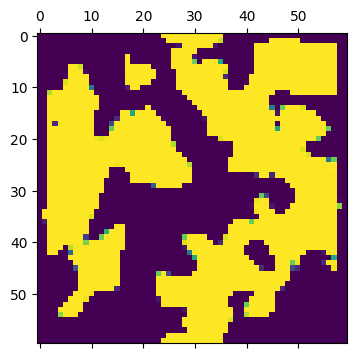

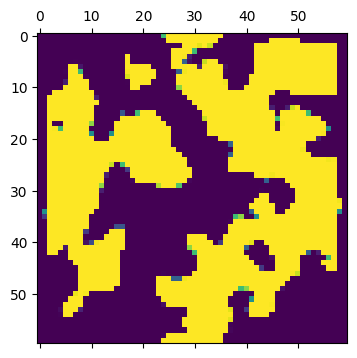

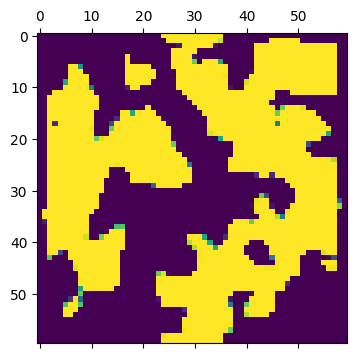

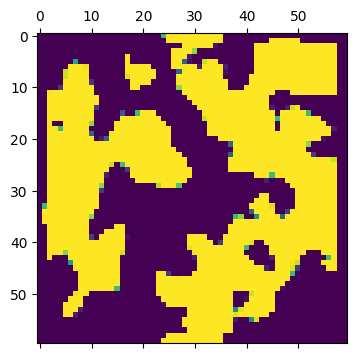

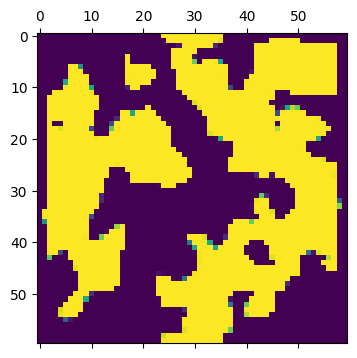

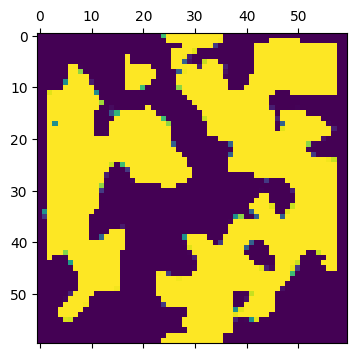

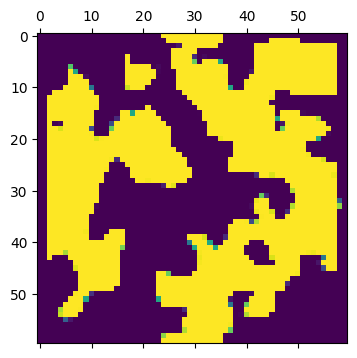

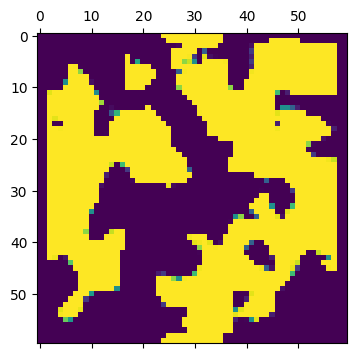

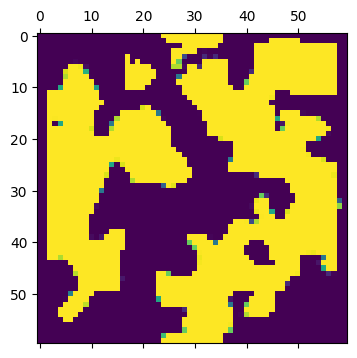

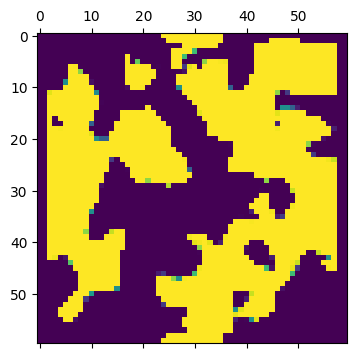

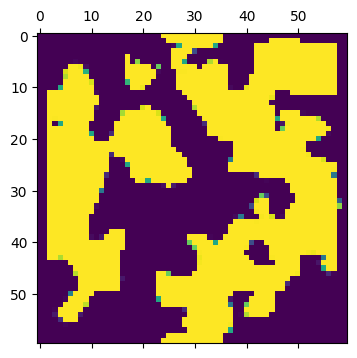

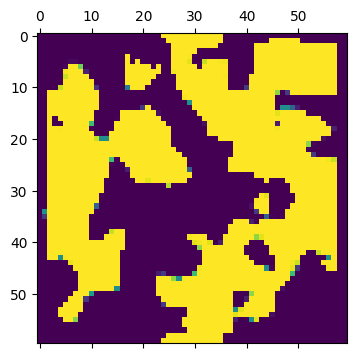

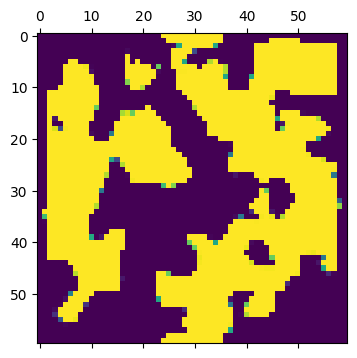

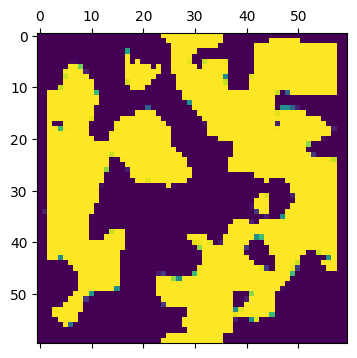

In [ ]:
for i in es:
  i=np.reshape(i,(60,60))
  plt.matshow(i)

#Binary Variational Autoencoder

In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np

import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
## MNIST dataset

(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()


def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


train_size = 60000
batch_size = 32
test_size = 10000

train_images=tf.reshape(train_images,(60000,28,28))
train_dataset=tf.reshape(train_images,(len(train_images),1,784))
train_dataset2=train_dataset[:500]



1.   Auto encoder works fine (objective: reconstruction loss)
2.   Connected Autoencoder also works fine but it took lot more epochs for it to be working as compared to case1 (objective: reconstruction loss)
3.   Connected Autoencoe with middle layer works fine(objective: reconstruction loss)
4.   Connected Autoencoder with middle layer and KL divergence did just okaish. It took a lot more epochs(100) to get the right reconstruction (objective: reconstruction loss + KL divergence) 
5.   Connected Autoencoder with middle layer and a stochastic node(objective: reconstruction loss)
6.   Connected Autoencoder with middle layer and stochastic node and KL(objective: reconstruction loss + KL divergence)


7. bVAE whith Gumbell. It actually did decent in the reconstruction, even with the stochastic part. (objective: reconstruction)




IT FINALLY WORKS (lambd=0.05,0.0001xKL, 0.001xKL)!!!!!
BUT IT DIDNT WORK WITH 0.01xKL


200, 100, 120, 100, 200 and 0.001*KL works okaish fro bVAE



WHAT MIGHT HAVE GONE WRONG WAS THAT THE KL DIVERGENCE WAS GIVEN A LOT OF WEIGHT. THE a(x) VALUE DOESN'T HAVE TO BE EXACTLY 0.5 BUT CLOSE ENOUGH. 

Read https://github.com/christianversloot/machine-learning-articles/blob/main/what-is-a-variational-autoencoder-vae.md 



## AUTOENCODER AND THE CONNECTED AUTOENCODER WORKS FINE. 

In [ ]:
class bVAE(tf.keras.Model):
  """Binary variational autoencoder."""

  def __init__(self, latent_dim):
    super(bVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(3600,)),
            tf.keras.layers.Dense(units=512, activation="relu"),
            #tf.keras.layers.Dropout(.4, input_shape=(200,)),
            tf.keras.layers.Dense(units=256, activation="relu"),
            #tf.keras.layers.Dropout(.4, input_shape=(100,)),
            tf.keras.layers.Dense(units=latent_dim,activation='sigmoid')
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=256, activation="relu"),
            #tf.keras.layers.Dropout(.4, input_shape=(100,)),
            tf.keras.layers.Dense(units=512, activation="relu"),
            #tf.keras.layers.Dropout(.4, input_shape=(200,)),
            tf.keras.layers.Dense(units=3600, activation='sigmoid')
        ]
    )

  @tf.function


  def encode(self, x):
    a= self.encoder(x)
    return a

  def gumbell_reparam(self,a,lambd):
    #a is the output from the encoder sigmoid, so value is in range (0,1)
    u=tf.clip_by_value(tf.random.uniform(shape=tf.shape(a),minval=0, maxval=1,seed=time.time()),1e-10,1.0-(1e-7))
    a=tf.clip_by_value(a,1e-10,1.0-(1e-7))
    x=(tf.math.log(a/(1-a))+tf.math.log(u/(1-u)))/lambd
    x=tf.math.sigmoid(x)
    return x

  def gumbel_softmax(self,a,lambd):
    a=tf.clip_by_value(a,1e-10, 1.0-1e-7)
    u1=tf.clip_by_value(tf.random.uniform(shape=tf.shape(a),minval=1e-10, maxval=1.0-1e-7,seed=time.time()),1e-10,1.0-(1e-7))
    u2=tf.clip_by_value(tf.random.uniform(shape=tf.shape(a),minval=1e-10, maxval=1.0-1e-7,seed=time.time()),1e-10,1.0-(1e-7))
    x=tf.math.exp((tf.math.log(a+1e-10)-tf.math.log(-tf.math.log(u1+1e-10)+1e-10))/lambd) / (tf.math.exp((tf.math.log(a+1e-10)-tf.math.log(-tf.math.log(u1+1e-10)+1e-10))/lambd) + tf.math.exp((tf.math.log(1.0-a+1e-10)-tf.math.log(-tf.math.log(u2+1e-10)+1e-10))/lambd))
    return x

#just gave lambd=0 and removed the random u from gumbel to get binary 
  def binary_activation(self,a):
    
    #a is the output from the encoder sigmoid, so value is in range (0,1)
    u=tf.clip_by_value(tf.random.uniform(shape=tf.shape(a),minval=0, maxval=1,seed=time.time()),1e-10,1.0-(1e-7))
    a=tf.clip_by_value(a,1e-10,1.0-(1e-7))
    x=(tf.math.log(a/(1-a)))/0.00000111111111
    x=tf.math.sigmoid(x)
    return x


  def decode(self, b, apply_sigmoid=False):
    x_hat=self.decoder(b)
    return x_hat

  def forward_pass(self,x,lambd):
    a=self.encode(x,lambd)
    b=self.gumbell_reparam(a,lambd)
    x_hat=self.decode(b)
    return x_hat

  def call(self,x):
    y=self.forward_pass(x,lambd)
    return y
###############################################################################################

'''
class AE(tf.keras.Model):
  """Autoencoder."""

  def __init__(self, latent_dim):
    super(AE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(784,)),
            tf.keras.layers.Dense(units=100, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            #tf.keras.layers.Dropout(.1, input_shape=(512,)),
            tf.keras.layers.Dense(units=50, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            #tf.keras.layers.Dropout(.4, input_shape=(256,)),
            tf.keras.layers.Dense(units=latent_dim,activation='relu'),
            
            tf.keras.layers.Dense(units=50, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            #tf.keras.layers.Dropout(.4, input_shape=(256,)),
            tf.keras.layers.Dense(units=100, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            #tf.keras.layers.Dropout(.4, input_shape=(512,)),
            tf.keras.layers.Dense(units=784, activation='sigmoid')
        ]
    )


######################################################################################################
class AE_connected(tf.keras.Model):
  """Autoencoder2"""

  def __init__(self, latent_dim):
    super(AE_connected, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(784,)),
            
            #tf.keras.layers.Dropout(.4, input_shape=(512,)),
            tf.keras.layers.Dense(units=200, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            tf.keras.layers.Dense(units=100, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            #tf.keras.layers.Dropout(.4, input_shape=(256,)),
            tf.keras.layers.Dense(units=latent_dim,activation='sigmoid')
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=100, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            tf.keras.layers.Dense(units=200, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            #tf.keras.layers.Dropout(.4, input_shape=(256,)),
            
            #tf.keras.layers.Dropout(.4, input_shape=(512,)),
            tf.keras.layers.Dense(units=784, activation='sigmoid')
        ]
    )

  def random(self,x):
    x=tf.clip_by_value(tf.random.uniform(shape=tf.shape(x),minval=0, maxval=1,seed=time.time()),1e-10,1.0-(1e-7))
    return x

  def middle_layer(self,x):
    u=tf.clip_by_value(tf.random.uniform(shape=tf.shape(x),minval=0, maxval=1,seed=time.time()),1e-10,1.0-(1e-7))
    
    
    x=tf.clip_by_value(x,1e-10,1.0-1e-7)
    r=tf.math.log((x/(1-x))+u)
    return r


'''


'\nclass AE(tf.keras.Model):\n  """Autoencoder."""\n\n  def __init__(self, latent_dim):\n    super(AE, self).__init__()\n    self.latent_dim = latent_dim\n    self.encoder = tf.keras.Sequential(\n        [\n            tf.keras.layers.InputLayer(input_shape=(784,)),\n            tf.keras.layers.Dense(units=100, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),\n            #tf.keras.layers.Dropout(.1, input_shape=(512,)),\n            tf.keras.layers.Dense(units=50, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),\n            #tf.keras.layers.Dropout(.4, input_shape=(256,)),\n            tf.keras.layers.Dense(units=latent_dim,activation=\'relu\'),\n            \n            tf.keras.layers.Dense(units=50, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),\n            #tf.keras.layers.Dropout(.4, input_shape=(256,)),\n            tf.keras.layers.Dense(units=100, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),\n            #tf.keras.layers.Dropout(.4, input_shape=(512,)),\n          

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def compute_loss(model,x):
  a=tf.clip_by_value(model.encoder(x),1e-10,1.0-1e-7)
  b=tf.clip_by_value(model.gumbell_reparam(a,lambd),1e-10,1.0-1e-7)
  bb=tf.grad_pass_through(model.binary_activation)(b)
  #straight through gumbel softmax
  


  x_hat=model.decoder(bb)
  #reconstruction_loss=tf.math.reduce_mean(tf.math.pow(x-x_hat,2))
  bce = tf.keras.losses.BinaryCrossentropy()
  reconstruction_loss=bce(x,x_hat)#binary cross entropy
  KL_loss=(tf.math.reduce_sum(tf.math.multiply(a,tf.math.log(a))+tf.math.multiply(1.0-a,tf.math.log(1.0-a))))+tf.math.multiply(tf.cast(latent_dim, tf.float32),tf.math.log(2.0))#this equation is correct

  total_loss=(250*reconstruction_loss+KL_loss)
  return total_loss,reconstruction_loss,KL_loss



@tf.function
def train_step(model, x, optimizer):#stochastic gradient descent
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    total_loss,reconstruction_loss,KL_loss = compute_loss(model, x)
  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return total_loss,reconstruction_loss,KL_loss

def train_step2(model,x,optimizer):#batch gradient descent
  total_loss=0
  reconstruction_loss=0
  KL_loss=0
  with tf.GradientTape() as tape:
    for i in x:
      tl,rl,kl=compute_loss(model,i)
      total_loss=total_loss+tl
      reconstruction_loss=reconstruction_loss+rl
      KL_loss=KL_loss+kl
    total_loss=total_loss/len(x)
    reconstruction_loss=reconstruction_loss/len(x)
    KL_loss=KL_loss/len(x)
    
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss,reconstruction_loss,KL_loss


#######################################################################################

def compute_lossAE(model,x):
  
  
  x_hat=model.encoder(x)
  #total_loss=tf.math.reduce_mean(tf.math.pow(x-x_hat,2))
  bce = tf.keras.losses.BinaryCrossentropy()
  total_loss=bce(x,x_hat)#binary cross entropy
  reconstruction_loss=0
  KL_loss=0


  return total_loss,reconstruction_loss,KL_loss

def train_stepAE(model, x, optimizer):#stochastic gradient descent

  with tf.GradientTape() as tape:
    total_loss,reconstruction_loss,KL_loss = compute_lossAE(model, x)
  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return total_loss,reconstruction_loss,KL_loss


###########################################################################################
def compute_lossAE_connected(model,x):
  a=model.encoder(x)
  b=model.middle_layer(a)

  x_hat=model.decoder(b)
  #reconstruction_loss=tf.math.reduce_mean(tf.math.pow(x-x_hat,2))
  bce = tf.keras.losses.BinaryCrossentropy()
  #reconstruction_loss=bce(x,x_hat)#binary cross entropy
  reconstruction_loss=tf.math.reduce_mean(tf.math.pow(x-x_hat,2)) +tf.math.reduce_mean(tf.math.pow(tf.math.log(x+1e-10)-tf.math.log(x_hat+1e-10),2))
  KL_loss=(tf.math.reduce_sum(tf.math.multiply(a,tf.math.log(a))+tf.math.multiply(1.0-a,tf.math.log(1.0-a))))+tf.math.multiply(tf.cast(latent_dim, tf.float32),tf.math.log(2.0))

  total_loss=reconstruction_loss+KL_loss
  return total_loss,reconstruction_loss,KL_loss


def train_stepAE_connected(model, x, optimizer):#stochastic gradient descent

  with tf.GradientTape() as tape:
    total_loss,reconstruction_loss,KL_loss = compute_lossAE_connected(model, x)
  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return total_loss,reconstruction_loss,KL_loss


def train_step2_AE_connected(model,x,optimizer):#batch gradient descent
  total_loss=0
  reconstruction_loss=0
  KL_loss=0
  with tf.GradientTape() as tape:
    for i in x:
      tl,rl,kl=compute_lossAE_connected(model,i)
      total_loss=total_loss+tl
      reconstruction_loss=reconstruction_loss+rl
      KL_loss=KL_loss+kl
    total_loss=total_loss/len(x)
    reconstruction_loss=reconstruction_loss/len(x)
    KL_loss=KL_loss/len(x)
    
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss,reconstruction_loss,KL_loss





In [ ]:
#FORWARD PASS DO BINARY VALUE AND USE GUMBEL ONLY FOR BACKPROPAGATION

In [ ]:
lambd=1.0
lambd_min=0.4
lambd_learning_rate=3e-5
epochs=20
latent_dim=500
model=bVAE(latent_dim)



## the generative model worked well will lambd=1.0 and learning rate=3e-14.....but lambd wen down only till 0.94
## try with 3e-12

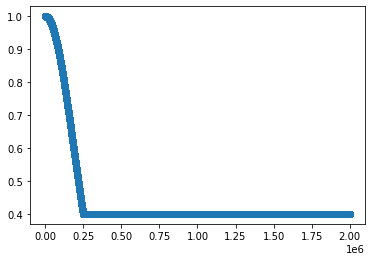

In [ ]:
ll=[]
lamb=1.0
lamb_min=0.4
lamb_lr=3e-11
lamb_epoch=int(2e6)

for i in range(lamb_epoch):
  ll.append(lamb)
  if (i%100):
    if(lamb>lamb_min):
      lamb=lamb*np.exp(-i*lamb_lr)


lamb_x=np.arange(len(ll))
plt.scatter(lamb_x,ll)

In [ ]:
model.encoder.compile
model.decoder.compile

<bound method Model.compile of <keras.engine.sequential.Sequential object at 0x7fea5ba9f410>>

In [ ]:
model.encoder.summary(),model.decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               1843712   
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 500)               128500    
                                                                 
Total params: 2,103,540
Trainable params: 2,103,540
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               128256    
                                                                 
 dense_16 (Dense)     

(None, None)

In [ ]:
###############################################################
#      Saving the model weights and architechture             #
###############################################################

####change the path to gdrive to save there

# https://www.reddit.com/r/learnmachinelearning/comments/t4dbmb/how_to_save_vae_model_made_by_keras/

model.get_layer('sequential').save_weights('encoder_weights.h5')
model.get_layer('sequential_1').save_weights('decoder_weights.h5')
model.get_layer('sequential').save('encoder_arch') 
model.get_layer('sequential_1').save('decoder_arch') 

In [ ]:
tf.keras.models.save_model(model.encoder,'path', overwrite=False)
tf.keras.models.save_model(model.decoder,path, overwrite=False)

[WARNING] /content/gdrive/MyDrive/STbVAE/ already exists - overwrite? [y/n]n


In [ ]:
#for loading the weights and architecture to new model:

new_bae_model=bVAE(latent_dim)

new_bae_model.encoder.summary(),new_bae_model.decoder.summary()




Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               1843712   
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 500)               128500    
                                                                 
Total params: 2,103,540
Trainable params: 2,103,540
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 256)               128256    
                                                                 
 dense_28 (Dense)     

(None, None)

In [ ]:
new_bae_model.encoder=tf.keras.models.load_model('encoder_arch', custom_objects=None, compile=False, options=None)
new_bae_model.decoder=tf.keras.models.load_model('decoder_arch', custom_objects=None, compile=False, options=None)

# https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c

In [ ]:
model.encoder.save(path)

In [ ]:

def objective(rho,t):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    
    rho = rho.reshape((Nx, Ny))
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space]=t
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    

    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return mode_overlap(Ez, probe) / E0



numpy.ndarray

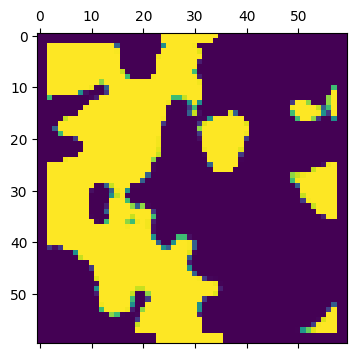

In [ ]:
train_dataset=es
train_dataset=np.reshape(train_dataset,(len(train_dataset),1,3600))
#train_dataset=tf.cast(np.reshape(train_dataset,(len(train_dataset),1,3600)),tf.float32)
train_dataset=((train_dataset-1.0)/11.0) #normalizing the dataset
#train_dataset=tf.make_ndarray(train_dataset)
#np.random.shuffle(train_dataset)




index=45

plt.matshow(np.reshape(train_dataset[index],(60,60))),train_dataset[index].min(),train_dataset[index].max()


type(train_dataset)

In [ ]:

objective(rho,np.reshape(train_dataset[index],(60,60)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

16648301.089455789

###JUST BINARIZE EVRY DESIGN AND GET THEIR OBJECTIVE VALUE. THEN COMPRESS IT AND RUN THE OPTIMIZATION

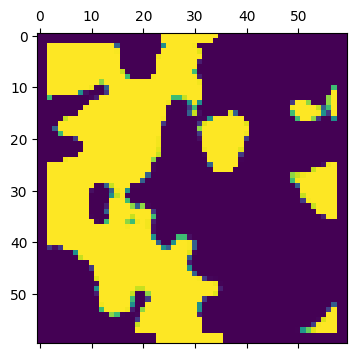

In [ ]:
plt.matshow(np.reshape(train_dataset[index],(60,60)))

(<matplotlib.image.AxesImage at 0x7fc54d11add0>, 0.0, 1.0)

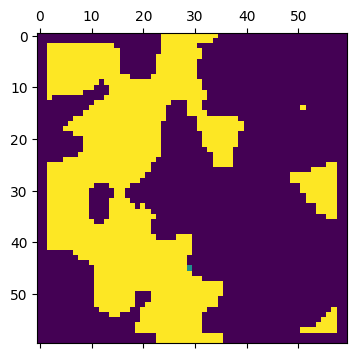

In [ ]:
train_dataset2=np.copy(train_dataset)
train_dataset2[train_dataset2<0.5]=0.0
train_dataset2[train_dataset2>0.5]=1.0


index2=43
plt.matshow(np.reshape(train_dataset2[index2],(60,60))),train_dataset2[index2].min(),train_dataset2[index2].max()

In [ ]:
objective(rho,np.reshape(train_dataset2[index2],(60,60)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

19742845.98266491

In [ ]:
pre=np.copy(model.layers[0].get_weights()[0])
pre1=model.layers[1].get_weights()[0]
post=model.layers[0].get_weights()[0]
pre.all()==post.all()

True

In [ ]:
'''

## Autoencoder Training

tl=[]

epochs=100
for epoch in range(1, epochs + 1):
  #np.random.shuffle(train_dataset2)

  start_time = time.time()
  for train_x in train_dataset2:
    t,r,k=train_stepAE(model,train_x,optimizer)
    tl.append(t)

  if (epoch%1==0):
    print('Time for epoch {} is {} sec, Loss: {} '.format(epoch + 1, time.time()-start_time,t))
  #if(tf.cast(lambd,tf.float32)>tf.cast(lambd_min,tf.float32)):
    #lambd=tf.cast(lambd,tf.float32)*tf.math.exp(-tf.cast(epoch,tf.float32)*lambd_learning_rate)
  end_time = time.time()

'''

"\n\n## Autoencoder Training\n\ntl=[]\n\nepochs=100\nfor epoch in range(1, epochs + 1):\n  #np.random.shuffle(train_dataset2)\n\n  start_time = time.time()\n  for train_x in train_dataset2:\n    t,r,k=train_stepAE(model,train_x,optimizer)\n    tl.append(t)\n\n  if (epoch%1==0):\n    print('Time for epoch {} is {} sec, Loss: {} '.format(epoch + 1, time.time()-start_time,t))\n  #if(tf.cast(lambd,tf.float32)>tf.cast(lambd_min,tf.float32)):\n    #lambd=tf.cast(lambd,tf.float32)*tf.math.exp(-tf.cast(epoch,tf.float32)*lambd_learning_rate)\n  end_time = time.time()\n\n"

In [ ]:
'''
## Connected Autoencoder Training

tl=[]
rl=[]
kl=[]

epochs=1
for epoch in range(1, epochs + 1):
  #np.random.shuffle(train_dataset2)

  start_time = time.time()
  for train_x in train_dataset2:
    t,r,k=train_stepAE_connected(model,train_x,optimizer)
    tl.append(t)
    rl.append(r)
    kl.append(k)

  if (epoch%1==0):
    print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(epoch + 1, time.time()-start_time,t,r,k))
  #if(tf.cast(lambd,tf.float32)>tf.cast(lambd_min,tf.float32)):
    #lambd=tf.cast(lambd,tf.float32)*tf.math.exp(-tf.cast(epoch,tf.float32)*lambd_learning_rate)
  end_time = time.time()

'''

'''
#batch gradient descent

tl=[]
rl=[]
kl=[]
epochs=200
for epoch in range(1, epochs + 1):
  start_time = time.time()
  t,r,k=train_step2_AE_connected(model,train_dataset2,optimizer)
  tl.append(t)
  rl.append(r)
  kl.append(k)
  if (epoch%1==0):
    print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(epoch + 1, time.time()-start_time,t,r,k))
  #if(tf.cast(lambd,tf.float32)>tf.cast(lambd_min,tf.float32)):
    #lambd=tf.cast(lambd,tf.float32)*tf.math.exp(-tf.cast(epoch,tf.float32)*lambd_learning_rate)
  end_time = time.time()
  '''

"\n#batch gradient descent\n\ntl=[]\nrl=[]\nkl=[]\nepochs=200\nfor epoch in range(1, epochs + 1):\n  start_time = time.time()\n  t,r,k=train_step2_AE_connected(model,train_dataset2,optimizer)\n  tl.append(t)\n  rl.append(r)\n  kl.append(k)\n  if (epoch%1==0):\n    print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(epoch + 1, time.time()-start_time,t,r,k))\n  #if(tf.cast(lambd,tf.float32)>tf.cast(lambd_min,tf.float32)):\n    #lambd=tf.cast(lambd,tf.float32)*tf.math.exp(-tf.cast(epoch,tf.float32)*lambd_learning_rate)\n  end_time = time.time()\n  "

In [ ]:

## STOCHASTIC GRADIENT DESCENT

tl=[]
rl=[]
kl=[]
l=[]
epochs=500
for epoch in range(1, epochs + 1):
  #np.random.shuffle(train_dataset2)

  start_time = time.time()



  #np.random.shuffle(train_dataset2) # shuffling every epoch



  for train_x in train_dataset2:
    t,r,k=train_step(model,train_x,optimizer)
    tl.append(t)
    rl.append(r)
    kl.append(k)
    l.append(lambd)
  if (epoch%1==0):
    print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(epoch + 1, time.time()-start_time,t,r,k))

#the below part is edited to anneal the temp
  if (epoch%100):
    if(tf.cast(lambd,tf.float32)>tf.cast(lambd_min,tf.float32)):
      lambd=tf.cast(lambd,tf.float32)*tf.math.exp(-tf.cast(epoch,tf.float32)*lambd_learning_rate)
  end_time = time.time()
  


Time for epoch 2 is 1.7052910327911377 sec, Loss: 10.460090637207031,0.024232450872659683,4.4019775390625 
Time for epoch 3 is 1.454446792602539 sec, Loss: 10.279056549072266,0.023370496928691864,4.436431884765625 
Time for epoch 4 is 1.0212657451629639 sec, Loss: 14.099872589111328,0.038236524909734726,4.540740966796875 
Time for epoch 5 is 1.0175073146820068 sec, Loss: 10.957623481750488,0.025208545848727226,4.655487060546875 
Time for epoch 6 is 1.0301928520202637 sec, Loss: 10.361627578735352,0.023778051137924194,4.4171142578125 
Time for epoch 7 is 1.056802749633789 sec, Loss: 11.486129760742188,0.02885943464934826,4.271270751953125 
Time for epoch 8 is 1.0391149520874023 sec, Loss: 12.671759605407715,0.033766504377126694,4.230133056640625 
Time for epoch 9 is 1.0251541137695312 sec, Loss: 16.068593978881836,0.04640572518110275,4.4671630859375 
Time for epoch 10 is 1.4393305778503418 sec, Loss: 10.14185619354248,0.023515544831752777,4.262969970703125 
Time for epoch 11 is 1.439256

In [ ]:
'''
post=model.layers[0].get_weights()[0]
post1=model.layers[1].get_weights()[0]
pre.all()==post.all()
'''

'\npost=model.layers[0].get_weights()[0]\npost1=model.layers[1].get_weights()[0]\npre.all()==post.all()\n'

In [ ]:
lambd

<tf.Tensor: shape=(), dtype=float32, numpy=0.39960483>

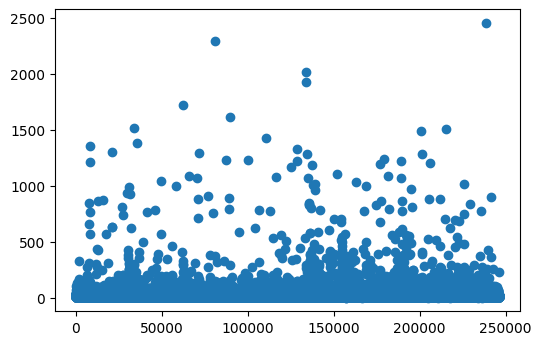

In [ ]:
x=np.arange(len(tl))
plt.scatter(x,tl)

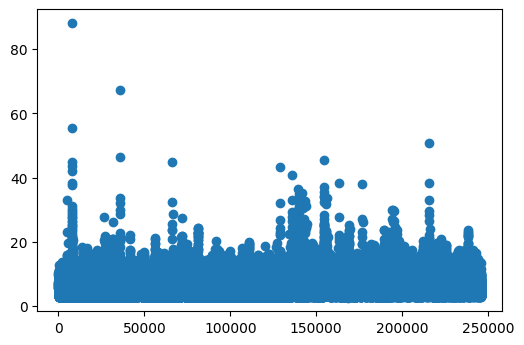

In [ ]:
plt.scatter(x,kl)

'\nbasically there is an issue with the reconstruction loss. \nIts a training data not test data. So with every iteration the loss should have gone down\nbut it appears to be periodic, which means its not really "learning", just memorising.\n\nBASICALLY, THE OUTPUT OF THE DECODER DOESN\'T CHANGE FOR ANY INPUT GIVEN TO IT. i.e THE OUTPUT REMAINS FIXED.\nTHATS WHY THE DIFFERENCE B/W THE FIXED OUTPUT AND THE EXPECTED OUTPUT IS REPEATING WITH EVERY ITERATION.\n\n'

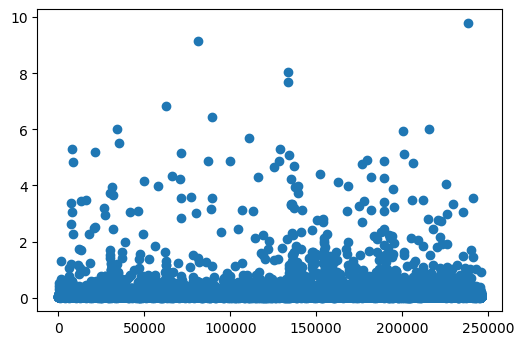

In [ ]:
plt.scatter(x,rl) 
'''
basically there is an issue with the reconstruction loss. 
Its a training data not test data. So with every iteration the loss should have gone down
but it appears to be periodic, which means its not really "learning", just memorising.

BASICALLY, THE OUTPUT OF THE DECODER DOESN'T CHANGE FOR ANY INPUT GIVEN TO IT. i.e THE OUTPUT REMAINS FIXED.
THATS WHY THE DIFFERENCE B/W THE FIXED OUTPUT AND THE EXPECTED OUTPUT IS REPEATING WITH EVERY ITERATION.

'''

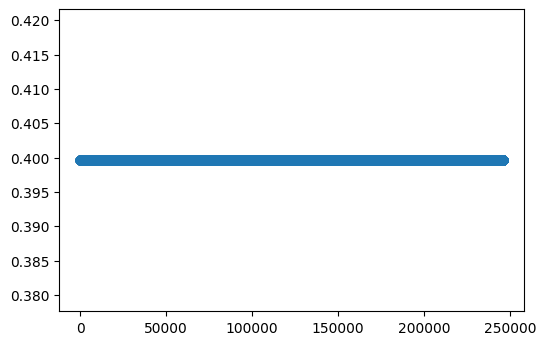

In [ ]:
plt.scatter(x,l)

In [ ]:
#BATCH GRADIENT DESCENT

tl=[]
rl=[]
kl=[]
epochs=100
for epoch in range(1, epochs + 1):
  #np.random.shuffle(train_dataset2) # shuffling every epoch....FOR BGD I THINK THIS IS REDUNDAANT
  start_time = time.time()
  t,r,k=train_step2(model,train_dataset2,optimizer)
  tl.append(t)
  rl.append(r)
  kl.append(k)
  if (epoch%1==0):
    print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(epoch + 1, time.time()-start_time,t,r,k))
   
  if (epoch%10):
    if(tf.cast(lambd,tf.float32)>tf.cast(lambd_min,tf.float32)):
      lambd=tf.cast(lambd,tf.float32)*tf.math.exp(-tf.cast(epoch,tf.float32)*lambd_learning_rate)
  end_time = time.time()


Time for epoch 2 is 13.065577507019043 sec, Loss: 19.29899787902832,0.0535086989402771,5.921818256378174 
Time for epoch 3 is 7.699056148529053 sec, Loss: 19.074739456176758,0.052618179470300674,5.920188903808594 
Time for epoch 4 is 6.991387128829956 sec, Loss: 19.47248077392578,0.054243117570877075,5.911708831787109 
Time for epoch 5 is 7.200881481170654 sec, Loss: 20.068378448486328,0.05668436363339424,5.897292137145996 
Time for epoch 6 is 7.1816933155059814 sec, Loss: 19.20661735534668,0.05331583693623543,5.8776726722717285 
Time for epoch 7 is 6.9351043701171875 sec, Loss: 19.707454681396484,0.05541529133915901,5.853630542755127 
Time for epoch 8 is 7.156187057495117 sec, Loss: 19.201791763305664,0.05349820479750633,5.827246189117432 
Time for epoch 9 is 7.175421476364136 sec, Loss: 19.857213973999023,0.05623147636651993,5.799353122711182 
Time for epoch 10 is 6.8725481033325195 sec, Loss: 20.58694839477539,0.059262726455926895,5.771267890930176 
Time for epoch 11 is 7.1787376403

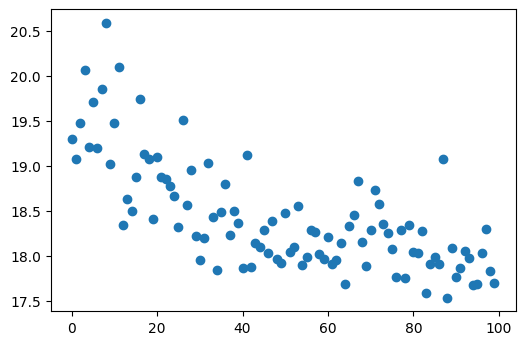

In [ ]:
x=np.arange(len(tl))
plt.scatter(x,tl)

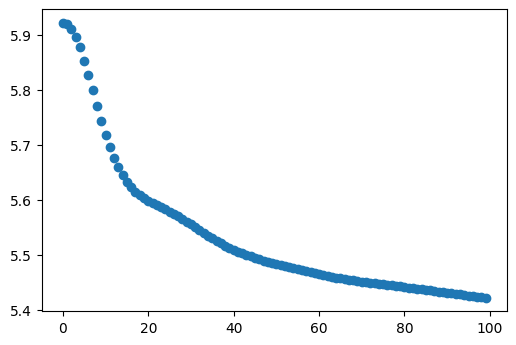

In [ ]:
x=np.arange(len(tl))
plt.scatter(x,kl)

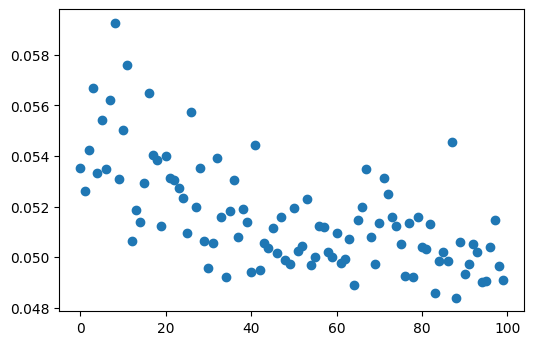

In [ ]:
x=np.arange(len(tl))
plt.scatter(x,rl)

In [ ]:
#####################################################################
#CREATING THE BINARY VECTOR FOR THE FM
#####################################################################


bv=[]
for i in train_dataset2:
  i1=model.encoder(i)
  i2=np.array(tf.clip_by_value(model.gumbell_reparam(i1,lambd),1e-10,1.0-(1e-7)))
  bv.append(i2)

bv=np.array(bv)


In [ ]:
np.shape(bv)

(492, 1, 500)

In [ ]:
np.shape(bv[1])

(1, 500)

In [ ]:
index1=100
index2=200

'''
x_hat1=model.encoder(train_dataset2[index1])
x_hat2=model.encoder(train_dataset2[index2])
'''

a1=model.encoder(train_dataset2[index1])
a2=model.encoder(train_dataset2[index2])
'''
a1=model.middle_layer(a1)
a2=model.middle_layer(a2)

x_hat1=model.decoder(a1)
x_hat2=model.decoder(a2)
'''
b1=tf.clip_by_value(model.gumbell_reparam(a1,lambd),1e-10,1.0-(1e-7))
b2=tf.clip_by_value(model.gumbell_reparam(a2,lambd),1e-10,1.0-(1e-7))

c1=model.binary_activation(b1)
c2=model.binary_activation(b2)


x_hat1=model.decoder(c1)
x_hat2=model.decode(c2)




In [ ]:
x_hat1=np.reshape(x_hat1,(60,60))

'''
x_hat1=np.copy(x_hat1)
x_hat1[x_hat1<0.5]=0.0
x_hat1[x_hat1>0.5]=1.0
'''
t1=np.reshape(train_dataset2[index1],(60,60))

x_hat2=np.reshape(x_hat2,(60,60))
'''
x_hat2=np.copy(x_hat2)
x_hat2[x_hat1<0.5]=0.0
x_hat2[x_hat1>0.5]=1.0
'''
t2=np.reshape(train_dataset2[index2],(60,60))

(<matplotlib.image.AxesImage at 0x7fc54d6de950>,
 <matplotlib.image.AxesImage at 0x7fc5492f6b90>)

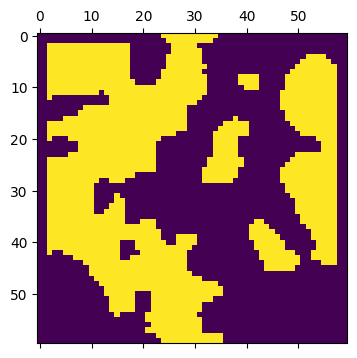

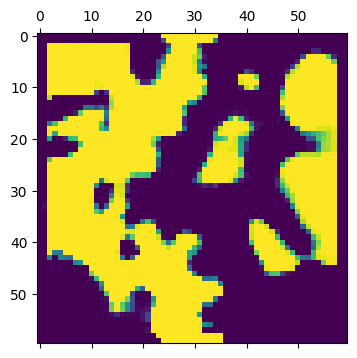

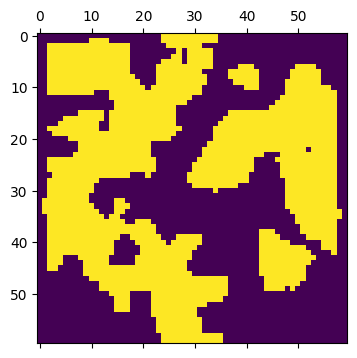

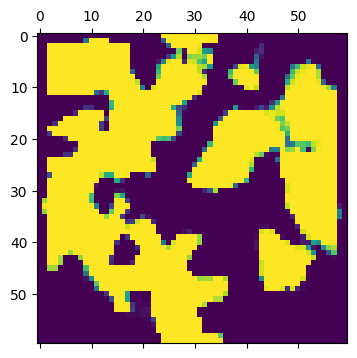

In [ ]:
plt.matshow(t1),plt.matshow(x_hat1),plt.matshow(t2),plt.matshow(x_hat2)

In [ ]:
a1

<tf.Tensor: shape=(1, 500), dtype=float32, numpy=
array([[ 0.5004,  0.5033,  0.4937,  0.4946,  0.4882,  0.4849,  0.4849,
         0.4968,  0.5120,  0.4771,  0.4922,  0.5124,  0.5033,  0.4824,
         0.4744,  0.4859,  0.4932,  0.5006,  0.5031,  0.4900,  0.4998,
         0.5030,  0.4920,  0.5052,  0.5018,  0.5103,  0.4761,  0.5090,
         0.4759,  0.5049,  0.4820,  0.5037,  0.4902,  0.4710,  0.4942,
         0.4926,  0.4854,  0.4858,  0.4879,  0.4863,  0.4869,  0.4800,
         0.4781,  0.4958,  0.4840,  0.5014,  0.4944,  0.4913,  0.5166,
         0.4976,  0.5040,  0.5141,  0.4850,  0.4792,  0.5220,  0.4960,
         0.4956,  0.5229,  0.4956,  0.5055,  0.4946,  0.4874,  0.5120,
         0.4649,  0.4805,  0.4833,  0.0000,  0.4855,  0.5195,  0.4776,
         0.4753,  0.4820,  0.4906,  0.4565,  0.4756,  0.5127,  0.4992,
         0.4855,  0.4704,  0.4920,  0.4714,  0.5141,  0.4998,  0.5135,
         0.6638,  0.4871,  0.4954,  0.4851,  0.4901,  0.4935,  0.4909,
         0.4989,  0.5057,  

In [ ]:
b1

<tf.Tensor: shape=(1, 500), dtype=float32, numpy=
array([[ 0.8280,  0.2474,  0.0052,  0.8937,  0.0428,  0.7296,  0.0259,
         0.9757,  0.9550,  0.1866,  0.2003,  0.9865,  0.9856,  0.0530,
         0.1157,  0.0104,  0.9758,  0.0569,  1.0000,  0.8705,  0.9911,
         0.8157,  0.9996,  0.0505,  0.0414,  0.6109,  0.6657,  0.1489,
         0.6482,  0.1015,  0.9889,  0.1973,  0.2839,  0.3693,  1.0000,
         0.3706,  0.0001,  0.0111,  0.9523,  0.1249,  0.8685,  0.8600,
         0.0876,  0.0575,  0.6345,  0.6495,  0.6100,  0.2514,  0.3768,
         0.9859,  0.3354,  0.0238,  0.0583,  0.0256,  0.9549,  0.9940,
         0.0151,  0.9380,  0.9616,  0.1131,  0.9962,  0.9716,  0.1222,
         0.9779,  0.0386,  0.3173,  0.0000,  0.9940,  0.8634,  0.8570,
         0.4428,  0.1700,  0.1281,  0.5984,  0.6533,  0.8933,  0.8045,
         0.0016,  0.0026,  0.8579,  0.0435,  0.5123,  0.0000,  0.0327,
         0.9999,  0.0000,  0.9790,  0.3501,  0.2058,  0.0002,  0.9968,
         0.9873,  0.9945,  

In [ ]:
c1

<tf.Tensor: shape=(1, 500), dtype=float32, numpy=
array([[ 1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
         1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,
         1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  1.0000,
         0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
         0.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         1.0000,  1.0000,  

(<matplotlib.image.AxesImage at 0x7fc54cfde5d0>,
 <matplotlib.image.AxesImage at 0x7fc54dc01790>)

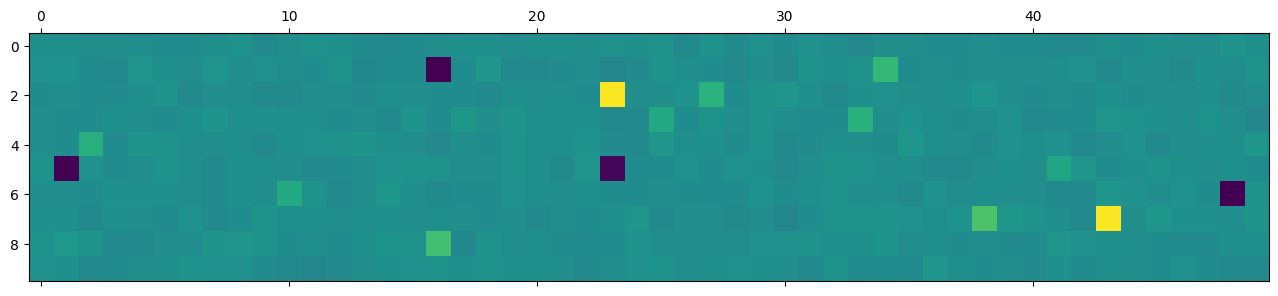

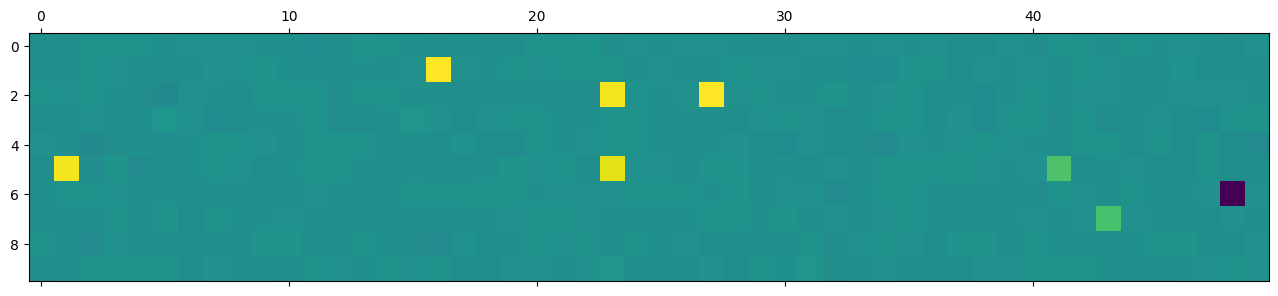

In [ ]:
plt.matshow(np.reshape(a1,(10,50)))
plt.colorbar()

plt.matshow(np.reshape(a2,(10,50)))
plt.colorbar()

(<matplotlib.image.AxesImage at 0x7fc547ecd290>,
 <matplotlib.image.AxesImage at 0x7fc547bda410>)

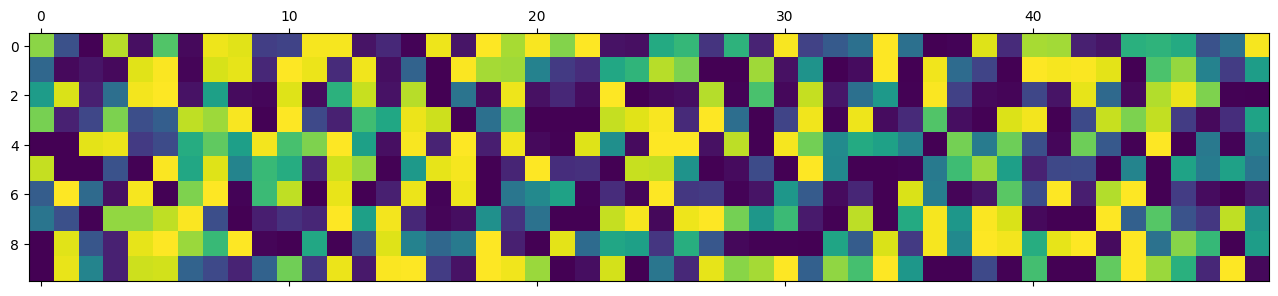

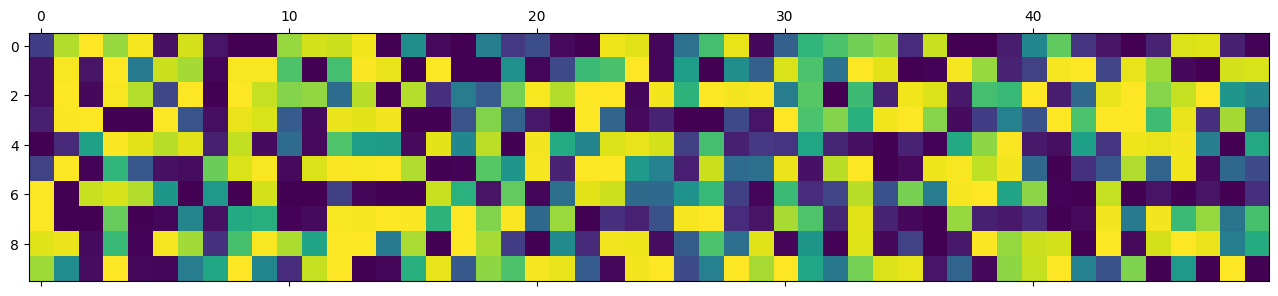

In [ ]:
plt.matshow(np.reshape(b1,(10,50)))
plt.colorbar()

plt.matshow(np.reshape(b2,(10,50)))
plt.colorbar()

(<matplotlib.image.AxesImage at 0x7fc547acab10>,
 <matplotlib.image.AxesImage at 0x7fc5473cd710>)

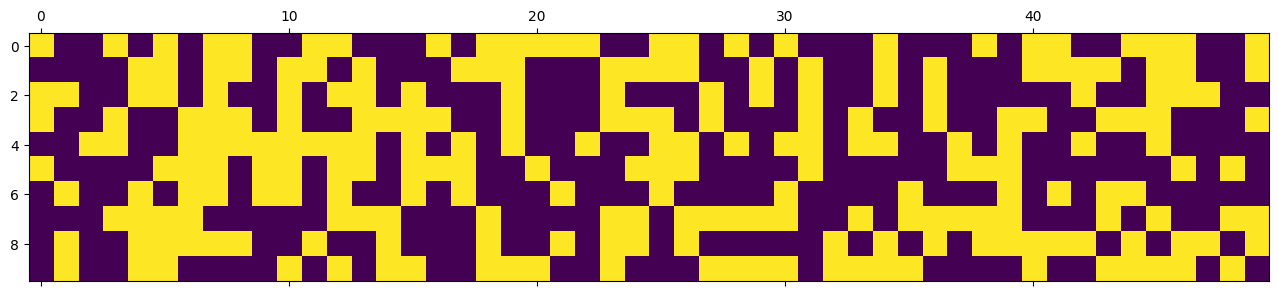

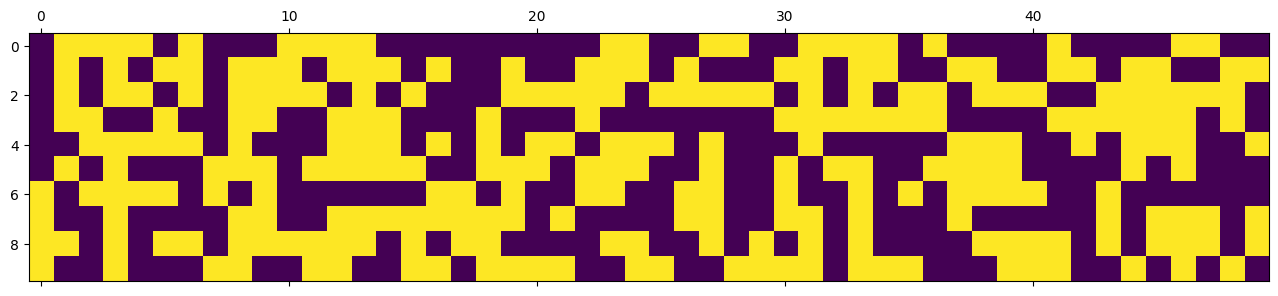

In [ ]:
plt.matshow(np.reshape(c1,(10,50)))
plt.colorbar()

plt.matshow(np.reshape(c2,(10,50)))
plt.colorbar()

It should be noted that some outputs will be a bit absurd. I am assuming that they are basically the region between the interpolation.

(<matplotlib.image.AxesImage at 0x7fc54ca6ef90>,
 <matplotlib.image.AxesImage at 0x7fc54cc65cd0>)

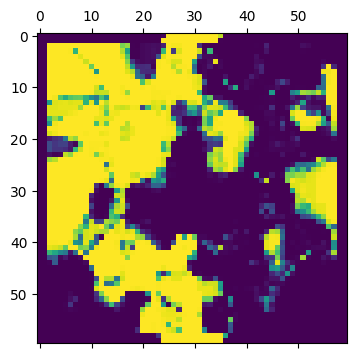

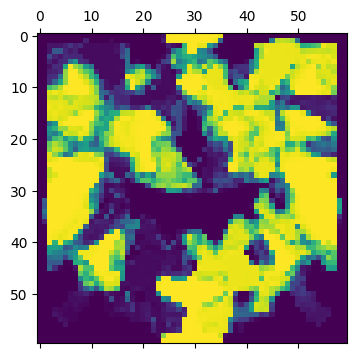

In [ ]:
#random sampling for generating
plt.matshow(np.reshape(model.decoder([tf.reshape(tfp.distributions.Bernoulli(probs=0.1).sample((latent_dim,)),(1,latent_dim))]),(60,60))),plt.matshow(np.reshape(model.decoder([tf.reshape(tfp.distributions.Bernoulli(probs=0.9).sample((latent_dim,)),(1,latent_dim))]),(60,60)))

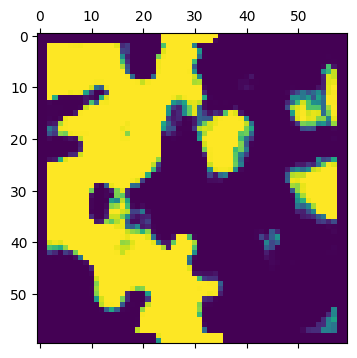

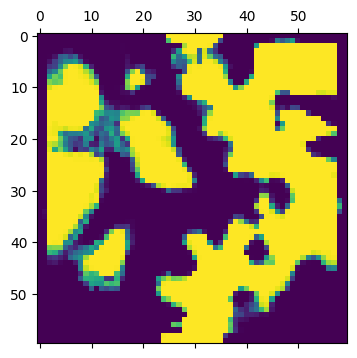

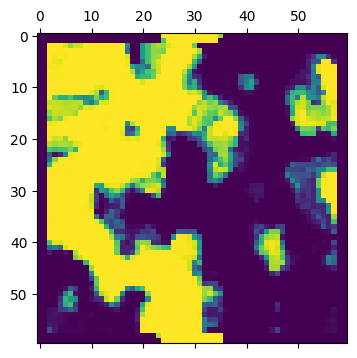

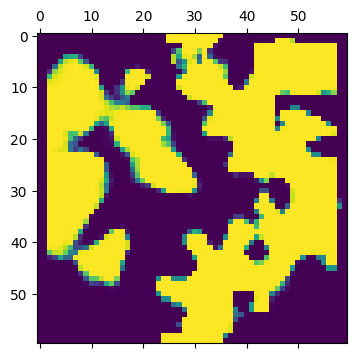

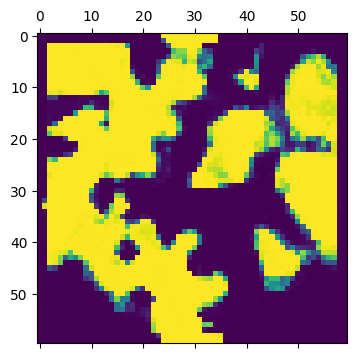

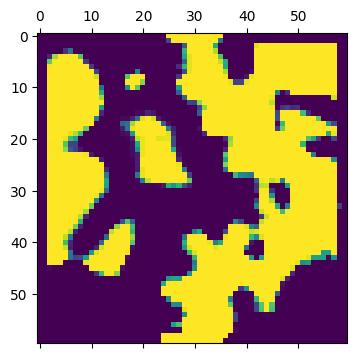

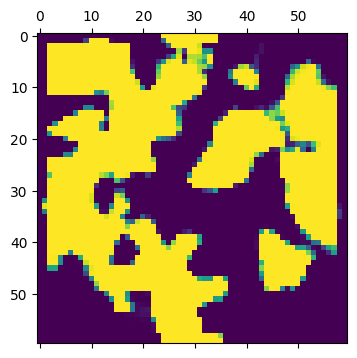

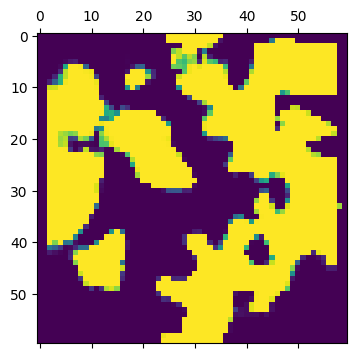

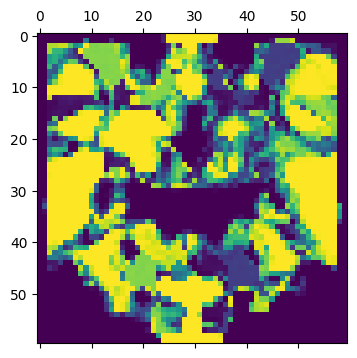

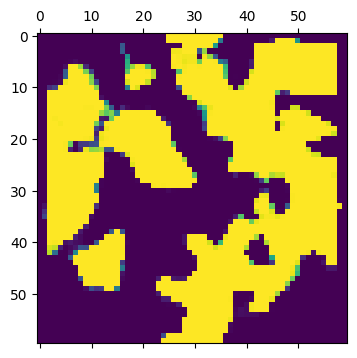

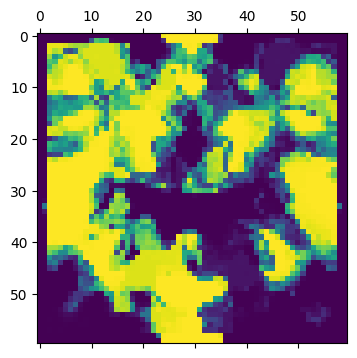

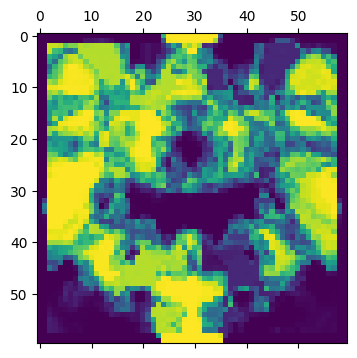

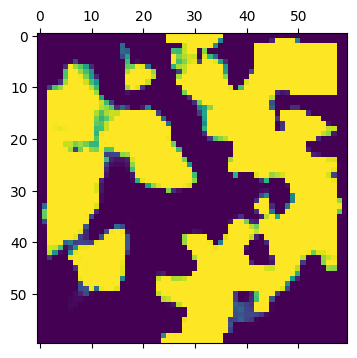

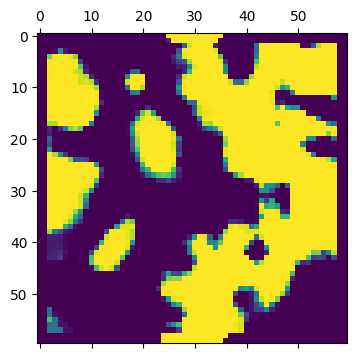

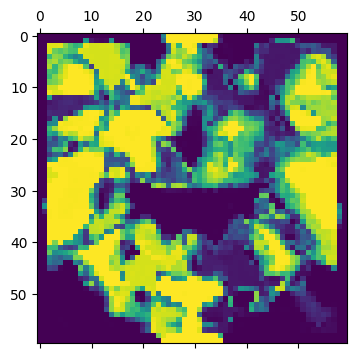

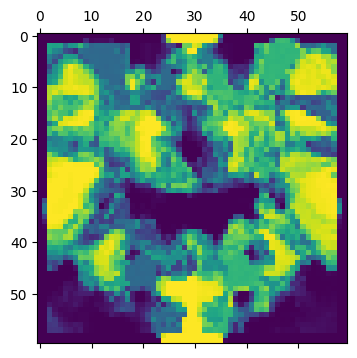

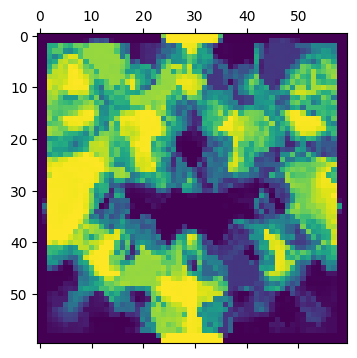

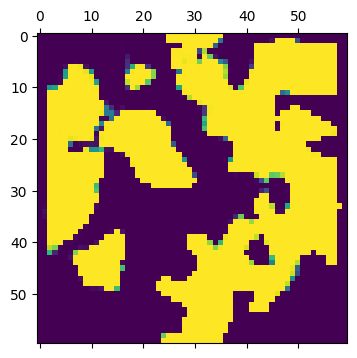

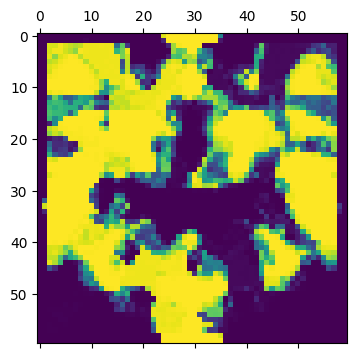

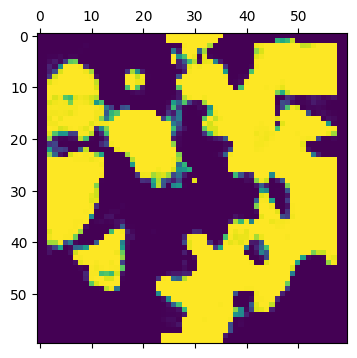

In [ ]:
for i in range(20):
  plt.matshow(np.reshape(model.decoder([tf.reshape(tfp.distributions.Bernoulli(probs=0.5).sample((latent_dim,)),(1,latent_dim))]),(60,60)))

In [ ]:
[tf.reshape(tfp.distributions.Bernoulli(probs=0.50).sample((latent_dim,)),(1,latent_dim))]

In [ ]:
with tf.GradientTape(persistent=True) as tape:
  a=tf.clip_by_value(model.encoder(train_dataset[5],training=True),1e-10,1.0-1e-7)#model.encoder(train_dataset[5],training=True)
  a1=model.encoder(train_dataset[9],training=True)
  #b=model.gumbell_reparam(a,lambd)
  b=model.middle_layer(a)
  x_hat=model.decoder(b,training=True)
  reconstruction_loss=tf.math.reduce_mean(tf.math.pow(train_dataset[5]-x_hat,2))
  KL_loss=(tf.math.reduce_sum(tf.math.multiply(a,tf.math.log(a))+tf.math.multiply(1.0-a,tf.math.log(1.0-a))))+tf.math.multiply(tf.cast(latent_dim, tf.float32),tf.math.log(2.0))#this equation is correct
  total_loss=(reconstruction_loss+ KL_loss)


  
gradients = tape.gradient(total_loss, model.trainable_variables)


In [ ]:
tape.gradient(total_loss,model.encoder.trainable_variables)

In [ ]:
test_dataset=tf.constant(np.array(np.random.rand(101,1,3600)),dtype=tf.float32)

In [ ]:
loss = tf.keras.metrics.Mean()
for data in test_dataset:
  loss(compute_loss(model,data))
  
elbo = -loss.result()
display.clear_output(wait=False)
print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))



Epoch: 20, Test set ELBO: 345.8791809082031, time elapse for current epoch: 1.8466722965240479


# Factorization Machine

In [ ]:
import numpy as np
import tensorflow as tf



In [ ]:
dim2=40
bv_length=len(bv)
epochs = range(1000)

In [ ]:
len(y_l)

492

In [ ]:
len(bv)

492

In [ ]:
np.shape(bv)

(492, 1, 500)

In [ ]:
X=np.reshape(bv,(len(bv),latent_dim))

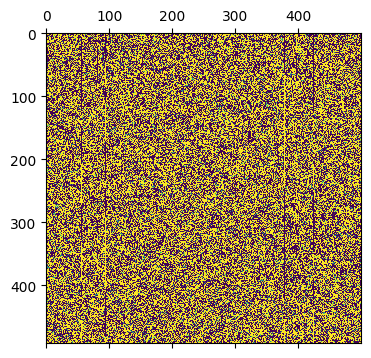

In [ ]:
plt.matshow(X)
plt.colorbar()

In [ ]:
np.shape(X)

(492, 500)

In [ ]:
fm_trainingdataset=[y_l,X]

In [ ]:
y=np.reshape(y_l,(len(bv),1))
y=y.astype("float32")

In [ ]:
'''
#LOSS FUNCTION
display(Math(r'L = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda_w ||W||^2 + \lambda_v ||V||^2'))
'''

"\n#LOSS FUNCTION\ndisplay(Math(r'L = \\sum_{i=1}^{n} (y_i - \\hat{y}_i)^2 + \\lambda_w ||W||^2 + \\lambda_v ||V||^2'))\n"

In [ ]:
class FM(tf.Module):
  def __init__(self,latent_dim=latent_dim,dim2=dim2,bv_length=bv_length):
    super(FM,self).__init__()
    self.latent_dim=latent_dim
    self.dim2=dim2
    self.bv_length=bv_length
    self.W=tf.Variable(tf.random.normal([dim2, latent_dim], stddev=0.01))

  def __call__(self,X,latent_dim=latent_dim,dim2=dim2,bv_length=bv_length):
    y_hat = (tf.multiply(0.5,
                    tf.reduce_sum(
                        tf.subtract(
                            tf.pow( tf.matmul(X, tf.transpose(self.W)), 2),
                            tf.matmul(tf.pow(X, 2), tf.transpose(tf.pow(self.W, 2)))),
                        1, keepdims=True)))
    
    return y_hat


def loss_fm(model, y_hat, y):
  lambda_w = tf.constant(0.001, name='lambda_w')
  
  l2_norm = (tf.reduce_sum(
          
                tf.multiply(lambda_w, tf.pow(model.W, 2))
               ))
  error = tf.reduce_mean(tf.square(tf.subtract(y, y_hat)))
  loss = tf.add(error, l2_norm)
  return loss

def fm_train(model,X=X,y=y_l,learning_rate=0.00000000001):
  with tf.GradientTape() as t:
    current_loss=loss_fm(model,model(X),y)

  dW=t.gradient(current_loss, model.W)
  model.W.assign_sub(learning_rate * dW)
  





def report(model, loss):
  return f"loss={loss:2.5f}"




def fm_training_loop(model, X=X, y=y_l):

  for epoch in epochs:
    # Update the model with the single giant batch
    fm_train(model, X, y)

    # Track this before I update
    current_loss = loss_fm(model, model(X),y)
    fmloss.append(current_loss)
    

    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))


In [ ]:
fmloss=[]
fm_model=FM()

In [ ]:
fm_train(fm_model)

In [ ]:
loss_fm(fm_model,fm_model(X),y_l)

<tf.Tensor: shape=(), dtype=float32, numpy=477528830000000.0>

In [ ]:
current_loss = loss_fm(fm_model, fm_model(X),y_l)

print(f"Starting:")
print("    ", report(fm_model, current_loss))

fm_training_loop(fm_model, X, y_l)





Starting:
     loss=477528825266176.00000
Epoch  0:
     loss=477528825266176.00000
Epoch  1:
     loss=477528825266176.00000
Epoch  2:
     loss=477528825266176.00000
Epoch  3:
     loss=477528825266176.00000
Epoch  4:
     loss=477528825266176.00000
Epoch  5:
     loss=477528825266176.00000
Epoch  6:
     loss=477528825266176.00000
Epoch  7:
     loss=477528825266176.00000
Epoch  8:
     loss=477528825266176.00000
Epoch  9:
     loss=477528825266176.00000
Epoch 10:
     loss=477528791711744.00000
Epoch 11:
     loss=477528758157312.00000
Epoch 12:
     loss=477528758157312.00000
Epoch 13:
     loss=477528758157312.00000
Epoch 14:
     loss=477528724602880.00000
Epoch 15:
     loss=477528724602880.00000
Epoch 16:
     loss=477528724602880.00000
Epoch 17:
     loss=477528724602880.00000
Epoch 18:
     loss=477528724602880.00000
Epoch 19:
     loss=477528724602880.00000
Epoch 20:
     loss=477528724602880.00000
Epoch 21:
     loss=477528691048448.00000
Epoch 22:
     loss=47752865749401

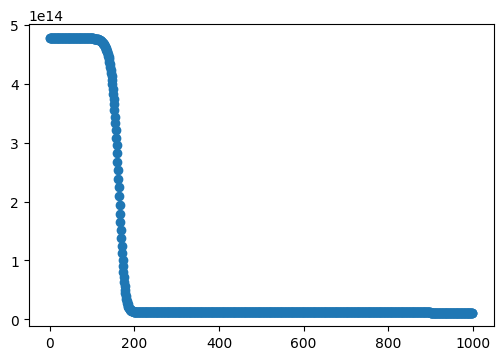

In [ ]:
x_fm=np.arange(len(fmloss))
plt.scatter(x_fm,fmloss)

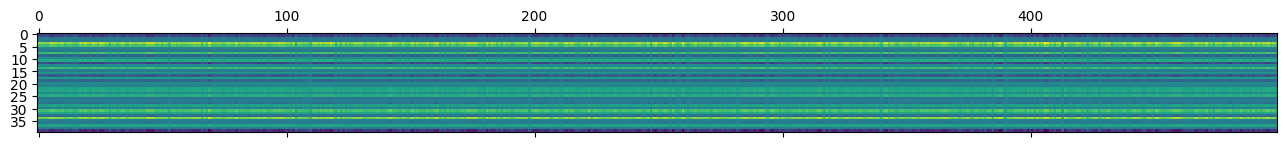

In [ ]:
plt.matshow(fm_model.W)

In [ ]:
#I THINK JUST SAVING THE W AND V MATRIX IS ENOUGH. NO NEED TO DO ALL THAT SAVE MODEL STUFF...

In [ ]:
J=tf.matmul(tf.transpose(fm_model.W),fm_model.W)

In [ ]:
J

<tf.Tensor: shape=(500, 500), dtype=float32, numpy=
array([[ 864.7452,  709.4886,  760.9370, ...,  722.6530,  808.7014,
         647.4126],
       [ 709.4886,  582.1111,  624.3203, ...,  592.9094,  663.5090,
         531.1779],
       [ 760.9370,  624.3203,  669.5982, ...,  635.9050,  711.6242,
         569.6975],
       ...,
       [ 722.6530,  592.9094,  635.9050, ...,  603.9154,  675.8201,
         541.0344],
       [ 808.7014,  663.5090,  711.6242, ...,  675.8201,  756.2949,
         605.4554],
       [ 647.4126,  531.1779,  569.6975, ...,  541.0344,  605.4554,
         484.7075]], dtype=float32)>

#ISING SOLVER